In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN

In [76]:
torch.cuda.device_count()

4

In [77]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [78]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [79]:
showers_train = torch.load('./data/showers_train.pt')

In [80]:
showers_train = [shower.to(device) for shower in showers_train[:20]]

In [81]:
showers_train[0]

Data(edge_attr=[44065, 1], edge_index=[2, 44065], pos=[8816, 5], x=[8816, 5], y=[8816])

In [82]:
np.unique(showers_train[0].y.cpu().detach().numpy())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Features creation

In [83]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/data[:, 0]).view(shape_0,1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /data[:, 2]).view(shape_0,1)
    
    feat_2 = (data[:, 0]/data[:, 2]).view(shape_0,1)
    
    feat_3 = (data[:, 1]/data[:, 2]).view(shape_0,1)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3), 1)

In [84]:
showers_train[0].x.shape

torch.Size([8816, 9])

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [85]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [86]:
Z_centered = Z - 73701. / 2

In [87]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [88]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

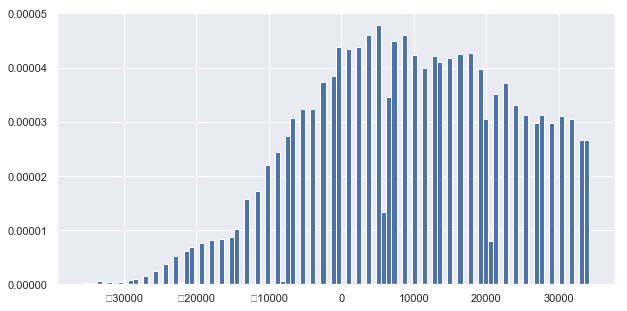

In [89]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


## Masks for activating only those edges that are connecting the same shower

In [90]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu()) * np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            if z_0_i == z_i:
                # TODO data.edge_index[0] vs data.edge_index[1]
                orders[i][(data.edge_index[0] == j).cpu().numpy().astype(bool)] = 1
            
    return orders.astype(np.uint8)

In [91]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

## GNN 

In [ ]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate('add', 
                               torch.index_select(edge_index[:, torch.ByteTensor(order)], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [ ]:
class GraphNN_KNN(torch.nn.Module):
    def __init__(self, k=9, dim_out=10):
        super().__init__()
        self.k = k
        
        self.emconv = EmulsionConv(self.k, dim_out)    
        
        
        #self.conv2 = GCNConv(18, 36)
        #self.conv3 = GCNConv(36, 18)
        #self.conv4 = GCNConv(18, dim_out)
        
        
        self.layer_2 = nn.Linear(dim_out, 18)
        self.nonlinear_2 = nn.LeakyReLU()
        
        self.layer_3 = nn.Linear(18, 24)
        self.nonlinear_3 = nn.ReLU()
        
        #self.conv1 = GCNConv(24, 18)
        
        self.output = nn.Linear(24, dim_out)
        
        
    def forward(self, data, mask):
        x, edge_index, orders = data.x, data.edge_index, mask
        
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)  
        
        #x = self.conv1(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv2(x, edge_index)
        #x = self.conv3(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv4(x, edge_index)
        #x = F.leaky_relu(x)
        #x = F.dropout(x, training=self.training)
       
        
        
        x = self.nonlinear_2(self.layer_2(x))
        
        x = self.nonlinear_3(self.layer_3(x))
        
        #x = self.conv1(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        return self.output(x)


In [ ]:
model = GraphNN_KNN(dim_out=9).to(device)

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
from torch_geometric.data import DataLoader


loader = DataLoader(showers_train, batch_size=500, shuffle=False)

for batch in loader:
    print(batch)
    
    print(batch.num_graphs)   

In [97]:
showers_train

[Data(edge_attr=[44065, 1], edge_index=[2, 44065], pos=[8816, 5], x=[8816, 9], y=[8816]),
 Data(edge_attr=[31765, 1], edge_index=[2, 31765], pos=[6356, 5], x=[6356, 9], y=[6356]),
 Data(edge_attr=[50505, 1], edge_index=[2, 50505], pos=[10104, 5], x=[10104, 9], y=[10104])]

In [98]:
Mask = np.concatenate((masks[0], masks[1], masks[2]), axis=1, out=None)

----------------

In [99]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(18, 9),
                                nn.Tanh(),
                                nn.Linear(9, 6),
                                nn.Tanh(),
                                nn.Linear(6, 3),
                                nn.Tanh(),
                                nn.Linear(3, 1),
                                nn.Sigmoid()).to(device)


#from tqdm import tqdm

n_epoch = 50000

losses = []
    
for i in range(n_epoch):
    for shower in loader:
        
        optimizer.zero_grad()

        embeddings = model(shower, Mask)


        edge_labels = (shower.y[shower.edge_index[0]] 
                       == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                               embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data)

        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())

        loss.backward()
        
        

        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        optimizer.zero_grad()
    
    print("#%i, Train loss: %.7f"%(i+1,np.mean(losses)),flush=True)

    
    

#1, Train loss: 0.6903797
#2, Train loss: 0.6902503
#3, Train loss: 0.6901242
#4, Train loss: 0.6900023
#5, Train loss: 0.6898848
#6, Train loss: 0.6897729
#7, Train loss: 0.6896669
#8, Train loss: 0.6895662
#9, Train loss: 0.6894702
#10, Train loss: 0.6893782
#11, Train loss: 0.6892896
#12, Train loss: 0.6892039
#13, Train loss: 0.6891206
#14, Train loss: 0.6890391
#15, Train loss: 0.6889592
#16, Train loss: 0.6888809
#17, Train loss: 0.6888047
#18, Train loss: 0.6887310
#19, Train loss: 0.6886595
#20, Train loss: 0.6885904
#21, Train loss: 0.6885235
#22, Train loss: 0.6884586
#23, Train loss: 0.6883956
#24, Train loss: 0.6883340
#25, Train loss: 0.6882740
#26, Train loss: 0.6882151
#27, Train loss: 0.6881572
#28, Train loss: 0.6881002
#29, Train loss: 0.6880437
#30, Train loss: 0.6879879
#31, Train loss: 0.6879325
#32, Train loss: 0.6878773
#33, Train loss: 0.6878223
#34, Train loss: 0.6877675
#35, Train loss: 0.6877127
#36, Train loss: 0.6876579
#37, Train loss: 0.6876031
#38, Train

#298, Train loss: 0.6691217
#299, Train loss: 0.6690723
#300, Train loss: 0.6690232
#301, Train loss: 0.6689742
#302, Train loss: 0.6689255
#303, Train loss: 0.6688769
#304, Train loss: 0.6688285
#305, Train loss: 0.6687804
#306, Train loss: 0.6687325
#307, Train loss: 0.6686847
#308, Train loss: 0.6686370
#309, Train loss: 0.6685897
#310, Train loss: 0.6685424
#311, Train loss: 0.6684954
#312, Train loss: 0.6684485
#313, Train loss: 0.6684018
#314, Train loss: 0.6683553
#315, Train loss: 0.6683090
#316, Train loss: 0.6682629
#317, Train loss: 0.6682169
#318, Train loss: 0.6681712
#319, Train loss: 0.6681255
#320, Train loss: 0.6680800
#321, Train loss: 0.6680347
#322, Train loss: 0.6679896
#323, Train loss: 0.6679447
#324, Train loss: 0.6678998
#325, Train loss: 0.6678551
#326, Train loss: 0.6678106
#327, Train loss: 0.6677663
#328, Train loss: 0.6677221
#329, Train loss: 0.6676781
#330, Train loss: 0.6676342
#331, Train loss: 0.6675904
#332, Train loss: 0.6675468
#333, Train loss: 0.

#591, Train loss: 0.6588206
#592, Train loss: 0.6587940
#593, Train loss: 0.6587676
#594, Train loss: 0.6587412
#595, Train loss: 0.6587149
#596, Train loss: 0.6586887
#597, Train loss: 0.6586625
#598, Train loss: 0.6586363
#599, Train loss: 0.6586103
#600, Train loss: 0.6585843
#601, Train loss: 0.6585583
#602, Train loss: 0.6585324
#603, Train loss: 0.6585066
#604, Train loss: 0.6584809
#605, Train loss: 0.6584552
#606, Train loss: 0.6584296
#607, Train loss: 0.6584040
#608, Train loss: 0.6583785
#609, Train loss: 0.6583530
#610, Train loss: 0.6583276
#611, Train loss: 0.6583023
#612, Train loss: 0.6582770
#613, Train loss: 0.6582518
#614, Train loss: 0.6582267
#615, Train loss: 0.6582016
#616, Train loss: 0.6581765
#617, Train loss: 0.6581516
#618, Train loss: 0.6581267
#619, Train loss: 0.6581018
#620, Train loss: 0.6580770
#621, Train loss: 0.6580523
#622, Train loss: 0.6580276
#623, Train loss: 0.6580030
#624, Train loss: 0.6579785
#625, Train loss: 0.6579540
#626, Train loss: 0.

#884, Train loss: 0.6530955
#885, Train loss: 0.6530811
#886, Train loss: 0.6530667
#887, Train loss: 0.6530522
#888, Train loss: 0.6530378
#889, Train loss: 0.6530235
#890, Train loss: 0.6530092
#891, Train loss: 0.6529949
#892, Train loss: 0.6529806
#893, Train loss: 0.6529664
#894, Train loss: 0.6529522
#895, Train loss: 0.6529380
#896, Train loss: 0.6529238
#897, Train loss: 0.6529096
#898, Train loss: 0.6528955
#899, Train loss: 0.6528814
#900, Train loss: 0.6528673
#901, Train loss: 0.6528533
#902, Train loss: 0.6528392
#903, Train loss: 0.6528252
#904, Train loss: 0.6528112
#905, Train loss: 0.6527972
#906, Train loss: 0.6527833
#907, Train loss: 0.6527694
#908, Train loss: 0.6527554
#909, Train loss: 0.6527416
#910, Train loss: 0.6527277
#911, Train loss: 0.6527138
#912, Train loss: 0.6527001
#913, Train loss: 0.6526863
#914, Train loss: 0.6526726
#915, Train loss: 0.6526588
#916, Train loss: 0.6526451
#917, Train loss: 0.6526313
#918, Train loss: 0.6526177
#919, Train loss: 0.

#1171, Train loss: 0.6497102
#1172, Train loss: 0.6497004
#1173, Train loss: 0.6496907
#1174, Train loss: 0.6496809
#1175, Train loss: 0.6496712
#1176, Train loss: 0.6496614
#1177, Train loss: 0.6496517
#1178, Train loss: 0.6496421
#1179, Train loss: 0.6496323
#1180, Train loss: 0.6496226
#1181, Train loss: 0.6496130
#1182, Train loss: 0.6496034
#1183, Train loss: 0.6495937
#1184, Train loss: 0.6495841
#1185, Train loss: 0.6495745
#1186, Train loss: 0.6495649
#1187, Train loss: 0.6495552
#1188, Train loss: 0.6495456
#1189, Train loss: 0.6495360
#1190, Train loss: 0.6495265
#1191, Train loss: 0.6495169
#1192, Train loss: 0.6495073
#1193, Train loss: 0.6494979
#1194, Train loss: 0.6494883
#1195, Train loss: 0.6494789
#1196, Train loss: 0.6494693
#1197, Train loss: 0.6494598
#1198, Train loss: 0.6494504
#1199, Train loss: 0.6494409
#1200, Train loss: 0.6494315
#1201, Train loss: 0.6494220
#1202, Train loss: 0.6494125
#1203, Train loss: 0.6494032
#1204, Train loss: 0.6493937
#1205, Train l

#1454, Train loss: 0.6473124
#1455, Train loss: 0.6473050
#1456, Train loss: 0.6472976
#1457, Train loss: 0.6472902
#1458, Train loss: 0.6472828
#1459, Train loss: 0.6472754
#1460, Train loss: 0.6472680
#1461, Train loss: 0.6472607
#1462, Train loss: 0.6472533
#1463, Train loss: 0.6472459
#1464, Train loss: 0.6472386
#1465, Train loss: 0.6472312
#1466, Train loss: 0.6472239
#1467, Train loss: 0.6472166
#1468, Train loss: 0.6472092
#1469, Train loss: 0.6472019
#1470, Train loss: 0.6471946
#1471, Train loss: 0.6471872
#1472, Train loss: 0.6471800
#1473, Train loss: 0.6471727
#1474, Train loss: 0.6471654
#1475, Train loss: 0.6471581
#1476, Train loss: 0.6471508
#1477, Train loss: 0.6471435
#1478, Train loss: 0.6471363
#1479, Train loss: 0.6471290
#1480, Train loss: 0.6471217
#1481, Train loss: 0.6471145
#1482, Train loss: 0.6471072
#1483, Train loss: 0.6471000
#1484, Train loss: 0.6470928
#1485, Train loss: 0.6470855
#1486, Train loss: 0.6470783
#1487, Train loss: 0.6470711
#1488, Train l

#1737, Train loss: 0.6454246
#1738, Train loss: 0.6454186
#1739, Train loss: 0.6454126
#1740, Train loss: 0.6454066
#1741, Train loss: 0.6454005
#1742, Train loss: 0.6453946
#1743, Train loss: 0.6453886
#1744, Train loss: 0.6453826
#1745, Train loss: 0.6453766
#1746, Train loss: 0.6453707
#1747, Train loss: 0.6453646
#1748, Train loss: 0.6453586
#1749, Train loss: 0.6453527
#1750, Train loss: 0.6453467
#1751, Train loss: 0.6453408
#1752, Train loss: 0.6453348
#1753, Train loss: 0.6453289
#1754, Train loss: 0.6453229
#1755, Train loss: 0.6453170
#1756, Train loss: 0.6453109
#1757, Train loss: 0.6453051
#1758, Train loss: 0.6452991
#1759, Train loss: 0.6452932
#1760, Train loss: 0.6452873
#1761, Train loss: 0.6452814
#1762, Train loss: 0.6452754
#1763, Train loss: 0.6452695
#1764, Train loss: 0.6452636
#1765, Train loss: 0.6452577
#1766, Train loss: 0.6452517
#1767, Train loss: 0.6452459
#1768, Train loss: 0.6452399
#1769, Train loss: 0.6452340
#1770, Train loss: 0.6452281
#1771, Train l

#2020, Train loss: 0.6438732
#2021, Train loss: 0.6438681
#2022, Train loss: 0.6438632
#2023, Train loss: 0.6438582
#2024, Train loss: 0.6438532
#2025, Train loss: 0.6438483
#2026, Train loss: 0.6438434
#2027, Train loss: 0.6438385
#2028, Train loss: 0.6438335
#2029, Train loss: 0.6438286
#2030, Train loss: 0.6438236
#2031, Train loss: 0.6438186
#2032, Train loss: 0.6438137
#2033, Train loss: 0.6438087
#2034, Train loss: 0.6438038
#2035, Train loss: 0.6437988
#2036, Train loss: 0.6437939
#2037, Train loss: 0.6437890
#2038, Train loss: 0.6437841
#2039, Train loss: 0.6437792
#2040, Train loss: 0.6437743
#2041, Train loss: 0.6437694
#2042, Train loss: 0.6437644
#2043, Train loss: 0.6437595
#2044, Train loss: 0.6437547
#2045, Train loss: 0.6437498
#2046, Train loss: 0.6437449
#2047, Train loss: 0.6437400
#2048, Train loss: 0.6437351
#2049, Train loss: 0.6437302
#2050, Train loss: 0.6437253
#2051, Train loss: 0.6437204
#2052, Train loss: 0.6437156
#2053, Train loss: 0.6437107
#2054, Train l

#2303, Train loss: 0.6425904
#2304, Train loss: 0.6425862
#2305, Train loss: 0.6425822
#2306, Train loss: 0.6425780
#2307, Train loss: 0.6425739
#2308, Train loss: 0.6425698
#2309, Train loss: 0.6425657
#2310, Train loss: 0.6425616
#2311, Train loss: 0.6425574
#2312, Train loss: 0.6425534
#2313, Train loss: 0.6425493
#2314, Train loss: 0.6425452
#2315, Train loss: 0.6425411
#2316, Train loss: 0.6425370
#2317, Train loss: 0.6425329
#2318, Train loss: 0.6425288
#2319, Train loss: 0.6425247
#2320, Train loss: 0.6425207
#2321, Train loss: 0.6425167
#2322, Train loss: 0.6425126
#2323, Train loss: 0.6425086
#2324, Train loss: 0.6425045
#2325, Train loss: 0.6425004
#2326, Train loss: 0.6424963
#2327, Train loss: 0.6424923
#2328, Train loss: 0.6424882
#2329, Train loss: 0.6424842
#2330, Train loss: 0.6424801
#2331, Train loss: 0.6424761
#2332, Train loss: 0.6424721
#2333, Train loss: 0.6424680
#2334, Train loss: 0.6424640
#2335, Train loss: 0.6424600
#2336, Train loss: 0.6424559
#2337, Train l

#2586, Train loss: 0.6415255
#2587, Train loss: 0.6415221
#2588, Train loss: 0.6415187
#2589, Train loss: 0.6415152
#2590, Train loss: 0.6415118
#2591, Train loss: 0.6415084
#2592, Train loss: 0.6415049
#2593, Train loss: 0.6415015
#2594, Train loss: 0.6414981
#2595, Train loss: 0.6414947
#2596, Train loss: 0.6414913
#2597, Train loss: 0.6414879
#2598, Train loss: 0.6414845
#2599, Train loss: 0.6414811
#2600, Train loss: 0.6414777
#2601, Train loss: 0.6414743
#2602, Train loss: 0.6414709
#2603, Train loss: 0.6414675
#2604, Train loss: 0.6414641
#2605, Train loss: 0.6414607
#2606, Train loss: 0.6414573
#2607, Train loss: 0.6414539
#2608, Train loss: 0.6414506
#2609, Train loss: 0.6414472
#2610, Train loss: 0.6414438
#2611, Train loss: 0.6414404
#2612, Train loss: 0.6414370
#2613, Train loss: 0.6414337
#2614, Train loss: 0.6414303
#2615, Train loss: 0.6414269
#2616, Train loss: 0.6414235
#2617, Train loss: 0.6414201
#2618, Train loss: 0.6414167
#2619, Train loss: 0.6414133
#2620, Train l

#2869, Train loss: 0.6406245
#2870, Train loss: 0.6406215
#2871, Train loss: 0.6406186
#2872, Train loss: 0.6406156
#2873, Train loss: 0.6406127
#2874, Train loss: 0.6406097
#2875, Train loss: 0.6406068
#2876, Train loss: 0.6406038
#2877, Train loss: 0.6406009
#2878, Train loss: 0.6405980
#2879, Train loss: 0.6405951
#2880, Train loss: 0.6405922
#2881, Train loss: 0.6405892
#2882, Train loss: 0.6405863
#2883, Train loss: 0.6405834
#2884, Train loss: 0.6405805
#2885, Train loss: 0.6405776
#2886, Train loss: 0.6405746
#2887, Train loss: 0.6405717
#2888, Train loss: 0.6405688
#2889, Train loss: 0.6405659
#2890, Train loss: 0.6405630
#2891, Train loss: 0.6405600
#2892, Train loss: 0.6405571
#2893, Train loss: 0.6405542
#2894, Train loss: 0.6405513
#2895, Train loss: 0.6405484
#2896, Train loss: 0.6405455
#2897, Train loss: 0.6405426
#2898, Train loss: 0.6405398
#2899, Train loss: 0.6405368
#2900, Train loss: 0.6405339
#2901, Train loss: 0.6405311
#2902, Train loss: 0.6405281
#2903, Train l

#3152, Train loss: 0.6398514
#3153, Train loss: 0.6398489
#3154, Train loss: 0.6398463
#3155, Train loss: 0.6398438
#3156, Train loss: 0.6398413
#3157, Train loss: 0.6398388
#3158, Train loss: 0.6398362
#3159, Train loss: 0.6398337
#3160, Train loss: 0.6398312
#3161, Train loss: 0.6398286
#3162, Train loss: 0.6398261
#3163, Train loss: 0.6398236
#3164, Train loss: 0.6398211
#3165, Train loss: 0.6398185
#3166, Train loss: 0.6398160
#3167, Train loss: 0.6398135
#3168, Train loss: 0.6398110
#3169, Train loss: 0.6398085
#3170, Train loss: 0.6398060
#3171, Train loss: 0.6398035
#3172, Train loss: 0.6398010
#3173, Train loss: 0.6397985
#3174, Train loss: 0.6397960
#3175, Train loss: 0.6397934
#3176, Train loss: 0.6397910
#3177, Train loss: 0.6397884
#3178, Train loss: 0.6397859
#3179, Train loss: 0.6397834
#3180, Train loss: 0.6397809
#3181, Train loss: 0.6397784
#3182, Train loss: 0.6397759
#3183, Train loss: 0.6397735
#3184, Train loss: 0.6397710
#3185, Train loss: 0.6397685
#3186, Train l

#3435, Train loss: 0.6391826
#3436, Train loss: 0.6391804
#3437, Train loss: 0.6391782
#3438, Train loss: 0.6391759
#3439, Train loss: 0.6391738
#3440, Train loss: 0.6391716
#3441, Train loss: 0.6391694
#3442, Train loss: 0.6391672
#3443, Train loss: 0.6391650
#3444, Train loss: 0.6391628
#3445, Train loss: 0.6391606
#3446, Train loss: 0.6391584
#3447, Train loss: 0.6391562
#3448, Train loss: 0.6391540
#3449, Train loss: 0.6391518
#3450, Train loss: 0.6391496
#3451, Train loss: 0.6391474
#3452, Train loss: 0.6391453
#3453, Train loss: 0.6391430
#3454, Train loss: 0.6391408
#3455, Train loss: 0.6391387
#3456, Train loss: 0.6391365
#3457, Train loss: 0.6391343
#3458, Train loss: 0.6391321
#3459, Train loss: 0.6391299
#3460, Train loss: 0.6391278
#3461, Train loss: 0.6391256
#3462, Train loss: 0.6391233
#3463, Train loss: 0.6391212
#3464, Train loss: 0.6391190
#3465, Train loss: 0.6391169
#3466, Train loss: 0.6391147
#3467, Train loss: 0.6391125
#3468, Train loss: 0.6391103
#3469, Train l

#3718, Train loss: 0.6385972
#3719, Train loss: 0.6385953
#3720, Train loss: 0.6385934
#3721, Train loss: 0.6385914
#3722, Train loss: 0.6385895
#3723, Train loss: 0.6385875
#3724, Train loss: 0.6385856
#3725, Train loss: 0.6385837
#3726, Train loss: 0.6385817
#3727, Train loss: 0.6385798
#3728, Train loss: 0.6385779
#3729, Train loss: 0.6385760
#3730, Train loss: 0.6385740
#3731, Train loss: 0.6385721
#3732, Train loss: 0.6385702
#3733, Train loss: 0.6385683
#3734, Train loss: 0.6385664
#3735, Train loss: 0.6385644
#3736, Train loss: 0.6385625
#3737, Train loss: 0.6385605
#3738, Train loss: 0.6385586
#3739, Train loss: 0.6385567
#3740, Train loss: 0.6385548
#3741, Train loss: 0.6385528
#3742, Train loss: 0.6385510
#3743, Train loss: 0.6385490
#3744, Train loss: 0.6385471
#3745, Train loss: 0.6385452
#3746, Train loss: 0.6385432
#3747, Train loss: 0.6385413
#3748, Train loss: 0.6385394
#3749, Train loss: 0.6385375
#3750, Train loss: 0.6385356
#3751, Train loss: 0.6385337
#3752, Train l

#4001, Train loss: 0.6380811
#4002, Train loss: 0.6380794
#4003, Train loss: 0.6380777
#4004, Train loss: 0.6380759
#4005, Train loss: 0.6380742
#4006, Train loss: 0.6380726
#4007, Train loss: 0.6380708
#4008, Train loss: 0.6380691
#4009, Train loss: 0.6380674
#4010, Train loss: 0.6380656
#4011, Train loss: 0.6380639
#4012, Train loss: 0.6380622
#4013, Train loss: 0.6380605
#4014, Train loss: 0.6380588
#4015, Train loss: 0.6380571
#4016, Train loss: 0.6380554
#4017, Train loss: 0.6380538
#4018, Train loss: 0.6380520
#4019, Train loss: 0.6380503
#4020, Train loss: 0.6380486
#4021, Train loss: 0.6380469
#4022, Train loss: 0.6380452
#4023, Train loss: 0.6380435
#4024, Train loss: 0.6380418
#4025, Train loss: 0.6380401
#4026, Train loss: 0.6380384
#4027, Train loss: 0.6380368
#4028, Train loss: 0.6380350
#4029, Train loss: 0.6380333
#4030, Train loss: 0.6380317
#4031, Train loss: 0.6380299
#4032, Train loss: 0.6380282
#4033, Train loss: 0.6380265
#4034, Train loss: 0.6380249
#4035, Train l

#4284, Train loss: 0.6376225
#4285, Train loss: 0.6376209
#4286, Train loss: 0.6376194
#4287, Train loss: 0.6376179
#4288, Train loss: 0.6376163
#4289, Train loss: 0.6376148
#4290, Train loss: 0.6376133
#4291, Train loss: 0.6376118
#4292, Train loss: 0.6376102
#4293, Train loss: 0.6376088
#4294, Train loss: 0.6376072
#4295, Train loss: 0.6376057
#4296, Train loss: 0.6376042
#4297, Train loss: 0.6376026
#4298, Train loss: 0.6376011
#4299, Train loss: 0.6375996
#4300, Train loss: 0.6375980
#4301, Train loss: 0.6375965
#4302, Train loss: 0.6375951
#4303, Train loss: 0.6375935
#4304, Train loss: 0.6375920
#4305, Train loss: 0.6375905
#4306, Train loss: 0.6375889
#4307, Train loss: 0.6375874
#4308, Train loss: 0.6375859
#4309, Train loss: 0.6375844
#4310, Train loss: 0.6375830
#4311, Train loss: 0.6375813
#4312, Train loss: 0.6375799
#4313, Train loss: 0.6375784
#4314, Train loss: 0.6375768
#4315, Train loss: 0.6375754
#4316, Train loss: 0.6375738
#4317, Train loss: 0.6375723
#4318, Train l

#4567, Train loss: 0.6372124
#4568, Train loss: 0.6372110
#4569, Train loss: 0.6372096
#4570, Train loss: 0.6372082
#4571, Train loss: 0.6372069
#4572, Train loss: 0.6372055
#4573, Train loss: 0.6372042
#4574, Train loss: 0.6372027
#4575, Train loss: 0.6372014
#4576, Train loss: 0.6372000
#4577, Train loss: 0.6371986
#4578, Train loss: 0.6371973
#4579, Train loss: 0.6371959
#4580, Train loss: 0.6371945
#4581, Train loss: 0.6371932
#4582, Train loss: 0.6371918
#4583, Train loss: 0.6371904
#4584, Train loss: 0.6371890
#4585, Train loss: 0.6371877
#4586, Train loss: 0.6371863
#4587, Train loss: 0.6371849
#4588, Train loss: 0.6371836
#4589, Train loss: 0.6371822
#4590, Train loss: 0.6371809
#4591, Train loss: 0.6371795
#4592, Train loss: 0.6371782
#4593, Train loss: 0.6371768
#4594, Train loss: 0.6371754
#4595, Train loss: 0.6371741
#4596, Train loss: 0.6371727
#4597, Train loss: 0.6371713
#4598, Train loss: 0.6371700
#4599, Train loss: 0.6371686
#4600, Train loss: 0.6371672
#4601, Train l

#4850, Train loss: 0.6368424
#4851, Train loss: 0.6368411
#4852, Train loss: 0.6368399
#4853, Train loss: 0.6368386
#4854, Train loss: 0.6368374
#4855, Train loss: 0.6368361
#4856, Train loss: 0.6368349
#4857, Train loss: 0.6368337
#4858, Train loss: 0.6368324
#4859, Train loss: 0.6368312
#4860, Train loss: 0.6368299
#4861, Train loss: 0.6368287
#4862, Train loss: 0.6368275
#4863, Train loss: 0.6368262
#4864, Train loss: 0.6368250
#4865, Train loss: 0.6368237
#4866, Train loss: 0.6368225
#4867, Train loss: 0.6368213
#4868, Train loss: 0.6368201
#4869, Train loss: 0.6368188
#4870, Train loss: 0.6368176
#4871, Train loss: 0.6368164
#4872, Train loss: 0.6368152
#4873, Train loss: 0.6368138
#4874, Train loss: 0.6368126
#4875, Train loss: 0.6368114
#4876, Train loss: 0.6368102
#4877, Train loss: 0.6368089
#4878, Train loss: 0.6368077
#4879, Train loss: 0.6368065
#4880, Train loss: 0.6368053
#4881, Train loss: 0.6368041
#4882, Train loss: 0.6368029
#4883, Train loss: 0.6368015
#4884, Train l

#5133, Train loss: 0.6365055
#5134, Train loss: 0.6365044
#5135, Train loss: 0.6365032
#5136, Train loss: 0.6365021
#5137, Train loss: 0.6365010
#5138, Train loss: 0.6364998
#5139, Train loss: 0.6364987
#5140, Train loss: 0.6364976
#5141, Train loss: 0.6364964
#5142, Train loss: 0.6364953
#5143, Train loss: 0.6364941
#5144, Train loss: 0.6364930
#5145, Train loss: 0.6364919
#5146, Train loss: 0.6364908
#5147, Train loss: 0.6364896
#5148, Train loss: 0.6364884
#5149, Train loss: 0.6364874
#5150, Train loss: 0.6364862
#5151, Train loss: 0.6364851
#5152, Train loss: 0.6364840
#5153, Train loss: 0.6364828
#5154, Train loss: 0.6364817
#5155, Train loss: 0.6364806
#5156, Train loss: 0.6364794
#5157, Train loss: 0.6364784
#5158, Train loss: 0.6364772
#5159, Train loss: 0.6364761
#5160, Train loss: 0.6364750
#5161, Train loss: 0.6364738
#5162, Train loss: 0.6364726
#5163, Train loss: 0.6364715
#5164, Train loss: 0.6364704
#5165, Train loss: 0.6364692
#5166, Train loss: 0.6364682
#5167, Train l

#5416, Train loss: 0.6361973
#5417, Train loss: 0.6361963
#5418, Train loss: 0.6361952
#5419, Train loss: 0.6361942
#5420, Train loss: 0.6361932
#5421, Train loss: 0.6361921
#5422, Train loss: 0.6361910
#5423, Train loss: 0.6361900
#5424, Train loss: 0.6361890
#5425, Train loss: 0.6361879
#5426, Train loss: 0.6361869
#5427, Train loss: 0.6361858
#5428, Train loss: 0.6361848
#5429, Train loss: 0.6361837
#5430, Train loss: 0.6361827
#5431, Train loss: 0.6361817
#5432, Train loss: 0.6361806
#5433, Train loss: 0.6361796
#5434, Train loss: 0.6361786
#5435, Train loss: 0.6361775
#5436, Train loss: 0.6361765
#5437, Train loss: 0.6361755
#5438, Train loss: 0.6361744
#5439, Train loss: 0.6361734
#5440, Train loss: 0.6361723
#5441, Train loss: 0.6361712
#5442, Train loss: 0.6361702
#5443, Train loss: 0.6361692
#5444, Train loss: 0.6361681
#5445, Train loss: 0.6361671
#5446, Train loss: 0.6361661
#5447, Train loss: 0.6361651
#5448, Train loss: 0.6361641
#5449, Train loss: 0.6361630
#5450, Train l

#5699, Train loss: 0.6359144
#5700, Train loss: 0.6359134
#5701, Train loss: 0.6359125
#5702, Train loss: 0.6359115
#5703, Train loss: 0.6359105
#5704, Train loss: 0.6359096
#5705, Train loss: 0.6359085
#5706, Train loss: 0.6359076
#5707, Train loss: 0.6359067
#5708, Train loss: 0.6359057
#5709, Train loss: 0.6359048
#5710, Train loss: 0.6359038
#5711, Train loss: 0.6359029
#5712, Train loss: 0.6359019
#5713, Train loss: 0.6359010
#5714, Train loss: 0.6359000
#5715, Train loss: 0.6358991
#5716, Train loss: 0.6358982
#5717, Train loss: 0.6358972
#5718, Train loss: 0.6358963
#5719, Train loss: 0.6358953
#5720, Train loss: 0.6358944
#5721, Train loss: 0.6358934
#5722, Train loss: 0.6358925
#5723, Train loss: 0.6358915
#5724, Train loss: 0.6358905
#5725, Train loss: 0.6358896
#5726, Train loss: 0.6358887
#5727, Train loss: 0.6358877
#5728, Train loss: 0.6358868
#5729, Train loss: 0.6358858
#5730, Train loss: 0.6358848
#5731, Train loss: 0.6358839
#5732, Train loss: 0.6358830
#5733, Train l

#5982, Train loss: 0.6356542
#5983, Train loss: 0.6356533
#5984, Train loss: 0.6356525
#5985, Train loss: 0.6356516
#5986, Train loss: 0.6356507
#5987, Train loss: 0.6356498
#5988, Train loss: 0.6356490
#5989, Train loss: 0.6356481
#5990, Train loss: 0.6356472
#5991, Train loss: 0.6356463
#5992, Train loss: 0.6356454
#5993, Train loss: 0.6356446
#5994, Train loss: 0.6356437
#5995, Train loss: 0.6356428
#5996, Train loss: 0.6356419
#5997, Train loss: 0.6356410
#5998, Train loss: 0.6356401
#5999, Train loss: 0.6356393
#6000, Train loss: 0.6356384
#6001, Train loss: 0.6356375
#6002, Train loss: 0.6356366
#6003, Train loss: 0.6356357
#6004, Train loss: 0.6356349
#6005, Train loss: 0.6356339
#6006, Train loss: 0.6356331
#6007, Train loss: 0.6356322
#6008, Train loss: 0.6356313
#6009, Train loss: 0.6356304
#6010, Train loss: 0.6356296
#6011, Train loss: 0.6356287
#6012, Train loss: 0.6356278
#6013, Train loss: 0.6356270
#6014, Train loss: 0.6356261
#6015, Train loss: 0.6356252
#6016, Train l

#6265, Train loss: 0.6354144
#6266, Train loss: 0.6354136
#6267, Train loss: 0.6354128
#6268, Train loss: 0.6354120
#6269, Train loss: 0.6354111
#6270, Train loss: 0.6354104
#6271, Train loss: 0.6354095
#6272, Train loss: 0.6354088
#6273, Train loss: 0.6354079
#6274, Train loss: 0.6354071
#6275, Train loss: 0.6354063
#6276, Train loss: 0.6354055
#6277, Train loss: 0.6354046
#6278, Train loss: 0.6354039
#6279, Train loss: 0.6354030
#6280, Train loss: 0.6354023
#6281, Train loss: 0.6354014
#6282, Train loss: 0.6354006
#6283, Train loss: 0.6353998
#6284, Train loss: 0.6353990
#6285, Train loss: 0.6353981
#6286, Train loss: 0.6353974
#6287, Train loss: 0.6353966
#6288, Train loss: 0.6353958
#6289, Train loss: 0.6353949
#6290, Train loss: 0.6353941
#6291, Train loss: 0.6353933
#6292, Train loss: 0.6353925
#6293, Train loss: 0.6353917
#6294, Train loss: 0.6353909
#6295, Train loss: 0.6353901
#6296, Train loss: 0.6353893
#6297, Train loss: 0.6353884
#6298, Train loss: 0.6353877
#6299, Train l

#6548, Train loss: 0.6351927
#6549, Train loss: 0.6351920
#6550, Train loss: 0.6351911
#6551, Train loss: 0.6351904
#6552, Train loss: 0.6351897
#6553, Train loss: 0.6351889
#6554, Train loss: 0.6351881
#6555, Train loss: 0.6351874
#6556, Train loss: 0.6351866
#6557, Train loss: 0.6351858
#6558, Train loss: 0.6351851
#6559, Train loss: 0.6351843
#6560, Train loss: 0.6351836
#6561, Train loss: 0.6351829
#6562, Train loss: 0.6351821
#6563, Train loss: 0.6351814
#6564, Train loss: 0.6351807
#6565, Train loss: 0.6351799
#6566, Train loss: 0.6351791
#6567, Train loss: 0.6351784
#6568, Train loss: 0.6351776
#6569, Train loss: 0.6351769
#6570, Train loss: 0.6351762
#6571, Train loss: 0.6351753
#6572, Train loss: 0.6351746
#6573, Train loss: 0.6351739
#6574, Train loss: 0.6351731
#6575, Train loss: 0.6351724
#6576, Train loss: 0.6351717
#6577, Train loss: 0.6351708
#6578, Train loss: 0.6351701
#6579, Train loss: 0.6351694
#6580, Train loss: 0.6351686
#6581, Train loss: 0.6351678
#6582, Train l

#6831, Train loss: 0.6349866
#6832, Train loss: 0.6349860
#6833, Train loss: 0.6349853
#6834, Train loss: 0.6349846
#6835, Train loss: 0.6349839
#6836, Train loss: 0.6349832
#6837, Train loss: 0.6349825
#6838, Train loss: 0.6349817
#6839, Train loss: 0.6349811
#6840, Train loss: 0.6349804
#6841, Train loss: 0.6349797
#6842, Train loss: 0.6349790
#6843, Train loss: 0.6349782
#6844, Train loss: 0.6349776
#6845, Train loss: 0.6349769
#6846, Train loss: 0.6349761
#6847, Train loss: 0.6349755
#6848, Train loss: 0.6349748
#6849, Train loss: 0.6349741
#6850, Train loss: 0.6349733
#6851, Train loss: 0.6349727
#6852, Train loss: 0.6349720
#6853, Train loss: 0.6349713
#6854, Train loss: 0.6349706
#6855, Train loss: 0.6349699
#6856, Train loss: 0.6349692
#6857, Train loss: 0.6349685
#6858, Train loss: 0.6349678
#6859, Train loss: 0.6349671
#6860, Train loss: 0.6349664
#6861, Train loss: 0.6349657
#6862, Train loss: 0.6349650
#6863, Train loss: 0.6349643
#6864, Train loss: 0.6349635
#6865, Train l

#7114, Train loss: 0.6347946
#7115, Train loss: 0.6347939
#7116, Train loss: 0.6347932
#7117, Train loss: 0.6347926
#7118, Train loss: 0.6347920
#7119, Train loss: 0.6347913
#7120, Train loss: 0.6347907
#7121, Train loss: 0.6347901
#7122, Train loss: 0.6347893
#7123, Train loss: 0.6347886
#7124, Train loss: 0.6347880
#7125, Train loss: 0.6347874
#7126, Train loss: 0.6347867
#7127, Train loss: 0.6347861
#7128, Train loss: 0.6347854
#7129, Train loss: 0.6347848
#7130, Train loss: 0.6347841
#7131, Train loss: 0.6347834
#7132, Train loss: 0.6347828
#7133, Train loss: 0.6347822
#7134, Train loss: 0.6347815
#7135, Train loss: 0.6347808
#7136, Train loss: 0.6347801
#7137, Train loss: 0.6347795
#7138, Train loss: 0.6347789
#7139, Train loss: 0.6347782
#7140, Train loss: 0.6347775
#7141, Train loss: 0.6347769
#7142, Train loss: 0.6347763
#7143, Train loss: 0.6347756
#7144, Train loss: 0.6347750
#7145, Train loss: 0.6347743
#7146, Train loss: 0.6347737
#7147, Train loss: 0.6347730
#7148, Train l

#7397, Train loss: 0.6346151
#7398, Train loss: 0.6346145
#7399, Train loss: 0.6346139
#7400, Train loss: 0.6346133
#7401, Train loss: 0.6346127
#7402, Train loss: 0.6346121
#7403, Train loss: 0.6346114
#7404, Train loss: 0.6346108
#7405, Train loss: 0.6346103
#7406, Train loss: 0.6346096
#7407, Train loss: 0.6346090
#7408, Train loss: 0.6346084
#7409, Train loss: 0.6346078
#7410, Train loss: 0.6346072
#7411, Train loss: 0.6346066
#7412, Train loss: 0.6346059
#7413, Train loss: 0.6346053
#7414, Train loss: 0.6346048
#7415, Train loss: 0.6346042
#7416, Train loss: 0.6346035
#7417, Train loss: 0.6346029
#7418, Train loss: 0.6346023
#7419, Train loss: 0.6346017
#7420, Train loss: 0.6346011
#7421, Train loss: 0.6346005
#7422, Train loss: 0.6345999
#7423, Train loss: 0.6345993
#7424, Train loss: 0.6345986
#7425, Train loss: 0.6345980
#7426, Train loss: 0.6345974
#7427, Train loss: 0.6345968
#7428, Train loss: 0.6345962
#7429, Train loss: 0.6345955
#7430, Train loss: 0.6345950
#7431, Train l

#7680, Train loss: 0.6344465
#7681, Train loss: 0.6344459
#7682, Train loss: 0.6344453
#7683, Train loss: 0.6344448
#7684, Train loss: 0.6344442
#7685, Train loss: 0.6344436
#7686, Train loss: 0.6344430
#7687, Train loss: 0.6344424
#7688, Train loss: 0.6344419
#7689, Train loss: 0.6344413
#7690, Train loss: 0.6344408
#7691, Train loss: 0.6344402
#7692, Train loss: 0.6344396
#7693, Train loss: 0.6344390
#7694, Train loss: 0.6344384
#7695, Train loss: 0.6344379
#7696, Train loss: 0.6344374
#7697, Train loss: 0.6344368
#7698, Train loss: 0.6344362
#7699, Train loss: 0.6344356
#7700, Train loss: 0.6344350
#7701, Train loss: 0.6344345
#7702, Train loss: 0.6344339
#7703, Train loss: 0.6344333
#7704, Train loss: 0.6344327
#7705, Train loss: 0.6344321
#7706, Train loss: 0.6344316
#7707, Train loss: 0.6344310
#7708, Train loss: 0.6344305
#7709, Train loss: 0.6344299
#7710, Train loss: 0.6344293
#7711, Train loss: 0.6344287
#7712, Train loss: 0.6344281
#7713, Train loss: 0.6344275
#7714, Train l

#7963, Train loss: 0.6342887
#7964, Train loss: 0.6342882
#7965, Train loss: 0.6342877
#7966, Train loss: 0.6342871
#7967, Train loss: 0.6342866
#7968, Train loss: 0.6342860
#7969, Train loss: 0.6342855
#7970, Train loss: 0.6342849
#7971, Train loss: 0.6342844
#7972, Train loss: 0.6342838
#7973, Train loss: 0.6342833
#7974, Train loss: 0.6342827
#7975, Train loss: 0.6342822
#7976, Train loss: 0.6342817
#7977, Train loss: 0.6342812
#7978, Train loss: 0.6342806
#7979, Train loss: 0.6342801
#7980, Train loss: 0.6342795
#7981, Train loss: 0.6342790
#7982, Train loss: 0.6342784
#7983, Train loss: 0.6342779
#7984, Train loss: 0.6342773
#7985, Train loss: 0.6342768
#7986, Train loss: 0.6342763
#7987, Train loss: 0.6342757
#7988, Train loss: 0.6342751
#7989, Train loss: 0.6342747
#7990, Train loss: 0.6342741
#7991, Train loss: 0.6342736
#7992, Train loss: 0.6342731
#7993, Train loss: 0.6342725
#7994, Train loss: 0.6342720
#7995, Train loss: 0.6342714
#7996, Train loss: 0.6342708
#7997, Train l

#8246, Train loss: 0.6341406
#8247, Train loss: 0.6341400
#8248, Train loss: 0.6341395
#8249, Train loss: 0.6341390
#8250, Train loss: 0.6341385
#8251, Train loss: 0.6341380
#8252, Train loss: 0.6341375
#8253, Train loss: 0.6341370
#8254, Train loss: 0.6341365
#8255, Train loss: 0.6341360
#8256, Train loss: 0.6341355
#8257, Train loss: 0.6341349
#8258, Train loss: 0.6341344
#8259, Train loss: 0.6341339
#8260, Train loss: 0.6341334
#8261, Train loss: 0.6341329
#8262, Train loss: 0.6341324
#8263, Train loss: 0.6341319
#8264, Train loss: 0.6341314
#8265, Train loss: 0.6341309
#8266, Train loss: 0.6341304
#8267, Train loss: 0.6341299
#8268, Train loss: 0.6341293
#8269, Train loss: 0.6341288
#8270, Train loss: 0.6341283
#8271, Train loss: 0.6341278
#8272, Train loss: 0.6341273
#8273, Train loss: 0.6341268
#8274, Train loss: 0.6341262
#8275, Train loss: 0.6341258
#8276, Train loss: 0.6341253
#8277, Train loss: 0.6341248
#8278, Train loss: 0.6341243
#8279, Train loss: 0.6341237
#8280, Train l

#8529, Train loss: 0.6340004
#8530, Train loss: 0.6339999
#8531, Train loss: 0.6339994
#8532, Train loss: 0.6339989
#8533, Train loss: 0.6339985
#8534, Train loss: 0.6339980
#8535, Train loss: 0.6339975
#8536, Train loss: 0.6339970
#8537, Train loss: 0.6339965
#8538, Train loss: 0.6339961
#8539, Train loss: 0.6339956
#8540, Train loss: 0.6339951
#8541, Train loss: 0.6339946
#8542, Train loss: 0.6339942
#8543, Train loss: 0.6339937
#8544, Train loss: 0.6339932
#8545, Train loss: 0.6339927
#8546, Train loss: 0.6339923
#8547, Train loss: 0.6339918
#8548, Train loss: 0.6339913
#8549, Train loss: 0.6339908
#8550, Train loss: 0.6339903
#8551, Train loss: 0.6339898
#8552, Train loss: 0.6339893
#8553, Train loss: 0.6339889
#8554, Train loss: 0.6339884
#8555, Train loss: 0.6339879
#8556, Train loss: 0.6339874
#8557, Train loss: 0.6339869
#8558, Train loss: 0.6339865
#8559, Train loss: 0.6339860
#8560, Train loss: 0.6339855
#8561, Train loss: 0.6339850
#8562, Train loss: 0.6339846
#8563, Train l

#8812, Train loss: 0.6338683
#8813, Train loss: 0.6338679
#8814, Train loss: 0.6338674
#8815, Train loss: 0.6338670
#8816, Train loss: 0.6338665
#8817, Train loss: 0.6338661
#8818, Train loss: 0.6338657
#8819, Train loss: 0.6338652
#8820, Train loss: 0.6338648
#8821, Train loss: 0.6338643
#8822, Train loss: 0.6338639
#8823, Train loss: 0.6338634
#8824, Train loss: 0.6338629
#8825, Train loss: 0.6338625
#8826, Train loss: 0.6338620
#8827, Train loss: 0.6338616
#8828, Train loss: 0.6338611
#8829, Train loss: 0.6338607
#8830, Train loss: 0.6338602
#8831, Train loss: 0.6338598
#8832, Train loss: 0.6338593
#8833, Train loss: 0.6338589
#8834, Train loss: 0.6338584
#8835, Train loss: 0.6338580
#8836, Train loss: 0.6338575
#8837, Train loss: 0.6338571
#8838, Train loss: 0.6338567
#8839, Train loss: 0.6338562
#8840, Train loss: 0.6338558
#8841, Train loss: 0.6338553
#8842, Train loss: 0.6338548
#8843, Train loss: 0.6338544
#8844, Train loss: 0.6338539
#8845, Train loss: 0.6338535
#8846, Train l

#9095, Train loss: 0.6337435
#9096, Train loss: 0.6337431
#9097, Train loss: 0.6337426
#9098, Train loss: 0.6337422
#9099, Train loss: 0.6337418
#9100, Train loss: 0.6337414
#9101, Train loss: 0.6337410
#9102, Train loss: 0.6337405
#9103, Train loss: 0.6337401
#9104, Train loss: 0.6337397
#9105, Train loss: 0.6337392
#9106, Train loss: 0.6337388
#9107, Train loss: 0.6337383
#9108, Train loss: 0.6337379
#9109, Train loss: 0.6337375
#9110, Train loss: 0.6337371
#9111, Train loss: 0.6337367
#9112, Train loss: 0.6337363
#9113, Train loss: 0.6337358
#9114, Train loss: 0.6337354
#9115, Train loss: 0.6337349
#9116, Train loss: 0.6337345
#9117, Train loss: 0.6337341
#9118, Train loss: 0.6337336
#9119, Train loss: 0.6337332
#9120, Train loss: 0.6337328
#9121, Train loss: 0.6337324
#9122, Train loss: 0.6337320
#9123, Train loss: 0.6337315
#9124, Train loss: 0.6337311
#9125, Train loss: 0.6337306
#9126, Train loss: 0.6337302
#9127, Train loss: 0.6337298
#9128, Train loss: 0.6337293
#9129, Train l

#9378, Train loss: 0.6336250
#9379, Train loss: 0.6336246
#9380, Train loss: 0.6336241
#9381, Train loss: 0.6336238
#9382, Train loss: 0.6336234
#9383, Train loss: 0.6336229
#9384, Train loss: 0.6336225
#9385, Train loss: 0.6336222
#9386, Train loss: 0.6336217
#9387, Train loss: 0.6336213
#9388, Train loss: 0.6336209
#9389, Train loss: 0.6336205
#9390, Train loss: 0.6336201
#9391, Train loss: 0.6336197
#9392, Train loss: 0.6336192
#9393, Train loss: 0.6336189
#9394, Train loss: 0.6336185
#9395, Train loss: 0.6336181
#9396, Train loss: 0.6336176
#9397, Train loss: 0.6336172
#9398, Train loss: 0.6336168
#9399, Train loss: 0.6336164
#9400, Train loss: 0.6336160
#9401, Train loss: 0.6336156
#9402, Train loss: 0.6336152
#9403, Train loss: 0.6336148
#9404, Train loss: 0.6336144
#9405, Train loss: 0.6336140
#9406, Train loss: 0.6336136
#9407, Train loss: 0.6336132
#9408, Train loss: 0.6336128
#9409, Train loss: 0.6336123
#9410, Train loss: 0.6336120
#9411, Train loss: 0.6336116
#9412, Train l

#9661, Train loss: 0.6335122
#9662, Train loss: 0.6335118
#9663, Train loss: 0.6335114
#9664, Train loss: 0.6335111
#9665, Train loss: 0.6335106
#9666, Train loss: 0.6335103
#9667, Train loss: 0.6335099
#9668, Train loss: 0.6335095
#9669, Train loss: 0.6335091
#9670, Train loss: 0.6335087
#9671, Train loss: 0.6335083
#9672, Train loss: 0.6335079
#9673, Train loss: 0.6335075
#9674, Train loss: 0.6335072
#9675, Train loss: 0.6335067
#9676, Train loss: 0.6335064
#9677, Train loss: 0.6335060
#9678, Train loss: 0.6335056
#9679, Train loss: 0.6335052
#9680, Train loss: 0.6335048
#9681, Train loss: 0.6335045
#9682, Train loss: 0.6335040
#9683, Train loss: 0.6335037
#9684, Train loss: 0.6335033
#9685, Train loss: 0.6335029
#9686, Train loss: 0.6335025
#9687, Train loss: 0.6335021
#9688, Train loss: 0.6335017
#9689, Train loss: 0.6335014
#9690, Train loss: 0.6335009
#9691, Train loss: 0.6335006
#9692, Train loss: 0.6335002
#9693, Train loss: 0.6334998
#9694, Train loss: 0.6334994
#9695, Train l

#9944, Train loss: 0.6334049
#9945, Train loss: 0.6334046
#9946, Train loss: 0.6334042
#9947, Train loss: 0.6334038
#9948, Train loss: 0.6334034
#9949, Train loss: 0.6334030
#9950, Train loss: 0.6334026
#9951, Train loss: 0.6334023
#9952, Train loss: 0.6334019
#9953, Train loss: 0.6334016
#9954, Train loss: 0.6334012
#9955, Train loss: 0.6334009
#9956, Train loss: 0.6334004
#9957, Train loss: 0.6334001
#9958, Train loss: 0.6333997
#9959, Train loss: 0.6333994
#9960, Train loss: 0.6333990
#9961, Train loss: 0.6333987
#9962, Train loss: 0.6333982
#9963, Train loss: 0.6333979
#9964, Train loss: 0.6333975
#9965, Train loss: 0.6333972
#9966, Train loss: 0.6333968
#9967, Train loss: 0.6333964
#9968, Train loss: 0.6333960
#9969, Train loss: 0.6333957
#9970, Train loss: 0.6333953
#9971, Train loss: 0.6333950
#9972, Train loss: 0.6333946
#9973, Train loss: 0.6333942
#9974, Train loss: 0.6333938
#9975, Train loss: 0.6333935
#9976, Train loss: 0.6333931
#9977, Train loss: 0.6333928
#9978, Train l

#10219, Train loss: 0.6333053
#10220, Train loss: 0.6333050
#10221, Train loss: 0.6333046
#10222, Train loss: 0.6333042
#10223, Train loss: 0.6333039
#10224, Train loss: 0.6333035
#10225, Train loss: 0.6333032
#10226, Train loss: 0.6333028
#10227, Train loss: 0.6333025
#10228, Train loss: 0.6333021
#10229, Train loss: 0.6333018
#10230, Train loss: 0.6333014
#10231, Train loss: 0.6333011
#10232, Train loss: 0.6333007
#10233, Train loss: 0.6333004
#10234, Train loss: 0.6333000
#10235, Train loss: 0.6332997
#10236, Train loss: 0.6332994
#10237, Train loss: 0.6332990
#10238, Train loss: 0.6332986
#10239, Train loss: 0.6332983
#10240, Train loss: 0.6332979
#10241, Train loss: 0.6332976
#10242, Train loss: 0.6332972
#10243, Train loss: 0.6332968
#10244, Train loss: 0.6332965
#10245, Train loss: 0.6332961
#10246, Train loss: 0.6332958
#10247, Train loss: 0.6332955
#10248, Train loss: 0.6332951
#10249, Train loss: 0.6332948
#10250, Train loss: 0.6332944
#10251, Train loss: 0.6332940
#10252, Tr

#10493, Train loss: 0.6332107
#10494, Train loss: 0.6332103
#10495, Train loss: 0.6332099
#10496, Train loss: 0.6332096
#10497, Train loss: 0.6332093
#10498, Train loss: 0.6332090
#10499, Train loss: 0.6332086
#10500, Train loss: 0.6332083
#10501, Train loss: 0.6332079
#10502, Train loss: 0.6332076
#10503, Train loss: 0.6332073
#10504, Train loss: 0.6332069
#10505, Train loss: 0.6332066
#10506, Train loss: 0.6332062
#10507, Train loss: 0.6332060
#10508, Train loss: 0.6332056
#10509, Train loss: 0.6332052
#10510, Train loss: 0.6332049
#10511, Train loss: 0.6332046
#10512, Train loss: 0.6332043
#10513, Train loss: 0.6332039
#10514, Train loss: 0.6332035
#10515, Train loss: 0.6332032
#10516, Train loss: 0.6332029
#10517, Train loss: 0.6332026
#10518, Train loss: 0.6332022
#10519, Train loss: 0.6332018
#10520, Train loss: 0.6332015
#10521, Train loss: 0.6332012
#10522, Train loss: 0.6332009
#10523, Train loss: 0.6332005
#10524, Train loss: 0.6332002
#10525, Train loss: 0.6331999
#10526, Tr

#10767, Train loss: 0.6331200
#10768, Train loss: 0.6331196
#10769, Train loss: 0.6331193
#10770, Train loss: 0.6331190
#10771, Train loss: 0.6331187
#10772, Train loss: 0.6331184
#10773, Train loss: 0.6331181
#10774, Train loss: 0.6331178
#10775, Train loss: 0.6331174
#10776, Train loss: 0.6331171
#10777, Train loss: 0.6331168
#10778, Train loss: 0.6331165
#10779, Train loss: 0.6331161
#10780, Train loss: 0.6331158
#10781, Train loss: 0.6331155
#10782, Train loss: 0.6331152
#10783, Train loss: 0.6331149
#10784, Train loss: 0.6331145
#10785, Train loss: 0.6331142
#10786, Train loss: 0.6331139
#10787, Train loss: 0.6331135
#10788, Train loss: 0.6331132
#10789, Train loss: 0.6331129
#10790, Train loss: 0.6331125
#10791, Train loss: 0.6331123
#10792, Train loss: 0.6331120
#10793, Train loss: 0.6331117
#10794, Train loss: 0.6331113
#10795, Train loss: 0.6331109
#10796, Train loss: 0.6331106
#10797, Train loss: 0.6331103
#10798, Train loss: 0.6331100
#10799, Train loss: 0.6331096
#10800, Tr

#11041, Train loss: 0.6330333
#11042, Train loss: 0.6330331
#11043, Train loss: 0.6330327
#11044, Train loss: 0.6330324
#11045, Train loss: 0.6330321
#11046, Train loss: 0.6330318
#11047, Train loss: 0.6330315
#11048, Train loss: 0.6330312
#11049, Train loss: 0.6330309
#11050, Train loss: 0.6330306
#11051, Train loss: 0.6330303
#11052, Train loss: 0.6330299
#11053, Train loss: 0.6330297
#11054, Train loss: 0.6330293
#11055, Train loss: 0.6330290
#11056, Train loss: 0.6330287
#11057, Train loss: 0.6330284
#11058, Train loss: 0.6330281
#11059, Train loss: 0.6330278
#11060, Train loss: 0.6330275
#11061, Train loss: 0.6330272
#11062, Train loss: 0.6330269
#11063, Train loss: 0.6330265
#11064, Train loss: 0.6330263
#11065, Train loss: 0.6330260
#11066, Train loss: 0.6330256
#11067, Train loss: 0.6330253
#11068, Train loss: 0.6330251
#11069, Train loss: 0.6330248
#11070, Train loss: 0.6330245
#11071, Train loss: 0.6330241
#11072, Train loss: 0.6330239
#11073, Train loss: 0.6330236
#11074, Tr

#11315, Train loss: 0.6329508
#11316, Train loss: 0.6329504
#11317, Train loss: 0.6329501
#11318, Train loss: 0.6329499
#11319, Train loss: 0.6329496
#11320, Train loss: 0.6329493
#11321, Train loss: 0.6329490
#11322, Train loss: 0.6329487
#11323, Train loss: 0.6329484
#11324, Train loss: 0.6329481
#11325, Train loss: 0.6329478
#11326, Train loss: 0.6329475
#11327, Train loss: 0.6329472
#11328, Train loss: 0.6329469
#11329, Train loss: 0.6329466
#11330, Train loss: 0.6329464
#11331, Train loss: 0.6329460
#11332, Train loss: 0.6329457
#11333, Train loss: 0.6329455
#11334, Train loss: 0.6329451
#11335, Train loss: 0.6329448
#11336, Train loss: 0.6329446
#11337, Train loss: 0.6329443
#11338, Train loss: 0.6329440
#11339, Train loss: 0.6329437
#11340, Train loss: 0.6329434
#11341, Train loss: 0.6329431
#11342, Train loss: 0.6329428
#11343, Train loss: 0.6329425
#11344, Train loss: 0.6329423
#11345, Train loss: 0.6329419
#11346, Train loss: 0.6329416
#11347, Train loss: 0.6329414
#11348, Tr

#11589, Train loss: 0.6328712
#11590, Train loss: 0.6328709
#11591, Train loss: 0.6328706
#11592, Train loss: 0.6328704
#11593, Train loss: 0.6328700
#11594, Train loss: 0.6328698
#11595, Train loss: 0.6328695
#11596, Train loss: 0.6328692
#11597, Train loss: 0.6328689
#11598, Train loss: 0.6328686
#11599, Train loss: 0.6328683
#11600, Train loss: 0.6328681
#11601, Train loss: 0.6328678
#11602, Train loss: 0.6328675
#11603, Train loss: 0.6328672
#11604, Train loss: 0.6328669
#11605, Train loss: 0.6328666
#11606, Train loss: 0.6328663
#11607, Train loss: 0.6328660
#11608, Train loss: 0.6328658
#11609, Train loss: 0.6328655
#11610, Train loss: 0.6328653
#11611, Train loss: 0.6328650
#11612, Train loss: 0.6328647
#11613, Train loss: 0.6328644
#11614, Train loss: 0.6328641
#11615, Train loss: 0.6328638
#11616, Train loss: 0.6328635
#11617, Train loss: 0.6328632
#11618, Train loss: 0.6328629
#11619, Train loss: 0.6328627
#11620, Train loss: 0.6328624
#11621, Train loss: 0.6328621
#11622, Tr

#11863, Train loss: 0.6327951
#11864, Train loss: 0.6327948
#11865, Train loss: 0.6327946
#11866, Train loss: 0.6327943
#11867, Train loss: 0.6327940
#11868, Train loss: 0.6327937
#11869, Train loss: 0.6327934
#11870, Train loss: 0.6327932
#11871, Train loss: 0.6327929
#11872, Train loss: 0.6327927
#11873, Train loss: 0.6327924
#11874, Train loss: 0.6327921
#11875, Train loss: 0.6327918
#11876, Train loss: 0.6327915
#11877, Train loss: 0.6327913
#11878, Train loss: 0.6327910
#11879, Train loss: 0.6327907
#11880, Train loss: 0.6327904
#11881, Train loss: 0.6327902
#11882, Train loss: 0.6327899
#11883, Train loss: 0.6327897
#11884, Train loss: 0.6327894
#11885, Train loss: 0.6327891
#11886, Train loss: 0.6327888
#11887, Train loss: 0.6327885
#11888, Train loss: 0.6327882
#11889, Train loss: 0.6327880
#11890, Train loss: 0.6327878
#11891, Train loss: 0.6327875
#11892, Train loss: 0.6327872
#11893, Train loss: 0.6327869
#11894, Train loss: 0.6327867
#11895, Train loss: 0.6327864
#11896, Tr

#12137, Train loss: 0.6327220
#12138, Train loss: 0.6327217
#12139, Train loss: 0.6327215
#12140, Train loss: 0.6327212
#12141, Train loss: 0.6327209
#12142, Train loss: 0.6327207
#12143, Train loss: 0.6327204
#12144, Train loss: 0.6327202
#12145, Train loss: 0.6327199
#12146, Train loss: 0.6327196
#12147, Train loss: 0.6327193
#12148, Train loss: 0.6327191
#12149, Train loss: 0.6327189
#12150, Train loss: 0.6327186
#12151, Train loss: 0.6327183
#12152, Train loss: 0.6327181
#12153, Train loss: 0.6327178
#12154, Train loss: 0.6327175
#12155, Train loss: 0.6327173
#12156, Train loss: 0.6327170
#12157, Train loss: 0.6327168
#12158, Train loss: 0.6327165
#12159, Train loss: 0.6327162
#12160, Train loss: 0.6327159
#12161, Train loss: 0.6327157
#12162, Train loss: 0.6327154
#12163, Train loss: 0.6327152
#12164, Train loss: 0.6327149
#12165, Train loss: 0.6327146
#12166, Train loss: 0.6327144
#12167, Train loss: 0.6327141
#12168, Train loss: 0.6327139
#12169, Train loss: 0.6327136
#12170, Tr

#12411, Train loss: 0.6326513
#12412, Train loss: 0.6326510
#12413, Train loss: 0.6326509
#12414, Train loss: 0.6326506
#12415, Train loss: 0.6326503
#12416, Train loss: 0.6326500
#12417, Train loss: 0.6326498
#12418, Train loss: 0.6326495
#12419, Train loss: 0.6326493
#12420, Train loss: 0.6326490
#12421, Train loss: 0.6326488
#12422, Train loss: 0.6326485
#12423, Train loss: 0.6326483
#12424, Train loss: 0.6326481
#12425, Train loss: 0.6326478
#12426, Train loss: 0.6326475
#12427, Train loss: 0.6326472
#12428, Train loss: 0.6326470
#12429, Train loss: 0.6326467
#12430, Train loss: 0.6326465
#12431, Train loss: 0.6326463
#12432, Train loss: 0.6326460
#12433, Train loss: 0.6326457
#12434, Train loss: 0.6326455
#12435, Train loss: 0.6326452
#12436, Train loss: 0.6326450
#12437, Train loss: 0.6326447
#12438, Train loss: 0.6326445
#12439, Train loss: 0.6326442
#12440, Train loss: 0.6326440
#12441, Train loss: 0.6326438
#12442, Train loss: 0.6326435
#12443, Train loss: 0.6326432
#12444, Tr

#12685, Train loss: 0.6325831
#12686, Train loss: 0.6325829
#12687, Train loss: 0.6325827
#12688, Train loss: 0.6325824
#12689, Train loss: 0.6325821
#12690, Train loss: 0.6325819
#12691, Train loss: 0.6325817
#12692, Train loss: 0.6325814
#12693, Train loss: 0.6325812
#12694, Train loss: 0.6325809
#12695, Train loss: 0.6325807
#12696, Train loss: 0.6325805
#12697, Train loss: 0.6325802
#12698, Train loss: 0.6325800
#12699, Train loss: 0.6325797
#12700, Train loss: 0.6325794
#12701, Train loss: 0.6325792
#12702, Train loss: 0.6325790
#12703, Train loss: 0.6325787
#12704, Train loss: 0.6325785
#12705, Train loss: 0.6325783
#12706, Train loss: 0.6325780
#12707, Train loss: 0.6325778
#12708, Train loss: 0.6325775
#12709, Train loss: 0.6325773
#12710, Train loss: 0.6325771
#12711, Train loss: 0.6325768
#12712, Train loss: 0.6325765
#12713, Train loss: 0.6325763
#12714, Train loss: 0.6325761
#12715, Train loss: 0.6325758
#12716, Train loss: 0.6325756
#12717, Train loss: 0.6325753
#12718, Tr

#12959, Train loss: 0.6325172
#12960, Train loss: 0.6325170
#12961, Train loss: 0.6325167
#12962, Train loss: 0.6325165
#12963, Train loss: 0.6325163
#12964, Train loss: 0.6325160
#12965, Train loss: 0.6325158
#12966, Train loss: 0.6325155
#12967, Train loss: 0.6325153
#12968, Train loss: 0.6325151
#12969, Train loss: 0.6325148
#12970, Train loss: 0.6325147
#12971, Train loss: 0.6325144
#12972, Train loss: 0.6325141
#12973, Train loss: 0.6325139
#12974, Train loss: 0.6325137
#12975, Train loss: 0.6325134
#12976, Train loss: 0.6325132
#12977, Train loss: 0.6325130
#12978, Train loss: 0.6325127
#12979, Train loss: 0.6325125
#12980, Train loss: 0.6325122
#12981, Train loss: 0.6325120
#12982, Train loss: 0.6325117
#12983, Train loss: 0.6325116
#12984, Train loss: 0.6325114
#12985, Train loss: 0.6325111
#12986, Train loss: 0.6325108
#12987, Train loss: 0.6325106
#12988, Train loss: 0.6325104
#12989, Train loss: 0.6325101
#12990, Train loss: 0.6325099
#12991, Train loss: 0.6325097
#12992, Tr

#13233, Train loss: 0.6324537
#13234, Train loss: 0.6324534
#13235, Train loss: 0.6324531
#13236, Train loss: 0.6324530
#13237, Train loss: 0.6324528
#13238, Train loss: 0.6324525
#13239, Train loss: 0.6324523
#13240, Train loss: 0.6324521
#13241, Train loss: 0.6324518
#13242, Train loss: 0.6324516
#13243, Train loss: 0.6324514
#13244, Train loss: 0.6324512
#13245, Train loss: 0.6324509
#13246, Train loss: 0.6324506
#13247, Train loss: 0.6324505
#13248, Train loss: 0.6324503
#13249, Train loss: 0.6324500
#13250, Train loss: 0.6324497
#13251, Train loss: 0.6324496
#13252, Train loss: 0.6324493
#13253, Train loss: 0.6324491
#13254, Train loss: 0.6324489
#13255, Train loss: 0.6324486
#13256, Train loss: 0.6324484
#13257, Train loss: 0.6324481
#13258, Train loss: 0.6324480
#13259, Train loss: 0.6324478
#13260, Train loss: 0.6324475
#13261, Train loss: 0.6324472
#13262, Train loss: 0.6324471
#13263, Train loss: 0.6324468
#13264, Train loss: 0.6324466
#13265, Train loss: 0.6324463
#13266, Tr

#13507, Train loss: 0.6323923
#13508, Train loss: 0.6323921
#13509, Train loss: 0.6323919
#13510, Train loss: 0.6323916
#13511, Train loss: 0.6323914
#13512, Train loss: 0.6323912
#13513, Train loss: 0.6323910
#13514, Train loss: 0.6323908
#13515, Train loss: 0.6323905
#13516, Train loss: 0.6323903
#13517, Train loss: 0.6323901
#13518, Train loss: 0.6323899
#13519, Train loss: 0.6323897
#13520, Train loss: 0.6323894
#13521, Train loss: 0.6323892
#13522, Train loss: 0.6323890
#13523, Train loss: 0.6323888
#13524, Train loss: 0.6323885
#13525, Train loss: 0.6323884
#13526, Train loss: 0.6323881
#13527, Train loss: 0.6323879
#13528, Train loss: 0.6323878
#13529, Train loss: 0.6323875
#13530, Train loss: 0.6323872
#13531, Train loss: 0.6323870
#13532, Train loss: 0.6323869
#13533, Train loss: 0.6323866
#13534, Train loss: 0.6323863
#13535, Train loss: 0.6323861
#13536, Train loss: 0.6323860
#13537, Train loss: 0.6323857
#13538, Train loss: 0.6323854
#13539, Train loss: 0.6323853
#13540, Tr

#13781, Train loss: 0.6323327
#13782, Train loss: 0.6323325
#13783, Train loss: 0.6323323
#13784, Train loss: 0.6323321
#13785, Train loss: 0.6323319
#13786, Train loss: 0.6323317
#13787, Train loss: 0.6323315
#13788, Train loss: 0.6323313
#13789, Train loss: 0.6323311
#13790, Train loss: 0.6323308
#13791, Train loss: 0.6323307
#13792, Train loss: 0.6323305
#13793, Train loss: 0.6323302
#13794, Train loss: 0.6323299
#13795, Train loss: 0.6323298
#13796, Train loss: 0.6323296
#13797, Train loss: 0.6323293
#13798, Train loss: 0.6323291
#13799, Train loss: 0.6323289
#13800, Train loss: 0.6323287
#13801, Train loss: 0.6323285
#13802, Train loss: 0.6323283
#13803, Train loss: 0.6323281
#13804, Train loss: 0.6323279
#13805, Train loss: 0.6323277
#13806, Train loss: 0.6323274
#13807, Train loss: 0.6323272
#13808, Train loss: 0.6323270
#13809, Train loss: 0.6323268
#13810, Train loss: 0.6323265
#13811, Train loss: 0.6323264
#13812, Train loss: 0.6323262
#13813, Train loss: 0.6323259
#13814, Tr

#14055, Train loss: 0.6322751
#14056, Train loss: 0.6322749
#14057, Train loss: 0.6322747
#14058, Train loss: 0.6322745
#14059, Train loss: 0.6322743
#14060, Train loss: 0.6322741
#14061, Train loss: 0.6322739
#14062, Train loss: 0.6322737
#14063, Train loss: 0.6322735
#14064, Train loss: 0.6322733
#14065, Train loss: 0.6322730
#14066, Train loss: 0.6322728
#14067, Train loss: 0.6322727
#14068, Train loss: 0.6322724
#14069, Train loss: 0.6322722
#14070, Train loss: 0.6322720
#14071, Train loss: 0.6322718
#14072, Train loss: 0.6322716
#14073, Train loss: 0.6322713
#14074, Train loss: 0.6322712
#14075, Train loss: 0.6322711
#14076, Train loss: 0.6322708
#14077, Train loss: 0.6322706
#14078, Train loss: 0.6322703
#14079, Train loss: 0.6322702
#14080, Train loss: 0.6322700
#14081, Train loss: 0.6322697
#14082, Train loss: 0.6322695
#14083, Train loss: 0.6322693
#14084, Train loss: 0.6322691
#14085, Train loss: 0.6322689
#14086, Train loss: 0.6322687
#14087, Train loss: 0.6322685
#14088, Tr

#14329, Train loss: 0.6322193
#14330, Train loss: 0.6322191
#14331, Train loss: 0.6322188
#14332, Train loss: 0.6322186
#14333, Train loss: 0.6322184
#14334, Train loss: 0.6322183
#14335, Train loss: 0.6322181
#14336, Train loss: 0.6322178
#14337, Train loss: 0.6322176
#14338, Train loss: 0.6322175
#14339, Train loss: 0.6322173
#14340, Train loss: 0.6322170
#14341, Train loss: 0.6322169
#14342, Train loss: 0.6322166
#14343, Train loss: 0.6322165
#14344, Train loss: 0.6322162
#14345, Train loss: 0.6322160
#14346, Train loss: 0.6322159
#14347, Train loss: 0.6322157
#14348, Train loss: 0.6322154
#14349, Train loss: 0.6322152
#14350, Train loss: 0.6322151
#14351, Train loss: 0.6322149
#14352, Train loss: 0.6322147
#14353, Train loss: 0.6322144
#14354, Train loss: 0.6322142
#14355, Train loss: 0.6322141
#14356, Train loss: 0.6322139
#14357, Train loss: 0.6322137
#14358, Train loss: 0.6322135
#14359, Train loss: 0.6322134
#14360, Train loss: 0.6322131
#14361, Train loss: 0.6322129
#14362, Tr

#14603, Train loss: 0.6321653
#14604, Train loss: 0.6321651
#14605, Train loss: 0.6321649
#14606, Train loss: 0.6321648
#14607, Train loss: 0.6321645
#14608, Train loss: 0.6321643
#14609, Train loss: 0.6321641
#14610, Train loss: 0.6321639
#14611, Train loss: 0.6321638
#14612, Train loss: 0.6321635
#14613, Train loss: 0.6321633
#14614, Train loss: 0.6321631
#14615, Train loss: 0.6321629
#14616, Train loss: 0.6321628
#14617, Train loss: 0.6321626
#14618, Train loss: 0.6321623
#14619, Train loss: 0.6321622
#14620, Train loss: 0.6321620
#14621, Train loss: 0.6321618
#14622, Train loss: 0.6321616
#14623, Train loss: 0.6321614
#14624, Train loss: 0.6321612
#14625, Train loss: 0.6321611
#14626, Train loss: 0.6321608
#14627, Train loss: 0.6321606
#14628, Train loss: 0.6321605
#14629, Train loss: 0.6321602
#14630, Train loss: 0.6321601
#14631, Train loss: 0.6321598
#14632, Train loss: 0.6321597
#14633, Train loss: 0.6321595
#14634, Train loss: 0.6321594
#14635, Train loss: 0.6321591
#14636, Tr

#14877, Train loss: 0.6321132
#14878, Train loss: 0.6321130
#14879, Train loss: 0.6321128
#14880, Train loss: 0.6321126
#14881, Train loss: 0.6321124
#14882, Train loss: 0.6321122
#14883, Train loss: 0.6321120
#14884, Train loss: 0.6321118
#14885, Train loss: 0.6321117
#14886, Train loss: 0.6321115
#14887, Train loss: 0.6321113
#14888, Train loss: 0.6321111
#14889, Train loss: 0.6321109
#14890, Train loss: 0.6321107
#14891, Train loss: 0.6321105
#14892, Train loss: 0.6321103
#14893, Train loss: 0.6321102
#14894, Train loss: 0.6321100
#14895, Train loss: 0.6321098
#14896, Train loss: 0.6321096
#14897, Train loss: 0.6321094
#14898, Train loss: 0.6321092
#14899, Train loss: 0.6321090
#14900, Train loss: 0.6321089
#14901, Train loss: 0.6321086
#14902, Train loss: 0.6321085
#14903, Train loss: 0.6321083
#14904, Train loss: 0.6321082
#14905, Train loss: 0.6321079
#14906, Train loss: 0.6321077
#14907, Train loss: 0.6321076
#14908, Train loss: 0.6321073
#14909, Train loss: 0.6321072
#14910, Tr

#15151, Train loss: 0.6320625
#15152, Train loss: 0.6320623
#15153, Train loss: 0.6320621
#15154, Train loss: 0.6320620
#15155, Train loss: 0.6320617
#15156, Train loss: 0.6320616
#15157, Train loss: 0.6320614
#15158, Train loss: 0.6320612
#15159, Train loss: 0.6320610
#15160, Train loss: 0.6320609
#15161, Train loss: 0.6320606
#15162, Train loss: 0.6320605
#15163, Train loss: 0.6320603
#15164, Train loss: 0.6320601
#15165, Train loss: 0.6320600
#15166, Train loss: 0.6320598
#15167, Train loss: 0.6320596
#15168, Train loss: 0.6320593
#15169, Train loss: 0.6320592
#15170, Train loss: 0.6320590
#15171, Train loss: 0.6320589
#15172, Train loss: 0.6320586
#15173, Train loss: 0.6320584
#15174, Train loss: 0.6320583
#15175, Train loss: 0.6320581
#15176, Train loss: 0.6320580
#15177, Train loss: 0.6320577
#15178, Train loss: 0.6320575
#15179, Train loss: 0.6320574
#15180, Train loss: 0.6320572
#15181, Train loss: 0.6320570
#15182, Train loss: 0.6320568
#15183, Train loss: 0.6320567
#15184, Tr

#15425, Train loss: 0.6320134
#15426, Train loss: 0.6320132
#15427, Train loss: 0.6320130
#15428, Train loss: 0.6320128
#15429, Train loss: 0.6320127
#15430, Train loss: 0.6320125
#15431, Train loss: 0.6320123
#15432, Train loss: 0.6320121
#15433, Train loss: 0.6320120
#15434, Train loss: 0.6320118
#15435, Train loss: 0.6320117
#15436, Train loss: 0.6320114
#15437, Train loss: 0.6320112
#15438, Train loss: 0.6320111
#15439, Train loss: 0.6320109
#15440, Train loss: 0.6320108
#15441, Train loss: 0.6320106
#15442, Train loss: 0.6320103
#15443, Train loss: 0.6320102
#15444, Train loss: 0.6320100
#15445, Train loss: 0.6320099
#15446, Train loss: 0.6320097
#15447, Train loss: 0.6320095
#15448, Train loss: 0.6320093
#15449, Train loss: 0.6320091
#15450, Train loss: 0.6320090
#15451, Train loss: 0.6320088
#15452, Train loss: 0.6320086
#15453, Train loss: 0.6320084
#15454, Train loss: 0.6320083
#15455, Train loss: 0.6320081
#15456, Train loss: 0.6320079
#15457, Train loss: 0.6320077
#15458, Tr

#15699, Train loss: 0.6319657
#15700, Train loss: 0.6319656
#15701, Train loss: 0.6319654
#15702, Train loss: 0.6319652
#15703, Train loss: 0.6319650
#15704, Train loss: 0.6319649
#15705, Train loss: 0.6319647
#15706, Train loss: 0.6319645
#15707, Train loss: 0.6319643
#15708, Train loss: 0.6319642
#15709, Train loss: 0.6319640
#15710, Train loss: 0.6319638
#15711, Train loss: 0.6319637
#15712, Train loss: 0.6319635
#15713, Train loss: 0.6319634
#15714, Train loss: 0.6319631
#15715, Train loss: 0.6319630
#15716, Train loss: 0.6319628
#15717, Train loss: 0.6319627
#15718, Train loss: 0.6319625
#15719, Train loss: 0.6319623
#15720, Train loss: 0.6319621
#15721, Train loss: 0.6319620
#15722, Train loss: 0.6319618
#15723, Train loss: 0.6319616
#15724, Train loss: 0.6319615
#15725, Train loss: 0.6319613
#15726, Train loss: 0.6319610
#15727, Train loss: 0.6319609
#15728, Train loss: 0.6319607
#15729, Train loss: 0.6319606
#15730, Train loss: 0.6319604
#15731, Train loss: 0.6319602
#15732, Tr

#15973, Train loss: 0.6319194
#15974, Train loss: 0.6319192
#15975, Train loss: 0.6319190
#15976, Train loss: 0.6319188
#15977, Train loss: 0.6319187
#15978, Train loss: 0.6319185
#15979, Train loss: 0.6319184
#15980, Train loss: 0.6319182
#15981, Train loss: 0.6319180
#15982, Train loss: 0.6319178
#15983, Train loss: 0.6319177
#15984, Train loss: 0.6319175
#15985, Train loss: 0.6319174
#15986, Train loss: 0.6319172
#15987, Train loss: 0.6319170
#15988, Train loss: 0.6319169
#15989, Train loss: 0.6319168
#15990, Train loss: 0.6319166
#15991, Train loss: 0.6319163
#15992, Train loss: 0.6319162
#15993, Train loss: 0.6319160
#15994, Train loss: 0.6319159
#15995, Train loss: 0.6319157
#15996, Train loss: 0.6319156
#15997, Train loss: 0.6319153
#15998, Train loss: 0.6319152
#15999, Train loss: 0.6319150
#16000, Train loss: 0.6319149
#16001, Train loss: 0.6319147
#16002, Train loss: 0.6319146
#16003, Train loss: 0.6319144
#16004, Train loss: 0.6319141
#16005, Train loss: 0.6319140
#16006, Tr

#16247, Train loss: 0.6318743
#16248, Train loss: 0.6318741
#16249, Train loss: 0.6318740
#16250, Train loss: 0.6318738
#16251, Train loss: 0.6318737
#16252, Train loss: 0.6318735
#16253, Train loss: 0.6318734
#16254, Train loss: 0.6318732
#16255, Train loss: 0.6318731
#16256, Train loss: 0.6318729
#16257, Train loss: 0.6318727
#16258, Train loss: 0.6318726
#16259, Train loss: 0.6318724
#16260, Train loss: 0.6318722
#16261, Train loss: 0.6318721
#16262, Train loss: 0.6318719
#16263, Train loss: 0.6318718
#16264, Train loss: 0.6318716
#16265, Train loss: 0.6318714
#16266, Train loss: 0.6318712
#16267, Train loss: 0.6318711
#16268, Train loss: 0.6318709
#16269, Train loss: 0.6318708
#16270, Train loss: 0.6318706
#16271, Train loss: 0.6318704
#16272, Train loss: 0.6318703
#16273, Train loss: 0.6318702
#16274, Train loss: 0.6318700
#16275, Train loss: 0.6318699
#16276, Train loss: 0.6318697
#16277, Train loss: 0.6318695
#16278, Train loss: 0.6318694
#16279, Train loss: 0.6318692
#16280, Tr

#16521, Train loss: 0.6318306
#16522, Train loss: 0.6318305
#16523, Train loss: 0.6318303
#16524, Train loss: 0.6318302
#16525, Train loss: 0.6318300
#16526, Train loss: 0.6318299
#16527, Train loss: 0.6318297
#16528, Train loss: 0.6318295
#16529, Train loss: 0.6318294
#16530, Train loss: 0.6318292
#16531, Train loss: 0.6318290
#16532, Train loss: 0.6318289
#16533, Train loss: 0.6318287
#16534, Train loss: 0.6318285
#16535, Train loss: 0.6318284
#16536, Train loss: 0.6318282
#16537, Train loss: 0.6318281
#16538, Train loss: 0.6318280
#16539, Train loss: 0.6318278
#16540, Train loss: 0.6318276
#16541, Train loss: 0.6318275
#16542, Train loss: 0.6318273
#16543, Train loss: 0.6318271
#16544, Train loss: 0.6318270
#16545, Train loss: 0.6318268
#16546, Train loss: 0.6318267
#16547, Train loss: 0.6318266
#16548, Train loss: 0.6318264
#16549, Train loss: 0.6318262
#16550, Train loss: 0.6318261
#16551, Train loss: 0.6318259
#16552, Train loss: 0.6318257
#16553, Train loss: 0.6318256
#16554, Tr

#16795, Train loss: 0.6317881
#16796, Train loss: 0.6317880
#16797, Train loss: 0.6317878
#16798, Train loss: 0.6317876
#16799, Train loss: 0.6317875
#16800, Train loss: 0.6317874
#16801, Train loss: 0.6317872
#16802, Train loss: 0.6317871
#16803, Train loss: 0.6317869
#16804, Train loss: 0.6317867
#16805, Train loss: 0.6317865
#16806, Train loss: 0.6317864
#16807, Train loss: 0.6317863
#16808, Train loss: 0.6317861
#16809, Train loss: 0.6317860
#16810, Train loss: 0.6317858
#16811, Train loss: 0.6317856
#16812, Train loss: 0.6317855
#16813, Train loss: 0.6317853
#16814, Train loss: 0.6317852
#16815, Train loss: 0.6317850
#16816, Train loss: 0.6317849
#16817, Train loss: 0.6317847
#16818, Train loss: 0.6317846
#16819, Train loss: 0.6317844
#16820, Train loss: 0.6317843
#16821, Train loss: 0.6317841
#16822, Train loss: 0.6317839
#16823, Train loss: 0.6317838
#16824, Train loss: 0.6317837
#16825, Train loss: 0.6317835
#16826, Train loss: 0.6317834
#16827, Train loss: 0.6317832
#16828, Tr

#17069, Train loss: 0.6317468
#17070, Train loss: 0.6317466
#17071, Train loss: 0.6317465
#17072, Train loss: 0.6317463
#17073, Train loss: 0.6317461
#17074, Train loss: 0.6317461
#17075, Train loss: 0.6317459
#17076, Train loss: 0.6317457
#17077, Train loss: 0.6317456
#17078, Train loss: 0.6317454
#17079, Train loss: 0.6317453
#17080, Train loss: 0.6317451
#17081, Train loss: 0.6317450
#17082, Train loss: 0.6317448
#17083, Train loss: 0.6317446
#17084, Train loss: 0.6317446
#17085, Train loss: 0.6317444
#17086, Train loss: 0.6317442
#17087, Train loss: 0.6317440
#17088, Train loss: 0.6317439
#17089, Train loss: 0.6317438
#17090, Train loss: 0.6317436
#17091, Train loss: 0.6317435
#17092, Train loss: 0.6317433
#17093, Train loss: 0.6317431
#17094, Train loss: 0.6317431
#17095, Train loss: 0.6317429
#17096, Train loss: 0.6317427
#17097, Train loss: 0.6317426
#17098, Train loss: 0.6317424
#17099, Train loss: 0.6317423
#17100, Train loss: 0.6317421
#17101, Train loss: 0.6317420
#17102, Tr

#17343, Train loss: 0.6317065
#17344, Train loss: 0.6317063
#17345, Train loss: 0.6317062
#17346, Train loss: 0.6317061
#17347, Train loss: 0.6317059
#17348, Train loss: 0.6317058
#17349, Train loss: 0.6317056
#17350, Train loss: 0.6317055
#17351, Train loss: 0.6317053
#17352, Train loss: 0.6317052
#17353, Train loss: 0.6317050
#17354, Train loss: 0.6317049
#17355, Train loss: 0.6317047
#17356, Train loss: 0.6317046
#17357, Train loss: 0.6317044
#17358, Train loss: 0.6317043
#17359, Train loss: 0.6317042
#17360, Train loss: 0.6317040
#17361, Train loss: 0.6317039
#17362, Train loss: 0.6317037
#17363, Train loss: 0.6317036
#17364, Train loss: 0.6317034
#17365, Train loss: 0.6317033
#17366, Train loss: 0.6317031
#17367, Train loss: 0.6317030
#17368, Train loss: 0.6317028
#17369, Train loss: 0.6317027
#17370, Train loss: 0.6317026
#17371, Train loss: 0.6317024
#17372, Train loss: 0.6317022
#17373, Train loss: 0.6317021
#17374, Train loss: 0.6317020
#17375, Train loss: 0.6317018
#17376, Tr

#17617, Train loss: 0.6316673
#17618, Train loss: 0.6316671
#17619, Train loss: 0.6316670
#17620, Train loss: 0.6316668
#17621, Train loss: 0.6316667
#17622, Train loss: 0.6316665
#17623, Train loss: 0.6316664
#17624, Train loss: 0.6316662
#17625, Train loss: 0.6316661
#17626, Train loss: 0.6316659
#17627, Train loss: 0.6316658
#17628, Train loss: 0.6316656
#17629, Train loss: 0.6316655
#17630, Train loss: 0.6316654
#17631, Train loss: 0.6316652
#17632, Train loss: 0.6316651
#17633, Train loss: 0.6316650
#17634, Train loss: 0.6316648
#17635, Train loss: 0.6316646
#17636, Train loss: 0.6316646
#17637, Train loss: 0.6316644
#17638, Train loss: 0.6316642
#17639, Train loss: 0.6316642
#17640, Train loss: 0.6316640
#17641, Train loss: 0.6316639
#17642, Train loss: 0.6316637
#17643, Train loss: 0.6316636
#17644, Train loss: 0.6316634
#17645, Train loss: 0.6316633
#17646, Train loss: 0.6316631
#17647, Train loss: 0.6316630
#17648, Train loss: 0.6316628
#17649, Train loss: 0.6316627
#17650, Tr

#17891, Train loss: 0.6316289
#17892, Train loss: 0.6316288
#17893, Train loss: 0.6316286
#17894, Train loss: 0.6316285
#17895, Train loss: 0.6316283
#17896, Train loss: 0.6316282
#17897, Train loss: 0.6316280
#17898, Train loss: 0.6316279
#17899, Train loss: 0.6316278
#17900, Train loss: 0.6316276
#17901, Train loss: 0.6316275
#17902, Train loss: 0.6316274
#17903, Train loss: 0.6316273
#17904, Train loss: 0.6316271
#17905, Train loss: 0.6316270
#17906, Train loss: 0.6316268
#17907, Train loss: 0.6316267
#17908, Train loss: 0.6316265
#17909, Train loss: 0.6316264
#17910, Train loss: 0.6316263
#17911, Train loss: 0.6316261
#17912, Train loss: 0.6316260
#17913, Train loss: 0.6316259
#17914, Train loss: 0.6316257
#17915, Train loss: 0.6316256
#17916, Train loss: 0.6316254
#17917, Train loss: 0.6316254
#17918, Train loss: 0.6316252
#17919, Train loss: 0.6316251
#17920, Train loss: 0.6316249
#17921, Train loss: 0.6316248
#17922, Train loss: 0.6316246
#17923, Train loss: 0.6316245
#17924, Tr

#18165, Train loss: 0.6315917
#18166, Train loss: 0.6315916
#18167, Train loss: 0.6315914
#18168, Train loss: 0.6315913
#18169, Train loss: 0.6315911
#18170, Train loss: 0.6315910
#18171, Train loss: 0.6315909
#18172, Train loss: 0.6315908
#18173, Train loss: 0.6315906
#18174, Train loss: 0.6315905
#18175, Train loss: 0.6315903
#18176, Train loss: 0.6315902
#18177, Train loss: 0.6315901
#18178, Train loss: 0.6315899
#18179, Train loss: 0.6315898
#18180, Train loss: 0.6315897
#18181, Train loss: 0.6315895
#18182, Train loss: 0.6315894
#18183, Train loss: 0.6315892
#18184, Train loss: 0.6315892
#18185, Train loss: 0.6315890
#18186, Train loss: 0.6315889
#18187, Train loss: 0.6315888
#18188, Train loss: 0.6315886
#18189, Train loss: 0.6315885
#18190, Train loss: 0.6315883
#18191, Train loss: 0.6315882
#18192, Train loss: 0.6315881
#18193, Train loss: 0.6315879
#18194, Train loss: 0.6315878
#18195, Train loss: 0.6315876
#18196, Train loss: 0.6315876
#18197, Train loss: 0.6315874
#18198, Tr

#18439, Train loss: 0.6315554
#18440, Train loss: 0.6315553
#18441, Train loss: 0.6315551
#18442, Train loss: 0.6315550
#18443, Train loss: 0.6315549
#18444, Train loss: 0.6315548
#18445, Train loss: 0.6315547
#18446, Train loss: 0.6315545
#18447, Train loss: 0.6315544
#18448, Train loss: 0.6315542
#18449, Train loss: 0.6315541
#18450, Train loss: 0.6315540
#18451, Train loss: 0.6315539
#18452, Train loss: 0.6315538
#18453, Train loss: 0.6315536
#18454, Train loss: 0.6315535
#18455, Train loss: 0.6315533
#18456, Train loss: 0.6315532
#18457, Train loss: 0.6315531
#18458, Train loss: 0.6315529
#18459, Train loss: 0.6315529
#18460, Train loss: 0.6315527
#18461, Train loss: 0.6315526
#18462, Train loss: 0.6315524
#18463, Train loss: 0.6315523
#18464, Train loss: 0.6315522
#18465, Train loss: 0.6315520
#18466, Train loss: 0.6315519
#18467, Train loss: 0.6315518
#18468, Train loss: 0.6315517
#18469, Train loss: 0.6315515
#18470, Train loss: 0.6315514
#18471, Train loss: 0.6315513
#18472, Tr

#18713, Train loss: 0.6315200
#18714, Train loss: 0.6315199
#18715, Train loss: 0.6315198
#18716, Train loss: 0.6315196
#18717, Train loss: 0.6315195
#18718, Train loss: 0.6315194
#18719, Train loss: 0.6315193
#18720, Train loss: 0.6315191
#18721, Train loss: 0.6315190
#18722, Train loss: 0.6315189
#18723, Train loss: 0.6315188
#18724, Train loss: 0.6315186
#18725, Train loss: 0.6315185
#18726, Train loss: 0.6315184
#18727, Train loss: 0.6315182
#18728, Train loss: 0.6315181
#18729, Train loss: 0.6315180
#18730, Train loss: 0.6315179
#18731, Train loss: 0.6315178
#18732, Train loss: 0.6315176
#18733, Train loss: 0.6315175
#18734, Train loss: 0.6315174
#18735, Train loss: 0.6315172
#18736, Train loss: 0.6315171
#18737, Train loss: 0.6315170
#18738, Train loss: 0.6315169
#18739, Train loss: 0.6315168
#18740, Train loss: 0.6315166
#18741, Train loss: 0.6315165
#18742, Train loss: 0.6315163
#18743, Train loss: 0.6315162
#18744, Train loss: 0.6315161
#18745, Train loss: 0.6315160
#18746, Tr

#18987, Train loss: 0.6314855
#18988, Train loss: 0.6314854
#18989, Train loss: 0.6314852
#18990, Train loss: 0.6314851
#18991, Train loss: 0.6314850
#18992, Train loss: 0.6314849
#18993, Train loss: 0.6314847
#18994, Train loss: 0.6314846
#18995, Train loss: 0.6314846
#18996, Train loss: 0.6314844
#18997, Train loss: 0.6314843
#18998, Train loss: 0.6314842
#18999, Train loss: 0.6314840
#19000, Train loss: 0.6314839
#19001, Train loss: 0.6314838
#19002, Train loss: 0.6314836
#19003, Train loss: 0.6314836
#19004, Train loss: 0.6314834
#19005, Train loss: 0.6314833
#19006, Train loss: 0.6314831
#19007, Train loss: 0.6314830
#19008, Train loss: 0.6314830
#19009, Train loss: 0.6314828
#19010, Train loss: 0.6314827
#19011, Train loss: 0.6314825
#19012, Train loss: 0.6314824
#19013, Train loss: 0.6314823
#19014, Train loss: 0.6314822
#19015, Train loss: 0.6314820
#19016, Train loss: 0.6314819
#19017, Train loss: 0.6314818
#19018, Train loss: 0.6314817
#19019, Train loss: 0.6314815
#19020, Tr

#19261, Train loss: 0.6314520
#19262, Train loss: 0.6314518
#19263, Train loss: 0.6314517
#19264, Train loss: 0.6314516
#19265, Train loss: 0.6314514
#19266, Train loss: 0.6314513
#19267, Train loss: 0.6314512
#19268, Train loss: 0.6314511
#19269, Train loss: 0.6314510
#19270, Train loss: 0.6314508
#19271, Train loss: 0.6314508
#19272, Train loss: 0.6314506
#19273, Train loss: 0.6314505
#19274, Train loss: 0.6314504
#19275, Train loss: 0.6314502
#19276, Train loss: 0.6314501
#19277, Train loss: 0.6314500
#19278, Train loss: 0.6314499
#19279, Train loss: 0.6314498
#19280, Train loss: 0.6314496
#19281, Train loss: 0.6314495
#19282, Train loss: 0.6314494
#19283, Train loss: 0.6314493
#19284, Train loss: 0.6314492
#19285, Train loss: 0.6314490
#19286, Train loss: 0.6314489
#19287, Train loss: 0.6314488
#19288, Train loss: 0.6314487
#19289, Train loss: 0.6314485
#19290, Train loss: 0.6314484
#19291, Train loss: 0.6314483
#19292, Train loss: 0.6314482
#19293, Train loss: 0.6314480
#19294, Tr

#19535, Train loss: 0.6314192
#19536, Train loss: 0.6314191
#19537, Train loss: 0.6314189
#19538, Train loss: 0.6314188
#19539, Train loss: 0.6314187
#19540, Train loss: 0.6314186
#19541, Train loss: 0.6314185
#19542, Train loss: 0.6314183
#19543, Train loss: 0.6314182
#19544, Train loss: 0.6314181
#19545, Train loss: 0.6314180
#19546, Train loss: 0.6314179
#19547, Train loss: 0.6314178
#19548, Train loss: 0.6314176
#19549, Train loss: 0.6314175
#19550, Train loss: 0.6314174
#19551, Train loss: 0.6314173
#19552, Train loss: 0.6314172
#19553, Train loss: 0.6314170
#19554, Train loss: 0.6314169
#19555, Train loss: 0.6314168
#19556, Train loss: 0.6314167
#19557, Train loss: 0.6314166
#19558, Train loss: 0.6314164
#19559, Train loss: 0.6314163
#19560, Train loss: 0.6314162
#19561, Train loss: 0.6314161
#19562, Train loss: 0.6314160
#19563, Train loss: 0.6314158
#19564, Train loss: 0.6314157
#19565, Train loss: 0.6314156
#19566, Train loss: 0.6314155
#19567, Train loss: 0.6314154
#19568, Tr

#19809, Train loss: 0.6313871
#19810, Train loss: 0.6313870
#19811, Train loss: 0.6313869
#19812, Train loss: 0.6313868
#19813, Train loss: 0.6313867
#19814, Train loss: 0.6313865
#19815, Train loss: 0.6313864
#19816, Train loss: 0.6313863
#19817, Train loss: 0.6313862
#19818, Train loss: 0.6313860
#19819, Train loss: 0.6313860
#19820, Train loss: 0.6313859
#19821, Train loss: 0.6313857
#19822, Train loss: 0.6313856
#19823, Train loss: 0.6313855
#19824, Train loss: 0.6313854
#19825, Train loss: 0.6313853
#19826, Train loss: 0.6313851
#19827, Train loss: 0.6313850
#19828, Train loss: 0.6313849
#19829, Train loss: 0.6313848
#19830, Train loss: 0.6313847
#19831, Train loss: 0.6313846
#19832, Train loss: 0.6313845
#19833, Train loss: 0.6313844
#19834, Train loss: 0.6313843
#19835, Train loss: 0.6313841
#19836, Train loss: 0.6313840
#19837, Train loss: 0.6313838
#19838, Train loss: 0.6313837
#19839, Train loss: 0.6313837
#19840, Train loss: 0.6313835
#19841, Train loss: 0.6313834
#19842, Tr

#20083, Train loss: 0.6313559
#20084, Train loss: 0.6313558
#20085, Train loss: 0.6313557
#20086, Train loss: 0.6313556
#20087, Train loss: 0.6313555
#20088, Train loss: 0.6313553
#20089, Train loss: 0.6313552
#20090, Train loss: 0.6313551
#20091, Train loss: 0.6313550
#20092, Train loss: 0.6313549
#20093, Train loss: 0.6313547
#20094, Train loss: 0.6313546
#20095, Train loss: 0.6313546
#20096, Train loss: 0.6313545
#20097, Train loss: 0.6313543
#20098, Train loss: 0.6313542
#20099, Train loss: 0.6313541
#20100, Train loss: 0.6313540
#20101, Train loss: 0.6313539
#20102, Train loss: 0.6313538
#20103, Train loss: 0.6313537
#20104, Train loss: 0.6313536
#20105, Train loss: 0.6313534
#20106, Train loss: 0.6313533
#20107, Train loss: 0.6313532
#20108, Train loss: 0.6313531
#20109, Train loss: 0.6313530
#20110, Train loss: 0.6313528
#20111, Train loss: 0.6313528
#20112, Train loss: 0.6313527
#20113, Train loss: 0.6313525
#20114, Train loss: 0.6313525
#20115, Train loss: 0.6313524
#20116, Tr

#20357, Train loss: 0.6313253
#20358, Train loss: 0.6313252
#20359, Train loss: 0.6313251
#20360, Train loss: 0.6313250
#20361, Train loss: 0.6313249
#20362, Train loss: 0.6313248
#20363, Train loss: 0.6313246
#20364, Train loss: 0.6313245
#20365, Train loss: 0.6313244
#20366, Train loss: 0.6313244
#20367, Train loss: 0.6313242
#20368, Train loss: 0.6313241
#20369, Train loss: 0.6313240
#20370, Train loss: 0.6313239
#20371, Train loss: 0.6313238
#20372, Train loss: 0.6313237
#20373, Train loss: 0.6313236
#20374, Train loss: 0.6313235
#20375, Train loss: 0.6313233
#20376, Train loss: 0.6313232
#20377, Train loss: 0.6313232
#20378, Train loss: 0.6313230
#20379, Train loss: 0.6313229
#20380, Train loss: 0.6313228
#20381, Train loss: 0.6313227
#20382, Train loss: 0.6313226
#20383, Train loss: 0.6313225
#20384, Train loss: 0.6313224
#20385, Train loss: 0.6313223
#20386, Train loss: 0.6313221
#20387, Train loss: 0.6313220
#20388, Train loss: 0.6313219
#20389, Train loss: 0.6313218
#20390, Tr

#20631, Train loss: 0.6312954
#20632, Train loss: 0.6312954
#20633, Train loss: 0.6312953
#20634, Train loss: 0.6312951
#20635, Train loss: 0.6312950
#20636, Train loss: 0.6312950
#20637, Train loss: 0.6312948
#20638, Train loss: 0.6312947
#20639, Train loss: 0.6312946
#20640, Train loss: 0.6312945
#20641, Train loss: 0.6312944
#20642, Train loss: 0.6312943
#20643, Train loss: 0.6312942
#20644, Train loss: 0.6312941
#20645, Train loss: 0.6312940
#20646, Train loss: 0.6312939
#20647, Train loss: 0.6312938
#20648, Train loss: 0.6312937
#20649, Train loss: 0.6312935
#20650, Train loss: 0.6312934
#20651, Train loss: 0.6312933
#20652, Train loss: 0.6312932
#20653, Train loss: 0.6312931
#20654, Train loss: 0.6312930
#20655, Train loss: 0.6312929
#20656, Train loss: 0.6312928
#20657, Train loss: 0.6312927
#20658, Train loss: 0.6312926
#20659, Train loss: 0.6312925
#20660, Train loss: 0.6312923
#20661, Train loss: 0.6312922
#20662, Train loss: 0.6312921
#20663, Train loss: 0.6312920
#20664, Tr

#20905, Train loss: 0.6312663
#20906, Train loss: 0.6312662
#20907, Train loss: 0.6312661
#20908, Train loss: 0.6312659
#20909, Train loss: 0.6312659
#20910, Train loss: 0.6312658
#20911, Train loss: 0.6312657
#20912, Train loss: 0.6312656
#20913, Train loss: 0.6312655
#20914, Train loss: 0.6312653
#20915, Train loss: 0.6312652
#20916, Train loss: 0.6312651
#20917, Train loss: 0.6312650
#20918, Train loss: 0.6312649
#20919, Train loss: 0.6312648
#20920, Train loss: 0.6312647
#20921, Train loss: 0.6312646
#20922, Train loss: 0.6312645
#20923, Train loss: 0.6312644
#20924, Train loss: 0.6312643
#20925, Train loss: 0.6312642
#20926, Train loss: 0.6312641
#20927, Train loss: 0.6312640
#20928, Train loss: 0.6312639
#20929, Train loss: 0.6312637
#20930, Train loss: 0.6312637
#20931, Train loss: 0.6312636
#20932, Train loss: 0.6312634
#20933, Train loss: 0.6312633
#20934, Train loss: 0.6312633
#20935, Train loss: 0.6312631
#20936, Train loss: 0.6312630
#20937, Train loss: 0.6312630
#20938, Tr

#21179, Train loss: 0.6312379
#21180, Train loss: 0.6312377
#21181, Train loss: 0.6312376
#21182, Train loss: 0.6312375
#21183, Train loss: 0.6312374
#21184, Train loss: 0.6312373
#21185, Train loss: 0.6312372
#21186, Train loss: 0.6312371
#21187, Train loss: 0.6312370
#21188, Train loss: 0.6312369
#21189, Train loss: 0.6312369
#21190, Train loss: 0.6312367
#21191, Train loss: 0.6312366
#21192, Train loss: 0.6312365
#21193, Train loss: 0.6312364
#21194, Train loss: 0.6312363
#21195, Train loss: 0.6312362
#21196, Train loss: 0.6312361
#21197, Train loss: 0.6312360
#21198, Train loss: 0.6312359
#21199, Train loss: 0.6312358
#21200, Train loss: 0.6312357
#21201, Train loss: 0.6312355
#21202, Train loss: 0.6312355
#21203, Train loss: 0.6312354
#21204, Train loss: 0.6312353
#21205, Train loss: 0.6312352
#21206, Train loss: 0.6312351
#21207, Train loss: 0.6312349
#21208, Train loss: 0.6312348
#21209, Train loss: 0.6312347
#21210, Train loss: 0.6312346
#21211, Train loss: 0.6312345
#21212, Tr

#21453, Train loss: 0.6312099
#21454, Train loss: 0.6312099
#21455, Train loss: 0.6312097
#21456, Train loss: 0.6312096
#21457, Train loss: 0.6312096
#21458, Train loss: 0.6312094
#21459, Train loss: 0.6312093
#21460, Train loss: 0.6312093
#21461, Train loss: 0.6312091
#21462, Train loss: 0.6312090
#21463, Train loss: 0.6312089
#21464, Train loss: 0.6312088
#21465, Train loss: 0.6312087
#21466, Train loss: 0.6312086
#21467, Train loss: 0.6312085
#21468, Train loss: 0.6312084
#21469, Train loss: 0.6312084
#21470, Train loss: 0.6312082
#21471, Train loss: 0.6312081
#21472, Train loss: 0.6312080
#21473, Train loss: 0.6312079
#21474, Train loss: 0.6312078
#21475, Train loss: 0.6312077
#21476, Train loss: 0.6312076
#21477, Train loss: 0.6312075
#21478, Train loss: 0.6312074
#21479, Train loss: 0.6312073
#21480, Train loss: 0.6312072
#21481, Train loss: 0.6312071
#21482, Train loss: 0.6312070
#21483, Train loss: 0.6312069
#21484, Train loss: 0.6312068
#21485, Train loss: 0.6312068
#21486, Tr

#21727, Train loss: 0.6311827
#21728, Train loss: 0.6311826
#21729, Train loss: 0.6311825
#21730, Train loss: 0.6311824
#21731, Train loss: 0.6311823
#21732, Train loss: 0.6311822
#21733, Train loss: 0.6311821
#21734, Train loss: 0.6311820
#21735, Train loss: 0.6311819
#21736, Train loss: 0.6311818
#21737, Train loss: 0.6311817
#21738, Train loss: 0.6311816
#21739, Train loss: 0.6311815
#21740, Train loss: 0.6311814
#21741, Train loss: 0.6311813
#21742, Train loss: 0.6311812
#21743, Train loss: 0.6311811
#21744, Train loss: 0.6311811
#21745, Train loss: 0.6311809
#21746, Train loss: 0.6311808
#21747, Train loss: 0.6311807
#21748, Train loss: 0.6311806
#21749, Train loss: 0.6311805
#21750, Train loss: 0.6311804
#21751, Train loss: 0.6311803
#21752, Train loss: 0.6311802
#21753, Train loss: 0.6311801
#21754, Train loss: 0.6311800
#21755, Train loss: 0.6311799
#21756, Train loss: 0.6311798
#21757, Train loss: 0.6311797
#21758, Train loss: 0.6311796
#21759, Train loss: 0.6311796
#21760, Tr

#22001, Train loss: 0.6311561
#22002, Train loss: 0.6311560
#22003, Train loss: 0.6311558
#22004, Train loss: 0.6311557
#22005, Train loss: 0.6311557
#22006, Train loss: 0.6311556
#22007, Train loss: 0.6311554
#22008, Train loss: 0.6311554
#22009, Train loss: 0.6311553
#22010, Train loss: 0.6311552
#22011, Train loss: 0.6311551
#22012, Train loss: 0.6311550
#22013, Train loss: 0.6311549
#22014, Train loss: 0.6311548
#22015, Train loss: 0.6311547
#22016, Train loss: 0.6311546
#22017, Train loss: 0.6311545
#22018, Train loss: 0.6311544
#22019, Train loss: 0.6311543
#22020, Train loss: 0.6311542
#22021, Train loss: 0.6311541
#22022, Train loss: 0.6311540
#22023, Train loss: 0.6311539
#22024, Train loss: 0.6311538
#22025, Train loss: 0.6311538
#22026, Train loss: 0.6311536
#22027, Train loss: 0.6311535
#22028, Train loss: 0.6311535
#22029, Train loss: 0.6311534
#22030, Train loss: 0.6311533
#22031, Train loss: 0.6311532
#22032, Train loss: 0.6311530
#22033, Train loss: 0.6311530
#22034, Tr

#22275, Train loss: 0.6311300
#22276, Train loss: 0.6311299
#22277, Train loss: 0.6311299
#22278, Train loss: 0.6311297
#22279, Train loss: 0.6311296
#22280, Train loss: 0.6311296
#22281, Train loss: 0.6311294
#22282, Train loss: 0.6311293
#22283, Train loss: 0.6311293
#22284, Train loss: 0.6311291
#22285, Train loss: 0.6311290
#22286, Train loss: 0.6311290
#22287, Train loss: 0.6311289
#22288, Train loss: 0.6311288
#22289, Train loss: 0.6311287
#22290, Train loss: 0.6311286
#22291, Train loss: 0.6311285
#22292, Train loss: 0.6311284
#22293, Train loss: 0.6311284
#22294, Train loss: 0.6311283
#22295, Train loss: 0.6311281
#22296, Train loss: 0.6311281
#22297, Train loss: 0.6311280
#22298, Train loss: 0.6311278
#22299, Train loss: 0.6311277
#22300, Train loss: 0.6311277
#22301, Train loss: 0.6311275
#22302, Train loss: 0.6311274
#22303, Train loss: 0.6311274
#22304, Train loss: 0.6311273
#22305, Train loss: 0.6311272
#22306, Train loss: 0.6311271
#22307, Train loss: 0.6311270
#22308, Tr

#22549, Train loss: 0.6311045
#22550, Train loss: 0.6311044
#22551, Train loss: 0.6311043
#22552, Train loss: 0.6311042
#22553, Train loss: 0.6311041
#22554, Train loss: 0.6311040
#22555, Train loss: 0.6311039
#22556, Train loss: 0.6311038
#22557, Train loss: 0.6311037
#22558, Train loss: 0.6311036
#22559, Train loss: 0.6311035
#22560, Train loss: 0.6311035
#22561, Train loss: 0.6311033
#22562, Train loss: 0.6311032
#22563, Train loss: 0.6311032
#22564, Train loss: 0.6311031
#22565, Train loss: 0.6311030
#22566, Train loss: 0.6311029
#22567, Train loss: 0.6311028
#22568, Train loss: 0.6311027
#22569, Train loss: 0.6311026
#22570, Train loss: 0.6311026
#22571, Train loss: 0.6311024
#22572, Train loss: 0.6311023
#22573, Train loss: 0.6311023
#22574, Train loss: 0.6311021
#22575, Train loss: 0.6311021
#22576, Train loss: 0.6311020
#22577, Train loss: 0.6311018
#22578, Train loss: 0.6311018
#22579, Train loss: 0.6311017
#22580, Train loss: 0.6311015
#22581, Train loss: 0.6311015
#22582, Tr

#22823, Train loss: 0.6310794
#22824, Train loss: 0.6310793
#22825, Train loss: 0.6310793
#22826, Train loss: 0.6310792
#22827, Train loss: 0.6310791
#22828, Train loss: 0.6310790
#22829, Train loss: 0.6310789
#22830, Train loss: 0.6310788
#22831, Train loss: 0.6310787
#22832, Train loss: 0.6310786
#22833, Train loss: 0.6310785
#22834, Train loss: 0.6310784
#22835, Train loss: 0.6310784
#22836, Train loss: 0.6310783
#22837, Train loss: 0.6310782
#22838, Train loss: 0.6310781
#22839, Train loss: 0.6310780
#22840, Train loss: 0.6310779
#22841, Train loss: 0.6310778
#22842, Train loss: 0.6310777
#22843, Train loss: 0.6310776
#22844, Train loss: 0.6310776
#22845, Train loss: 0.6310775
#22846, Train loss: 0.6310773
#22847, Train loss: 0.6310773
#22848, Train loss: 0.6310772
#22849, Train loss: 0.6310771
#22850, Train loss: 0.6310770
#22851, Train loss: 0.6310769
#22852, Train loss: 0.6310768
#22853, Train loss: 0.6310767
#22854, Train loss: 0.6310766
#22855, Train loss: 0.6310766
#22856, Tr

#23097, Train loss: 0.6310551
#23098, Train loss: 0.6310549
#23099, Train loss: 0.6310549
#23100, Train loss: 0.6310548
#23101, Train loss: 0.6310547
#23102, Train loss: 0.6310546
#23103, Train loss: 0.6310545
#23104, Train loss: 0.6310545
#23105, Train loss: 0.6310543
#23106, Train loss: 0.6310543
#23107, Train loss: 0.6310542
#23108, Train loss: 0.6310541
#23109, Train loss: 0.6310540
#23110, Train loss: 0.6310539
#23111, Train loss: 0.6310538
#23112, Train loss: 0.6310537
#23113, Train loss: 0.6310536
#23114, Train loss: 0.6310536
#23115, Train loss: 0.6310534
#23116, Train loss: 0.6310534
#23117, Train loss: 0.6310533
#23118, Train loss: 0.6310532
#23119, Train loss: 0.6310531
#23120, Train loss: 0.6310530
#23121, Train loss: 0.6310530
#23122, Train loss: 0.6310529
#23123, Train loss: 0.6310528
#23124, Train loss: 0.6310527
#23125, Train loss: 0.6310526
#23126, Train loss: 0.6310526
#23127, Train loss: 0.6310524
#23128, Train loss: 0.6310523
#23129, Train loss: 0.6310523
#23130, Tr

#23371, Train loss: 0.6310311
#23372, Train loss: 0.6310310
#23373, Train loss: 0.6310309
#23374, Train loss: 0.6310309
#23375, Train loss: 0.6310307
#23376, Train loss: 0.6310307
#23377, Train loss: 0.6310306
#23378, Train loss: 0.6310305
#23379, Train loss: 0.6310304
#23380, Train loss: 0.6310303
#23381, Train loss: 0.6310303
#23382, Train loss: 0.6310301
#23383, Train loss: 0.6310301
#23384, Train loss: 0.6310300
#23385, Train loss: 0.6310299
#23386, Train loss: 0.6310298
#23387, Train loss: 0.6310297
#23388, Train loss: 0.6310297
#23389, Train loss: 0.6310295
#23390, Train loss: 0.6310295
#23391, Train loss: 0.6310294
#23392, Train loss: 0.6310293
#23393, Train loss: 0.6310292
#23394, Train loss: 0.6310291
#23395, Train loss: 0.6310290
#23396, Train loss: 0.6310290
#23397, Train loss: 0.6310289
#23398, Train loss: 0.6310288
#23399, Train loss: 0.6310287
#23400, Train loss: 0.6310286
#23401, Train loss: 0.6310285
#23402, Train loss: 0.6310284
#23403, Train loss: 0.6310284
#23404, Tr

#23645, Train loss: 0.6310076
#23646, Train loss: 0.6310075
#23647, Train loss: 0.6310075
#23648, Train loss: 0.6310074
#23649, Train loss: 0.6310073
#23650, Train loss: 0.6310072
#23651, Train loss: 0.6310071
#23652, Train loss: 0.6310070
#23653, Train loss: 0.6310070
#23654, Train loss: 0.6310069
#23655, Train loss: 0.6310068
#23656, Train loss: 0.6310067
#23657, Train loss: 0.6310066
#23658, Train loss: 0.6310065
#23659, Train loss: 0.6310065
#23660, Train loss: 0.6310064
#23661, Train loss: 0.6310063
#23662, Train loss: 0.6310062
#23663, Train loss: 0.6310061
#23664, Train loss: 0.6310061
#23665, Train loss: 0.6310059
#23666, Train loss: 0.6310059
#23667, Train loss: 0.6310058
#23668, Train loss: 0.6310057
#23669, Train loss: 0.6310056
#23670, Train loss: 0.6310055
#23671, Train loss: 0.6310055
#23672, Train loss: 0.6310054
#23673, Train loss: 0.6310053
#23674, Train loss: 0.6310052
#23675, Train loss: 0.6310052
#23676, Train loss: 0.6310050
#23677, Train loss: 0.6310050
#23678, Tr

#23919, Train loss: 0.6309847
#23920, Train loss: 0.6309846
#23921, Train loss: 0.6309845
#23922, Train loss: 0.6309845
#23923, Train loss: 0.6309844
#23924, Train loss: 0.6309843
#23925, Train loss: 0.6309842
#23926, Train loss: 0.6309841
#23927, Train loss: 0.6309840
#23928, Train loss: 0.6309839
#23929, Train loss: 0.6309838
#23930, Train loss: 0.6309838
#23931, Train loss: 0.6309837
#23932, Train loss: 0.6309836
#23933, Train loss: 0.6309835
#23934, Train loss: 0.6309834
#23935, Train loss: 0.6309834
#23936, Train loss: 0.6309832
#23937, Train loss: 0.6309832
#23938, Train loss: 0.6309831
#23939, Train loss: 0.6309830
#23940, Train loss: 0.6309829
#23941, Train loss: 0.6309828
#23942, Train loss: 0.6309827
#23943, Train loss: 0.6309827
#23944, Train loss: 0.6309826
#23945, Train loss: 0.6309825
#23946, Train loss: 0.6309824
#23947, Train loss: 0.6309823
#23948, Train loss: 0.6309822
#23949, Train loss: 0.6309822
#23950, Train loss: 0.6309820
#23951, Train loss: 0.6309820
#23952, Tr

#24193, Train loss: 0.6309620
#24194, Train loss: 0.6309620
#24195, Train loss: 0.6309618
#24196, Train loss: 0.6309618
#24197, Train loss: 0.6309617
#24198, Train loss: 0.6309616
#24199, Train loss: 0.6309615
#24200, Train loss: 0.6309614
#24201, Train loss: 0.6309614
#24202, Train loss: 0.6309613
#24203, Train loss: 0.6309612
#24204, Train loss: 0.6309611
#24205, Train loss: 0.6309611
#24206, Train loss: 0.6309609
#24207, Train loss: 0.6309609
#24208, Train loss: 0.6309608
#24209, Train loss: 0.6309607
#24210, Train loss: 0.6309606
#24211, Train loss: 0.6309605
#24212, Train loss: 0.6309605
#24213, Train loss: 0.6309603
#24214, Train loss: 0.6309603
#24215, Train loss: 0.6309602
#24216, Train loss: 0.6309602
#24217, Train loss: 0.6309600
#24218, Train loss: 0.6309600
#24219, Train loss: 0.6309599
#24220, Train loss: 0.6309598
#24221, Train loss: 0.6309597
#24222, Train loss: 0.6309597
#24223, Train loss: 0.6309596
#24224, Train loss: 0.6309595
#24225, Train loss: 0.6309595
#24226, Tr

#24467, Train loss: 0.6309399
#24468, Train loss: 0.6309398
#24469, Train loss: 0.6309397
#24470, Train loss: 0.6309396
#24471, Train loss: 0.6309395
#24472, Train loss: 0.6309395
#24473, Train loss: 0.6309394
#24474, Train loss: 0.6309393
#24475, Train loss: 0.6309392
#24476, Train loss: 0.6309391
#24477, Train loss: 0.6309391
#24478, Train loss: 0.6309390
#24479, Train loss: 0.6309389
#24480, Train loss: 0.6309388
#24481, Train loss: 0.6309388
#24482, Train loss: 0.6309386
#24483, Train loss: 0.6309386
#24484, Train loss: 0.6309385
#24485, Train loss: 0.6309384
#24486, Train loss: 0.6309384
#24487, Train loss: 0.6309382
#24488, Train loss: 0.6309382
#24489, Train loss: 0.6309381
#24490, Train loss: 0.6309380
#24491, Train loss: 0.6309380
#24492, Train loss: 0.6309379
#24493, Train loss: 0.6309378
#24494, Train loss: 0.6309377
#24495, Train loss: 0.6309376
#24496, Train loss: 0.6309376
#24497, Train loss: 0.6309375
#24498, Train loss: 0.6309374
#24499, Train loss: 0.6309373
#24500, Tr

#24741, Train loss: 0.6309182
#24742, Train loss: 0.6309181
#24743, Train loss: 0.6309180
#24744, Train loss: 0.6309180
#24745, Train loss: 0.6309178
#24746, Train loss: 0.6309178
#24747, Train loss: 0.6309177
#24748, Train loss: 0.6309177
#24749, Train loss: 0.6309175
#24750, Train loss: 0.6309175
#24751, Train loss: 0.6309174
#24752, Train loss: 0.6309173
#24753, Train loss: 0.6309173
#24754, Train loss: 0.6309172
#24755, Train loss: 0.6309171
#24756, Train loss: 0.6309170
#24757, Train loss: 0.6309170
#24758, Train loss: 0.6309168
#24759, Train loss: 0.6309168
#24760, Train loss: 0.6309167
#24761, Train loss: 0.6309167
#24762, Train loss: 0.6309165
#24763, Train loss: 0.6309165
#24764, Train loss: 0.6309164
#24765, Train loss: 0.6309163
#24766, Train loss: 0.6309162
#24767, Train loss: 0.6309162
#24768, Train loss: 0.6309161
#24769, Train loss: 0.6309160
#24770, Train loss: 0.6309159
#24771, Train loss: 0.6309159
#24772, Train loss: 0.6309158
#24773, Train loss: 0.6309157
#24774, Tr

#25015, Train loss: 0.6308970
#25016, Train loss: 0.6308969
#25017, Train loss: 0.6308968
#25018, Train loss: 0.6308967
#25019, Train loss: 0.6308966
#25020, Train loss: 0.6308966
#25021, Train loss: 0.6308965
#25022, Train loss: 0.6308964
#25023, Train loss: 0.6308963
#25024, Train loss: 0.6308963
#25025, Train loss: 0.6308962
#25026, Train loss: 0.6308962
#25027, Train loss: 0.6308960
#25028, Train loss: 0.6308960
#25029, Train loss: 0.6308959
#25030, Train loss: 0.6308958
#25031, Train loss: 0.6308957
#25032, Train loss: 0.6308957
#25033, Train loss: 0.6308956
#25034, Train loss: 0.6308955
#25035, Train loss: 0.6308954
#25036, Train loss: 0.6308953
#25037, Train loss: 0.6308953
#25038, Train loss: 0.6308952
#25039, Train loss: 0.6308951
#25040, Train loss: 0.6308951
#25041, Train loss: 0.6308950
#25042, Train loss: 0.6308949
#25043, Train loss: 0.6308948
#25044, Train loss: 0.6308947
#25045, Train loss: 0.6308947
#25046, Train loss: 0.6308946
#25047, Train loss: 0.6308945
#25048, Tr

#25289, Train loss: 0.6308762
#25290, Train loss: 0.6308761
#25291, Train loss: 0.6308760
#25292, Train loss: 0.6308759
#25293, Train loss: 0.6308759
#25294, Train loss: 0.6308758
#25295, Train loss: 0.6308758
#25296, Train loss: 0.6308756
#25297, Train loss: 0.6308756
#25298, Train loss: 0.6308755
#25299, Train loss: 0.6308754
#25300, Train loss: 0.6308753
#25301, Train loss: 0.6308753
#25302, Train loss: 0.6308752
#25303, Train loss: 0.6308751
#25304, Train loss: 0.6308751
#25305, Train loss: 0.6308750
#25306, Train loss: 0.6308749
#25307, Train loss: 0.6308749
#25308, Train loss: 0.6308748
#25309, Train loss: 0.6308747
#25310, Train loss: 0.6308746
#25311, Train loss: 0.6308745
#25312, Train loss: 0.6308745
#25313, Train loss: 0.6308744
#25314, Train loss: 0.6308743
#25315, Train loss: 0.6308743
#25316, Train loss: 0.6308742
#25317, Train loss: 0.6308741
#25318, Train loss: 0.6308740
#25319, Train loss: 0.6308740
#25320, Train loss: 0.6308739
#25321, Train loss: 0.6308738
#25322, Tr

#25563, Train loss: 0.6308558
#25564, Train loss: 0.6308557
#25565, Train loss: 0.6308556
#25566, Train loss: 0.6308556
#25567, Train loss: 0.6308555
#25568, Train loss: 0.6308554
#25569, Train loss: 0.6308553
#25570, Train loss: 0.6308553
#25571, Train loss: 0.6308552
#25572, Train loss: 0.6308551
#25573, Train loss: 0.6308550
#25574, Train loss: 0.6308550
#25575, Train loss: 0.6308549
#25576, Train loss: 0.6308548
#25577, Train loss: 0.6308547
#25578, Train loss: 0.6308547
#25579, Train loss: 0.6308546
#25580, Train loss: 0.6308545
#25581, Train loss: 0.6308544
#25582, Train loss: 0.6308544
#25583, Train loss: 0.6308543
#25584, Train loss: 0.6308542
#25585, Train loss: 0.6308541
#25586, Train loss: 0.6308541
#25587, Train loss: 0.6308540
#25588, Train loss: 0.6308539
#25589, Train loss: 0.6308538
#25590, Train loss: 0.6308538
#25591, Train loss: 0.6308537
#25592, Train loss: 0.6308537
#25593, Train loss: 0.6308536
#25594, Train loss: 0.6308535
#25595, Train loss: 0.6308534
#25596, Tr

#25837, Train loss: 0.6308357
#25838, Train loss: 0.6308356
#25839, Train loss: 0.6308355
#25840, Train loss: 0.6308355
#25841, Train loss: 0.6308354
#25842, Train loss: 0.6308353
#25843, Train loss: 0.6308352
#25844, Train loss: 0.6308352
#25845, Train loss: 0.6308351
#25846, Train loss: 0.6308350
#25847, Train loss: 0.6308349
#25848, Train loss: 0.6308349
#25849, Train loss: 0.6308348
#25850, Train loss: 0.6308347
#25851, Train loss: 0.6308346
#25852, Train loss: 0.6308346
#25853, Train loss: 0.6308345
#25854, Train loss: 0.6308344
#25855, Train loss: 0.6308343
#25856, Train loss: 0.6308343
#25857, Train loss: 0.6308342
#25858, Train loss: 0.6308341
#25859, Train loss: 0.6308340
#25860, Train loss: 0.6308340
#25861, Train loss: 0.6308339
#25862, Train loss: 0.6308339
#25863, Train loss: 0.6308337
#25864, Train loss: 0.6308337
#25865, Train loss: 0.6308336
#25866, Train loss: 0.6308336
#25867, Train loss: 0.6308334
#25868, Train loss: 0.6308334
#25869, Train loss: 0.6308333
#25870, Tr

#26111, Train loss: 0.6308159
#26112, Train loss: 0.6308159
#26113, Train loss: 0.6308157
#26114, Train loss: 0.6308157
#26115, Train loss: 0.6308156
#26116, Train loss: 0.6308156
#26117, Train loss: 0.6308155
#26118, Train loss: 0.6308154
#26119, Train loss: 0.6308153
#26120, Train loss: 0.6308153
#26121, Train loss: 0.6308152
#26122, Train loss: 0.6308151
#26123, Train loss: 0.6308150
#26124, Train loss: 0.6308150
#26125, Train loss: 0.6308149
#26126, Train loss: 0.6308148
#26127, Train loss: 0.6308147
#26128, Train loss: 0.6308147
#26129, Train loss: 0.6308147
#26130, Train loss: 0.6308146
#26131, Train loss: 0.6308146
#26132, Train loss: 0.6308144
#26133, Train loss: 0.6308144
#26134, Train loss: 0.6308143
#26135, Train loss: 0.6308143
#26136, Train loss: 0.6308141
#26137, Train loss: 0.6308141
#26138, Train loss: 0.6308140
#26139, Train loss: 0.6308140
#26140, Train loss: 0.6308139
#26141, Train loss: 0.6308138
#26142, Train loss: 0.6308137
#26143, Train loss: 0.6308137
#26144, Tr

#26385, Train loss: 0.6307966
#26386, Train loss: 0.6307966
#26387, Train loss: 0.6307966
#26388, Train loss: 0.6307964
#26389, Train loss: 0.6307964
#26390, Train loss: 0.6307963
#26391, Train loss: 0.6307963
#26392, Train loss: 0.6307962
#26393, Train loss: 0.6307961
#26394, Train loss: 0.6307960
#26395, Train loss: 0.6307960
#26396, Train loss: 0.6307959
#26397, Train loss: 0.6307958
#26398, Train loss: 0.6307957
#26399, Train loss: 0.6307957
#26400, Train loss: 0.6307956
#26401, Train loss: 0.6307955
#26402, Train loss: 0.6307955
#26403, Train loss: 0.6307954
#26404, Train loss: 0.6307953
#26405, Train loss: 0.6307952
#26406, Train loss: 0.6307952
#26407, Train loss: 0.6307951
#26408, Train loss: 0.6307950
#26409, Train loss: 0.6307949
#26410, Train loss: 0.6307949
#26411, Train loss: 0.6307948
#26412, Train loss: 0.6307948
#26413, Train loss: 0.6307946
#26414, Train loss: 0.6307946
#26415, Train loss: 0.6307945
#26416, Train loss: 0.6307945
#26417, Train loss: 0.6307944
#26418, Tr

#26659, Train loss: 0.6307775
#26660, Train loss: 0.6307775
#26661, Train loss: 0.6307774
#26662, Train loss: 0.6307774
#26663, Train loss: 0.6307772
#26664, Train loss: 0.6307772
#26665, Train loss: 0.6307771
#26666, Train loss: 0.6307771
#26667, Train loss: 0.6307770
#26668, Train loss: 0.6307769
#26669, Train loss: 0.6307768
#26670, Train loss: 0.6307768
#26671, Train loss: 0.6307767
#26672, Train loss: 0.6307766
#26673, Train loss: 0.6307766
#26674, Train loss: 0.6307765
#26675, Train loss: 0.6307764
#26676, Train loss: 0.6307763
#26677, Train loss: 0.6307763
#26678, Train loss: 0.6307762
#26679, Train loss: 0.6307762
#26680, Train loss: 0.6307760
#26681, Train loss: 0.6307760
#26682, Train loss: 0.6307759
#26683, Train loss: 0.6307759
#26684, Train loss: 0.6307758
#26685, Train loss: 0.6307757
#26686, Train loss: 0.6307756
#26687, Train loss: 0.6307756
#26688, Train loss: 0.6307755
#26689, Train loss: 0.6307755
#26690, Train loss: 0.6307754
#26691, Train loss: 0.6307753
#26692, Tr

#26933, Train loss: 0.6307589
#26934, Train loss: 0.6307588
#26935, Train loss: 0.6307587
#26936, Train loss: 0.6307586
#26937, Train loss: 0.6307586
#26938, Train loss: 0.6307585
#26939, Train loss: 0.6307585
#26940, Train loss: 0.6307584
#26941, Train loss: 0.6307583
#26942, Train loss: 0.6307582
#26943, Train loss: 0.6307582
#26944, Train loss: 0.6307581
#26945, Train loss: 0.6307580
#26946, Train loss: 0.6307580
#26947, Train loss: 0.6307579
#26948, Train loss: 0.6307578
#26949, Train loss: 0.6307577
#26950, Train loss: 0.6307577
#26951, Train loss: 0.6307576
#26952, Train loss: 0.6307576
#26953, Train loss: 0.6307575
#26954, Train loss: 0.6307575
#26955, Train loss: 0.6307573
#26956, Train loss: 0.6307573
#26957, Train loss: 0.6307572
#26958, Train loss: 0.6307572
#26959, Train loss: 0.6307571
#26960, Train loss: 0.6307570
#26961, Train loss: 0.6307569
#26962, Train loss: 0.6307569
#26963, Train loss: 0.6307568
#26964, Train loss: 0.6307567
#26965, Train loss: 0.6307567
#26966, Tr

#27207, Train loss: 0.6307403
#27208, Train loss: 0.6307403
#27209, Train loss: 0.6307402
#27210, Train loss: 0.6307402
#27211, Train loss: 0.6307401
#27212, Train loss: 0.6307400
#27213, Train loss: 0.6307399
#27214, Train loss: 0.6307399
#27215, Train loss: 0.6307398
#27216, Train loss: 0.6307397
#27217, Train loss: 0.6307397
#27218, Train loss: 0.6307396
#27219, Train loss: 0.6307396
#27220, Train loss: 0.6307395
#27221, Train loss: 0.6307394
#27222, Train loss: 0.6307393
#27223, Train loss: 0.6307393
#27224, Train loss: 0.6307392
#27225, Train loss: 0.6307392
#27226, Train loss: 0.6307391
#27227, Train loss: 0.6307390
#27228, Train loss: 0.6307389
#27229, Train loss: 0.6307389
#27230, Train loss: 0.6307388
#27231, Train loss: 0.6307387
#27232, Train loss: 0.6307387
#27233, Train loss: 0.6307386
#27234, Train loss: 0.6307386
#27235, Train loss: 0.6307384
#27236, Train loss: 0.6307384
#27237, Train loss: 0.6307383
#27238, Train loss: 0.6307383
#27239, Train loss: 0.6307382
#27240, Tr

#27481, Train loss: 0.6307222
#27482, Train loss: 0.6307222
#27483, Train loss: 0.6307220
#27484, Train loss: 0.6307220
#27485, Train loss: 0.6307219
#27486, Train loss: 0.6307219
#27487, Train loss: 0.6307218
#27488, Train loss: 0.6307217
#27489, Train loss: 0.6307217
#27490, Train loss: 0.6307216
#27491, Train loss: 0.6307216
#27492, Train loss: 0.6307215
#27493, Train loss: 0.6307214
#27494, Train loss: 0.6307213
#27495, Train loss: 0.6307213
#27496, Train loss: 0.6307212
#27497, Train loss: 0.6307212
#27498, Train loss: 0.6307211
#27499, Train loss: 0.6307210
#27500, Train loss: 0.6307210
#27501, Train loss: 0.6307209
#27502, Train loss: 0.6307208
#27503, Train loss: 0.6307207
#27504, Train loss: 0.6307207
#27505, Train loss: 0.6307206
#27506, Train loss: 0.6307206
#27507, Train loss: 0.6307205
#27508, Train loss: 0.6307204
#27509, Train loss: 0.6307204
#27510, Train loss: 0.6307203
#27511, Train loss: 0.6307202
#27512, Train loss: 0.6307201
#27513, Train loss: 0.6307201
#27514, Tr

#27755, Train loss: 0.6307043
#27756, Train loss: 0.6307042
#27757, Train loss: 0.6307042
#27758, Train loss: 0.6307041
#27759, Train loss: 0.6307040
#27760, Train loss: 0.6307039
#27761, Train loss: 0.6307039
#27762, Train loss: 0.6307038
#27763, Train loss: 0.6307037
#27764, Train loss: 0.6307037
#27765, Train loss: 0.6307036
#27766, Train loss: 0.6307036
#27767, Train loss: 0.6307035
#27768, Train loss: 0.6307034
#27769, Train loss: 0.6307034
#27770, Train loss: 0.6307033
#27771, Train loss: 0.6307033
#27772, Train loss: 0.6307032
#27773, Train loss: 0.6307031
#27774, Train loss: 0.6307030
#27775, Train loss: 0.6307030
#27776, Train loss: 0.6307029
#27777, Train loss: 0.6307029
#27778, Train loss: 0.6307028
#27779, Train loss: 0.6307027
#27780, Train loss: 0.6307027
#27781, Train loss: 0.6307026
#27782, Train loss: 0.6307026
#27783, Train loss: 0.6307025
#27784, Train loss: 0.6307024
#27785, Train loss: 0.6307023
#27786, Train loss: 0.6307023
#27787, Train loss: 0.6307022
#27788, Tr

#28029, Train loss: 0.6306866
#28030, Train loss: 0.6306866
#28031, Train loss: 0.6306865
#28032, Train loss: 0.6306865
#28033, Train loss: 0.6306864
#28034, Train loss: 0.6306863
#28035, Train loss: 0.6306862
#28036, Train loss: 0.6306862
#28037, Train loss: 0.6306861
#28038, Train loss: 0.6306860
#28039, Train loss: 0.6306860
#28040, Train loss: 0.6306859
#28041, Train loss: 0.6306859
#28042, Train loss: 0.6306859
#28043, Train loss: 0.6306858
#28044, Train loss: 0.6306857
#28045, Train loss: 0.6306857
#28046, Train loss: 0.6306856
#28047, Train loss: 0.6306856
#28048, Train loss: 0.6306855
#28049, Train loss: 0.6306854
#28050, Train loss: 0.6306854
#28051, Train loss: 0.6306853
#28052, Train loss: 0.6306853
#28053, Train loss: 0.6306852
#28054, Train loss: 0.6306851
#28055, Train loss: 0.6306850
#28056, Train loss: 0.6306850
#28057, Train loss: 0.6306849
#28058, Train loss: 0.6306849
#28059, Train loss: 0.6306848
#28060, Train loss: 0.6306847
#28061, Train loss: 0.6306847
#28062, Tr

#28303, Train loss: 0.6306694
#28304, Train loss: 0.6306694
#28305, Train loss: 0.6306693
#28306, Train loss: 0.6306692
#28307, Train loss: 0.6306692
#28308, Train loss: 0.6306691
#28309, Train loss: 0.6306690
#28310, Train loss: 0.6306689
#28311, Train loss: 0.6306689
#28312, Train loss: 0.6306688
#28313, Train loss: 0.6306688
#28314, Train loss: 0.6306687
#28315, Train loss: 0.6306686
#28316, Train loss: 0.6306686
#28317, Train loss: 0.6306685
#28318, Train loss: 0.6306685
#28319, Train loss: 0.6306684
#28320, Train loss: 0.6306683
#28321, Train loss: 0.6306682
#28322, Train loss: 0.6306682
#28323, Train loss: 0.6306681
#28324, Train loss: 0.6306680
#28325, Train loss: 0.6306680
#28326, Train loss: 0.6306679
#28327, Train loss: 0.6306678
#28328, Train loss: 0.6306677
#28329, Train loss: 0.6306677
#28330, Train loss: 0.6306676
#28331, Train loss: 0.6306676
#28332, Train loss: 0.6306675
#28333, Train loss: 0.6306674
#28334, Train loss: 0.6306674
#28335, Train loss: 0.6306673
#28336, Tr

#28577, Train loss: 0.6306524
#28578, Train loss: 0.6306523
#28579, Train loss: 0.6306522
#28580, Train loss: 0.6306522
#28581, Train loss: 0.6306521
#28582, Train loss: 0.6306521
#28583, Train loss: 0.6306520
#28584, Train loss: 0.6306518
#28585, Train loss: 0.6306518
#28586, Train loss: 0.6306517
#28587, Train loss: 0.6306517
#28588, Train loss: 0.6306516
#28589, Train loss: 0.6306515
#28590, Train loss: 0.6306515
#28591, Train loss: 0.6306514
#28592, Train loss: 0.6306514
#28593, Train loss: 0.6306513
#28594, Train loss: 0.6306512
#28595, Train loss: 0.6306512
#28596, Train loss: 0.6306511
#28597, Train loss: 0.6306511
#28598, Train loss: 0.6306510
#28599, Train loss: 0.6306510
#28600, Train loss: 0.6306509
#28601, Train loss: 0.6306509
#28602, Train loss: 0.6306508
#28603, Train loss: 0.6306508
#28604, Train loss: 0.6306507
#28605, Train loss: 0.6306506
#28606, Train loss: 0.6306506
#28607, Train loss: 0.6306505
#28608, Train loss: 0.6306505
#28609, Train loss: 0.6306504
#28610, Tr

#28851, Train loss: 0.6306358
#28852, Train loss: 0.6306357
#28853, Train loss: 0.6306357
#28854, Train loss: 0.6306356
#28855, Train loss: 0.6306356
#28856, Train loss: 0.6306355
#28857, Train loss: 0.6306354
#28858, Train loss: 0.6306354
#28859, Train loss: 0.6306353
#28860, Train loss: 0.6306353
#28861, Train loss: 0.6306352
#28862, Train loss: 0.6306351
#28863, Train loss: 0.6306350
#28864, Train loss: 0.6306350
#28865, Train loss: 0.6306349
#28866, Train loss: 0.6306348
#28867, Train loss: 0.6306348
#28868, Train loss: 0.6306347
#28869, Train loss: 0.6306347
#28870, Train loss: 0.6306346
#28871, Train loss: 0.6306345
#28872, Train loss: 0.6306345
#28873, Train loss: 0.6306344
#28874, Train loss: 0.6306344
#28875, Train loss: 0.6306343
#28876, Train loss: 0.6306342
#28877, Train loss: 0.6306342
#28878, Train loss: 0.6306341
#28879, Train loss: 0.6306341
#28880, Train loss: 0.6306340
#28881, Train loss: 0.6306340
#28882, Train loss: 0.6306339
#28883, Train loss: 0.6306338
#28884, Tr

#29125, Train loss: 0.6306192
#29126, Train loss: 0.6306191
#29127, Train loss: 0.6306190
#29128, Train loss: 0.6306190
#29129, Train loss: 0.6306189
#29130, Train loss: 0.6306189
#29131, Train loss: 0.6306188
#29132, Train loss: 0.6306188
#29133, Train loss: 0.6306187
#29134, Train loss: 0.6306186
#29135, Train loss: 0.6306186
#29136, Train loss: 0.6306185
#29137, Train loss: 0.6306185
#29138, Train loss: 0.6306184
#29139, Train loss: 0.6306183
#29140, Train loss: 0.6306183
#29141, Train loss: 0.6306182
#29142, Train loss: 0.6306182
#29143, Train loss: 0.6306181
#29144, Train loss: 0.6306180
#29145, Train loss: 0.6306180
#29146, Train loss: 0.6306179
#29147, Train loss: 0.6306179
#29148, Train loss: 0.6306178
#29149, Train loss: 0.6306177
#29150, Train loss: 0.6306177
#29151, Train loss: 0.6306176
#29152, Train loss: 0.6306176
#29153, Train loss: 0.6306174
#29154, Train loss: 0.6306174
#29155, Train loss: 0.6306173
#29156, Train loss: 0.6306173
#29157, Train loss: 0.6306172
#29158, Tr

#29399, Train loss: 0.6306029
#29400, Train loss: 0.6306028
#29401, Train loss: 0.6306028
#29402, Train loss: 0.6306027
#29403, Train loss: 0.6306027
#29404, Train loss: 0.6306026
#29405, Train loss: 0.6306025
#29406, Train loss: 0.6306025
#29407, Train loss: 0.6306024
#29408, Train loss: 0.6306024
#29409, Train loss: 0.6306023
#29410, Train loss: 0.6306022
#29411, Train loss: 0.6306022
#29412, Train loss: 0.6306021
#29413, Train loss: 0.6306021
#29414, Train loss: 0.6306020
#29415, Train loss: 0.6306019
#29416, Train loss: 0.6306019
#29417, Train loss: 0.6306018
#29418, Train loss: 0.6306018
#29419, Train loss: 0.6306017
#29420, Train loss: 0.6306016
#29421, Train loss: 0.6306016
#29422, Train loss: 0.6306015
#29423, Train loss: 0.6306015
#29424, Train loss: 0.6306014
#29425, Train loss: 0.6306013
#29426, Train loss: 0.6306013
#29427, Train loss: 0.6306012
#29428, Train loss: 0.6306012
#29429, Train loss: 0.6306012
#29430, Train loss: 0.6306011
#29431, Train loss: 0.6306010
#29432, Tr

#29673, Train loss: 0.6305869
#29674, Train loss: 0.6305868
#29675, Train loss: 0.6305867
#29676, Train loss: 0.6305867
#29677, Train loss: 0.6305866
#29678, Train loss: 0.6305866
#29679, Train loss: 0.6305865
#29680, Train loss: 0.6305865
#29681, Train loss: 0.6305864
#29682, Train loss: 0.6305864
#29683, Train loss: 0.6305863
#29684, Train loss: 0.6305863
#29685, Train loss: 0.6305862
#29686, Train loss: 0.6305861
#29687, Train loss: 0.6305861
#29688, Train loss: 0.6305860
#29689, Train loss: 0.6305860
#29690, Train loss: 0.6305859
#29691, Train loss: 0.6305858
#29692, Train loss: 0.6305858
#29693, Train loss: 0.6305857
#29694, Train loss: 0.6305857
#29695, Train loss: 0.6305856
#29696, Train loss: 0.6305855
#29697, Train loss: 0.6305854
#29698, Train loss: 0.6305854
#29699, Train loss: 0.6305853
#29700, Train loss: 0.6305853
#29701, Train loss: 0.6305852
#29702, Train loss: 0.6305852
#29703, Train loss: 0.6305851
#29704, Train loss: 0.6305851
#29705, Train loss: 0.6305850
#29706, Tr

#29947, Train loss: 0.6305713
#29948, Train loss: 0.6305712
#29949, Train loss: 0.6305712
#29950, Train loss: 0.6305711
#29951, Train loss: 0.6305710
#29952, Train loss: 0.6305710
#29953, Train loss: 0.6305709
#29954, Train loss: 0.6305708
#29955, Train loss: 0.6305708
#29956, Train loss: 0.6305707
#29957, Train loss: 0.6305707
#29958, Train loss: 0.6305707
#29959, Train loss: 0.6305707
#29960, Train loss: 0.6305706
#29961, Train loss: 0.6305705
#29962, Train loss: 0.6305705
#29963, Train loss: 0.6305704
#29964, Train loss: 0.6305704
#29965, Train loss: 0.6305703
#29966, Train loss: 0.6305702
#29967, Train loss: 0.6305702
#29968, Train loss: 0.6305701
#29969, Train loss: 0.6305700
#29970, Train loss: 0.6305699
#29971, Train loss: 0.6305699
#29972, Train loss: 0.6305699
#29973, Train loss: 0.6305698
#29974, Train loss: 0.6305698
#29975, Train loss: 0.6305697
#29976, Train loss: 0.6305696
#29977, Train loss: 0.6305696
#29978, Train loss: 0.6305695
#29979, Train loss: 0.6305695
#29980, Tr

#30221, Train loss: 0.6305557
#30222, Train loss: 0.6305557
#30223, Train loss: 0.6305556
#30224, Train loss: 0.6305556
#30225, Train loss: 0.6305555
#30226, Train loss: 0.6305555
#30227, Train loss: 0.6305555
#30228, Train loss: 0.6305554
#30229, Train loss: 0.6305553
#30230, Train loss: 0.6305553
#30231, Train loss: 0.6305552
#30232, Train loss: 0.6305552
#30233, Train loss: 0.6305550
#30234, Train loss: 0.6305550
#30235, Train loss: 0.6305549
#30236, Train loss: 0.6305549
#30237, Train loss: 0.6305548
#30238, Train loss: 0.6305547
#30239, Train loss: 0.6305547
#30240, Train loss: 0.6305547
#30241, Train loss: 0.6305546
#30242, Train loss: 0.6305546
#30243, Train loss: 0.6305545
#30244, Train loss: 0.6305544
#30245, Train loss: 0.6305544
#30246, Train loss: 0.6305543
#30247, Train loss: 0.6305543
#30248, Train loss: 0.6305542
#30249, Train loss: 0.6305541
#30250, Train loss: 0.6305541
#30251, Train loss: 0.6305541
#30252, Train loss: 0.6305540
#30253, Train loss: 0.6305540
#30254, Tr

#30495, Train loss: 0.6305405
#30496, Train loss: 0.6305404
#30497, Train loss: 0.6305404
#30498, Train loss: 0.6305403
#30499, Train loss: 0.6305403
#30500, Train loss: 0.6305401
#30501, Train loss: 0.6305401
#30502, Train loss: 0.6305401
#30503, Train loss: 0.6305400
#30504, Train loss: 0.6305400
#30505, Train loss: 0.6305399
#30506, Train loss: 0.6305398
#30507, Train loss: 0.6305398
#30508, Train loss: 0.6305397
#30509, Train loss: 0.6305397
#30510, Train loss: 0.6305396
#30511, Train loss: 0.6305395
#30512, Train loss: 0.6305395
#30513, Train loss: 0.6305395
#30514, Train loss: 0.6305394
#30515, Train loss: 0.6305394
#30516, Train loss: 0.6305393
#30517, Train loss: 0.6305392
#30518, Train loss: 0.6305392
#30519, Train loss: 0.6305391
#30520, Train loss: 0.6305391
#30521, Train loss: 0.6305390
#30522, Train loss: 0.6305390
#30523, Train loss: 0.6305389
#30524, Train loss: 0.6305389
#30525, Train loss: 0.6305388
#30526, Train loss: 0.6305388
#30527, Train loss: 0.6305387
#30528, Tr

#30769, Train loss: 0.6305255
#30770, Train loss: 0.6305254
#30771, Train loss: 0.6305254
#30772, Train loss: 0.6305254
#30773, Train loss: 0.6305252
#30774, Train loss: 0.6305252
#30775, Train loss: 0.6305251
#30776, Train loss: 0.6305251
#30777, Train loss: 0.6305250
#30778, Train loss: 0.6305249
#30779, Train loss: 0.6305249
#30780, Train loss: 0.6305248
#30781, Train loss: 0.6305248
#30782, Train loss: 0.6305248
#30783, Train loss: 0.6305247
#30784, Train loss: 0.6305246
#30785, Train loss: 0.6305246
#30786, Train loss: 0.6305245
#30787, Train loss: 0.6305245
#30788, Train loss: 0.6305244
#30789, Train loss: 0.6305244
#30790, Train loss: 0.6305243
#30791, Train loss: 0.6305243
#30792, Train loss: 0.6305242
#30793, Train loss: 0.6305242
#30794, Train loss: 0.6305241
#30795, Train loss: 0.6305240
#30796, Train loss: 0.6305240
#30797, Train loss: 0.6305240
#30798, Train loss: 0.6305239
#30799, Train loss: 0.6305239
#30800, Train loss: 0.6305238
#30801, Train loss: 0.6305237
#30802, Tr

#31043, Train loss: 0.6305106
#31044, Train loss: 0.6305106
#31045, Train loss: 0.6305105
#31046, Train loss: 0.6305104
#31047, Train loss: 0.6305104
#31048, Train loss: 0.6305104
#31049, Train loss: 0.6305103
#31050, Train loss: 0.6305103
#31051, Train loss: 0.6305102
#31052, Train loss: 0.6305102
#31053, Train loss: 0.6305100
#31054, Train loss: 0.6305100
#31055, Train loss: 0.6305100
#31056, Train loss: 0.6305099
#31057, Train loss: 0.6305099
#31058, Train loss: 0.6305098
#31059, Train loss: 0.6305097
#31060, Train loss: 0.6305097
#31061, Train loss: 0.6305096
#31062, Train loss: 0.6305096
#31063, Train loss: 0.6305096
#31064, Train loss: 0.6305095
#31065, Train loss: 0.6305094
#31066, Train loss: 0.6305094
#31067, Train loss: 0.6305093
#31068, Train loss: 0.6305093
#31069, Train loss: 0.6305092
#31070, Train loss: 0.6305092
#31071, Train loss: 0.6305091
#31072, Train loss: 0.6305090
#31073, Train loss: 0.6305090
#31074, Train loss: 0.6305089
#31075, Train loss: 0.6305088
#31076, Tr

#31317, Train loss: 0.6304960
#31318, Train loss: 0.6304959
#31319, Train loss: 0.6304958
#31320, Train loss: 0.6304958
#31321, Train loss: 0.6304958
#31322, Train loss: 0.6304957
#31323, Train loss: 0.6304957
#31324, Train loss: 0.6304956
#31325, Train loss: 0.6304955
#31326, Train loss: 0.6304955
#31327, Train loss: 0.6304955
#31328, Train loss: 0.6304954
#31329, Train loss: 0.6304954
#31330, Train loss: 0.6304953
#31331, Train loss: 0.6304953
#31332, Train loss: 0.6304952
#31333, Train loss: 0.6304951
#31334, Train loss: 0.6304951
#31335, Train loss: 0.6304951
#31336, Train loss: 0.6304950
#31337, Train loss: 0.6304950
#31338, Train loss: 0.6304949
#31339, Train loss: 0.6304948
#31340, Train loss: 0.6304948
#31341, Train loss: 0.6304948
#31342, Train loss: 0.6304947
#31343, Train loss: 0.6304947
#31344, Train loss: 0.6304946
#31345, Train loss: 0.6304945
#31346, Train loss: 0.6304945
#31347, Train loss: 0.6304944
#31348, Train loss: 0.6304944
#31349, Train loss: 0.6304943
#31350, Tr

#31591, Train loss: 0.6304815
#31592, Train loss: 0.6304814
#31593, Train loss: 0.6304814
#31594, Train loss: 0.6304814
#31595, Train loss: 0.6304813
#31596, Train loss: 0.6304812
#31597, Train loss: 0.6304811
#31598, Train loss: 0.6304811
#31599, Train loss: 0.6304811
#31600, Train loss: 0.6304810
#31601, Train loss: 0.6304809
#31602, Train loss: 0.6304809
#31603, Train loss: 0.6304808
#31604, Train loss: 0.6304808
#31605, Train loss: 0.6304808
#31606, Train loss: 0.6304807
#31607, Train loss: 0.6304806
#31608, Train loss: 0.6304806
#31609, Train loss: 0.6304805
#31610, Train loss: 0.6304805
#31611, Train loss: 0.6304805
#31612, Train loss: 0.6304804
#31613, Train loss: 0.6304803
#31614, Train loss: 0.6304803
#31615, Train loss: 0.6304802
#31616, Train loss: 0.6304802
#31617, Train loss: 0.6304802
#31618, Train loss: 0.6304801
#31619, Train loss: 0.6304801
#31620, Train loss: 0.6304800
#31621, Train loss: 0.6304799
#31622, Train loss: 0.6304799
#31623, Train loss: 0.6304799
#31624, Tr

#31865, Train loss: 0.6304672
#31866, Train loss: 0.6304671
#31867, Train loss: 0.6304671
#31868, Train loss: 0.6304670
#31869, Train loss: 0.6304669
#31870, Train loss: 0.6304669
#31871, Train loss: 0.6304669
#31872, Train loss: 0.6304668
#31873, Train loss: 0.6304668
#31874, Train loss: 0.6304667
#31875, Train loss: 0.6304666
#31876, Train loss: 0.6304666
#31877, Train loss: 0.6304666
#31878, Train loss: 0.6304665
#31879, Train loss: 0.6304665
#31880, Train loss: 0.6304663
#31881, Train loss: 0.6304663
#31882, Train loss: 0.6304663
#31883, Train loss: 0.6304662
#31884, Train loss: 0.6304662
#31885, Train loss: 0.6304661
#31886, Train loss: 0.6304660
#31887, Train loss: 0.6304660
#31888, Train loss: 0.6304660
#31889, Train loss: 0.6304659
#31890, Train loss: 0.6304658
#31891, Train loss: 0.6304657
#31892, Train loss: 0.6304657
#31893, Train loss: 0.6304657
#31894, Train loss: 0.6304656
#31895, Train loss: 0.6304656
#31896, Train loss: 0.6304655
#31897, Train loss: 0.6304654
#31898, Tr

#32139, Train loss: 0.6304531
#32140, Train loss: 0.6304530
#32141, Train loss: 0.6304530
#32142, Train loss: 0.6304529
#32143, Train loss: 0.6304529
#32144, Train loss: 0.6304528
#32145, Train loss: 0.6304528
#32146, Train loss: 0.6304527
#32147, Train loss: 0.6304526
#32148, Train loss: 0.6304526
#32149, Train loss: 0.6304525
#32150, Train loss: 0.6304525
#32151, Train loss: 0.6304524
#32152, Train loss: 0.6304524
#32153, Train loss: 0.6304523
#32154, Train loss: 0.6304523
#32155, Train loss: 0.6304522
#32156, Train loss: 0.6304522
#32157, Train loss: 0.6304522
#32158, Train loss: 0.6304521
#32159, Train loss: 0.6304520
#32160, Train loss: 0.6304520
#32161, Train loss: 0.6304519
#32162, Train loss: 0.6304519
#32163, Train loss: 0.6304519
#32164, Train loss: 0.6304518
#32165, Train loss: 0.6304517
#32166, Train loss: 0.6304517
#32167, Train loss: 0.6304517
#32168, Train loss: 0.6304516
#32169, Train loss: 0.6304516
#32170, Train loss: 0.6304515
#32171, Train loss: 0.6304514
#32172, Tr

#32413, Train loss: 0.6304391
#32414, Train loss: 0.6304390
#32415, Train loss: 0.6304390
#32416, Train loss: 0.6304389
#32417, Train loss: 0.6304389
#32418, Train loss: 0.6304389
#32419, Train loss: 0.6304388
#32420, Train loss: 0.6304387
#32421, Train loss: 0.6304387
#32422, Train loss: 0.6304386
#32423, Train loss: 0.6304386
#32424, Train loss: 0.6304386
#32425, Train loss: 0.6304385
#32426, Train loss: 0.6304384
#32427, Train loss: 0.6304384
#32428, Train loss: 0.6304384
#32429, Train loss: 0.6304383
#32430, Train loss: 0.6304382
#32431, Train loss: 0.6304381
#32432, Train loss: 0.6304382
#32433, Train loss: 0.6304381
#32434, Train loss: 0.6304381
#32435, Train loss: 0.6304380
#32436, Train loss: 0.6304379
#32437, Train loss: 0.6304379
#32438, Train loss: 0.6304379
#32439, Train loss: 0.6304378
#32440, Train loss: 0.6304377
#32441, Train loss: 0.6304377
#32442, Train loss: 0.6304377
#32443, Train loss: 0.6304376
#32444, Train loss: 0.6304376
#32445, Train loss: 0.6304375
#32446, Tr

#32687, Train loss: 0.6304254
#32688, Train loss: 0.6304253
#32689, Train loss: 0.6304253
#32690, Train loss: 0.6304253
#32691, Train loss: 0.6304252
#32692, Train loss: 0.6304252
#32693, Train loss: 0.6304251
#32694, Train loss: 0.6304251
#32695, Train loss: 0.6304250
#32696, Train loss: 0.6304250
#32697, Train loss: 0.6304249
#32698, Train loss: 0.6304249
#32699, Train loss: 0.6304249
#32700, Train loss: 0.6304248
#32701, Train loss: 0.6304247
#32702, Train loss: 0.6304247
#32703, Train loss: 0.6304247
#32704, Train loss: 0.6304246
#32705, Train loss: 0.6304245
#32706, Train loss: 0.6304244
#32707, Train loss: 0.6304244
#32708, Train loss: 0.6304244
#32709, Train loss: 0.6304243
#32710, Train loss: 0.6304243
#32711, Train loss: 0.6304242
#32712, Train loss: 0.6304242
#32713, Train loss: 0.6304241
#32714, Train loss: 0.6304240
#32715, Train loss: 0.6304240
#32716, Train loss: 0.6304239
#32717, Train loss: 0.6304239
#32718, Train loss: 0.6304238
#32719, Train loss: 0.6304238
#32720, Tr

#32961, Train loss: 0.6304118
#32962, Train loss: 0.6304117
#32963, Train loss: 0.6304117
#32964, Train loss: 0.6304117
#32965, Train loss: 0.6304116
#32966, Train loss: 0.6304116
#32967, Train loss: 0.6304116
#32968, Train loss: 0.6304114
#32969, Train loss: 0.6304114
#32970, Train loss: 0.6304113
#32971, Train loss: 0.6304113
#32972, Train loss: 0.6304113
#32973, Train loss: 0.6304112
#32974, Train loss: 0.6304111
#32975, Train loss: 0.6304111
#32976, Train loss: 0.6304111
#32977, Train loss: 0.6304110
#32978, Train loss: 0.6304110
#32979, Train loss: 0.6304109
#32980, Train loss: 0.6304109
#32981, Train loss: 0.6304109
#32982, Train loss: 0.6304108
#32983, Train loss: 0.6304107
#32984, Train loss: 0.6304107
#32985, Train loss: 0.6304106
#32986, Train loss: 0.6304106
#32987, Train loss: 0.6304105
#32988, Train loss: 0.6304105
#32989, Train loss: 0.6304104
#32990, Train loss: 0.6304104
#32991, Train loss: 0.6304103
#32992, Train loss: 0.6304103
#32993, Train loss: 0.6304103
#32994, Tr

#33235, Train loss: 0.6303985
#33236, Train loss: 0.6303984
#33237, Train loss: 0.6303984
#33238, Train loss: 0.6303983
#33239, Train loss: 0.6303983
#33240, Train loss: 0.6303982
#33241, Train loss: 0.6303982
#33242, Train loss: 0.6303982
#33243, Train loss: 0.6303980
#33244, Train loss: 0.6303980
#33245, Train loss: 0.6303980
#33246, Train loss: 0.6303979
#33247, Train loss: 0.6303979
#33248, Train loss: 0.6303978
#33249, Train loss: 0.6303978
#33250, Train loss: 0.6303977
#33251, Train loss: 0.6303977
#33252, Train loss: 0.6303976
#33253, Train loss: 0.6303976
#33254, Train loss: 0.6303976
#33255, Train loss: 0.6303975
#33256, Train loss: 0.6303974
#33257, Train loss: 0.6303974
#33258, Train loss: 0.6303974
#33259, Train loss: 0.6303973
#33260, Train loss: 0.6303972
#33261, Train loss: 0.6303972
#33262, Train loss: 0.6303971
#33263, Train loss: 0.6303971
#33264, Train loss: 0.6303970
#33265, Train loss: 0.6303970
#33266, Train loss: 0.6303970
#33267, Train loss: 0.6303969
#33268, Tr

#33509, Train loss: 0.6303854
#33510, Train loss: 0.6303853
#33511, Train loss: 0.6303853
#33512, Train loss: 0.6303853
#33513, Train loss: 0.6303852
#33514, Train loss: 0.6303852
#33515, Train loss: 0.6303851
#33516, Train loss: 0.6303851
#33517, Train loss: 0.6303850
#33518, Train loss: 0.6303850
#33519, Train loss: 0.6303849
#33520, Train loss: 0.6303849
#33521, Train loss: 0.6303849
#33522, Train loss: 0.6303848
#33523, Train loss: 0.6303847
#33524, Train loss: 0.6303847
#33525, Train loss: 0.6303847
#33526, Train loss: 0.6303846
#33527, Train loss: 0.6303846
#33528, Train loss: 0.6303846
#33529, Train loss: 0.6303845
#33530, Train loss: 0.6303844
#33531, Train loss: 0.6303844
#33532, Train loss: 0.6303844
#33533, Train loss: 0.6303843
#33534, Train loss: 0.6303843
#33535, Train loss: 0.6303842
#33536, Train loss: 0.6303841
#33537, Train loss: 0.6303841
#33538, Train loss: 0.6303840
#33539, Train loss: 0.6303840
#33540, Train loss: 0.6303840
#33541, Train loss: 0.6303839
#33542, Tr

#33783, Train loss: 0.6303725
#33784, Train loss: 0.6303724
#33785, Train loss: 0.6303724
#33786, Train loss: 0.6303723
#33787, Train loss: 0.6303723
#33788, Train loss: 0.6303722
#33789, Train loss: 0.6303722
#33790, Train loss: 0.6303722
#33791, Train loss: 0.6303721
#33792, Train loss: 0.6303720
#33793, Train loss: 0.6303720
#33794, Train loss: 0.6303719
#33795, Train loss: 0.6303719
#33796, Train loss: 0.6303719
#33797, Train loss: 0.6303718
#33798, Train loss: 0.6303717
#33799, Train loss: 0.6303717
#33800, Train loss: 0.6303717
#33801, Train loss: 0.6303716
#33802, Train loss: 0.6303716
#33803, Train loss: 0.6303716
#33804, Train loss: 0.6303715
#33805, Train loss: 0.6303715
#33806, Train loss: 0.6303714
#33807, Train loss: 0.6303714
#33808, Train loss: 0.6303713
#33809, Train loss: 0.6303712
#33810, Train loss: 0.6303712
#33811, Train loss: 0.6303712
#33812, Train loss: 0.6303711
#33813, Train loss: 0.6303710
#33814, Train loss: 0.6303710
#33815, Train loss: 0.6303710
#33816, Tr

#34057, Train loss: 0.6303596
#34058, Train loss: 0.6303596
#34059, Train loss: 0.6303595
#34060, Train loss: 0.6303595
#34061, Train loss: 0.6303595
#34062, Train loss: 0.6303594
#34063, Train loss: 0.6303594
#34064, Train loss: 0.6303594
#34065, Train loss: 0.6303593
#34066, Train loss: 0.6303592
#34067, Train loss: 0.6303592
#34068, Train loss: 0.6303592
#34069, Train loss: 0.6303591
#34070, Train loss: 0.6303591
#34071, Train loss: 0.6303590
#34072, Train loss: 0.6303589
#34073, Train loss: 0.6303589
#34074, Train loss: 0.6303589
#34075, Train loss: 0.6303588
#34076, Train loss: 0.6303588
#34077, Train loss: 0.6303588
#34078, Train loss: 0.6303587
#34079, Train loss: 0.6303586
#34080, Train loss: 0.6303586
#34081, Train loss: 0.6303586
#34082, Train loss: 0.6303585
#34083, Train loss: 0.6303585
#34084, Train loss: 0.6303585
#34085, Train loss: 0.6303584
#34086, Train loss: 0.6303583
#34087, Train loss: 0.6303582
#34088, Train loss: 0.6303582
#34089, Train loss: 0.6303582
#34090, Tr

#34331, Train loss: 0.6303470
#34332, Train loss: 0.6303470
#34333, Train loss: 0.6303470
#34334, Train loss: 0.6303469
#34335, Train loss: 0.6303468
#34336, Train loss: 0.6303468
#34337, Train loss: 0.6303468
#34338, Train loss: 0.6303467
#34339, Train loss: 0.6303467
#34340, Train loss: 0.6303467
#34341, Train loss: 0.6303465
#34342, Train loss: 0.6303465
#34343, Train loss: 0.6303465
#34344, Train loss: 0.6303464
#34345, Train loss: 0.6303464
#34346, Train loss: 0.6303464
#34347, Train loss: 0.6303463
#34348, Train loss: 0.6303462
#34349, Train loss: 0.6303462
#34350, Train loss: 0.6303462
#34351, Train loss: 0.6303461
#34352, Train loss: 0.6303461
#34353, Train loss: 0.6303461
#34354, Train loss: 0.6303460
#34355, Train loss: 0.6303459
#34356, Train loss: 0.6303459
#34357, Train loss: 0.6303459
#34358, Train loss: 0.6303458
#34359, Train loss: 0.6303457
#34360, Train loss: 0.6303457
#34361, Train loss: 0.6303456
#34362, Train loss: 0.6303456
#34363, Train loss: 0.6303456
#34364, Tr

#34605, Train loss: 0.6303347
#34606, Train loss: 0.6303347
#34607, Train loss: 0.6303346
#34608, Train loss: 0.6303346
#34609, Train loss: 0.6303346
#34610, Train loss: 0.6303345
#34611, Train loss: 0.6303344
#34612, Train loss: 0.6303344
#34613, Train loss: 0.6303344
#34614, Train loss: 0.6303343
#34615, Train loss: 0.6303343
#34616, Train loss: 0.6303343
#34617, Train loss: 0.6303342
#34618, Train loss: 0.6303341
#34619, Train loss: 0.6303341
#34620, Train loss: 0.6303341
#34621, Train loss: 0.6303340
#34622, Train loss: 0.6303340
#34623, Train loss: 0.6303340
#34624, Train loss: 0.6303338
#34625, Train loss: 0.6303338
#34626, Train loss: 0.6303338
#34627, Train loss: 0.6303337
#34628, Train loss: 0.6303337
#34629, Train loss: 0.6303337
#34630, Train loss: 0.6303336
#34631, Train loss: 0.6303336
#34632, Train loss: 0.6303335
#34633, Train loss: 0.6303335
#34634, Train loss: 0.6303334
#34635, Train loss: 0.6303334
#34636, Train loss: 0.6303334
#34637, Train loss: 0.6303333
#34638, Tr

#34879, Train loss: 0.6303225
#34880, Train loss: 0.6303224
#34881, Train loss: 0.6303223
#34882, Train loss: 0.6303223
#34883, Train loss: 0.6303223
#34884, Train loss: 0.6303222
#34885, Train loss: 0.6303222
#34886, Train loss: 0.6303222
#34887, Train loss: 0.6303221
#34888, Train loss: 0.6303220
#34889, Train loss: 0.6303220
#34890, Train loss: 0.6303220
#34891, Train loss: 0.6303219
#34892, Train loss: 0.6303219
#34893, Train loss: 0.6303219
#34894, Train loss: 0.6303218
#34895, Train loss: 0.6303217
#34896, Train loss: 0.6303217
#34897, Train loss: 0.6303216
#34898, Train loss: 0.6303216
#34899, Train loss: 0.6303216
#34900, Train loss: 0.6303215
#34901, Train loss: 0.6303214
#34902, Train loss: 0.6303214
#34903, Train loss: 0.6303214
#34904, Train loss: 0.6303213
#34905, Train loss: 0.6303213
#34906, Train loss: 0.6303213
#34907, Train loss: 0.6303212
#34908, Train loss: 0.6303212
#34909, Train loss: 0.6303211
#34910, Train loss: 0.6303210
#34911, Train loss: 0.6303210
#34912, Tr

#35153, Train loss: 0.6303103
#35154, Train loss: 0.6303103
#35155, Train loss: 0.6303102
#35156, Train loss: 0.6303102
#35157, Train loss: 0.6303102
#35158, Train loss: 0.6303101
#35159, Train loss: 0.6303101
#35160, Train loss: 0.6303100
#35161, Train loss: 0.6303099
#35162, Train loss: 0.6303099
#35163, Train loss: 0.6303099
#35164, Train loss: 0.6303098
#35165, Train loss: 0.6303098
#35166, Train loss: 0.6303098
#35167, Train loss: 0.6303097
#35168, Train loss: 0.6303096
#35169, Train loss: 0.6303096
#35170, Train loss: 0.6303096
#35171, Train loss: 0.6303095
#35172, Train loss: 0.6303095
#35173, Train loss: 0.6303095
#35174, Train loss: 0.6303094
#35175, Train loss: 0.6303094
#35176, Train loss: 0.6303093
#35177, Train loss: 0.6303093
#35178, Train loss: 0.6303092
#35179, Train loss: 0.6303092
#35180, Train loss: 0.6303092
#35181, Train loss: 0.6303091
#35182, Train loss: 0.6303090
#35183, Train loss: 0.6303090
#35184, Train loss: 0.6303090
#35185, Train loss: 0.6303089
#35186, Tr

#35427, Train loss: 0.6302984
#35428, Train loss: 0.6302983
#35429, Train loss: 0.6302983
#35430, Train loss: 0.6302983
#35431, Train loss: 0.6302982
#35432, Train loss: 0.6302981
#35433, Train loss: 0.6302981
#35434, Train loss: 0.6302981
#35435, Train loss: 0.6302980
#35436, Train loss: 0.6302980
#35437, Train loss: 0.6302979
#35438, Train loss: 0.6302979
#35439, Train loss: 0.6302978
#35440, Train loss: 0.6302978
#35441, Train loss: 0.6302978
#35442, Train loss: 0.6302977
#35443, Train loss: 0.6302977
#35444, Train loss: 0.6302977
#35445, Train loss: 0.6302976
#35446, Train loss: 0.6302975
#35447, Train loss: 0.6302975
#35448, Train loss: 0.6302975
#35449, Train loss: 0.6302974
#35450, Train loss: 0.6302974
#35451, Train loss: 0.6302973
#35452, Train loss: 0.6302972
#35453, Train loss: 0.6302972
#35454, Train loss: 0.6302972
#35455, Train loss: 0.6302971
#35456, Train loss: 0.6302971
#35457, Train loss: 0.6302971
#35458, Train loss: 0.6302970
#35459, Train loss: 0.6302970
#35460, Tr

#35701, Train loss: 0.6302866
#35702, Train loss: 0.6302866
#35703, Train loss: 0.6302865
#35704, Train loss: 0.6302865
#35705, Train loss: 0.6302865
#35706, Train loss: 0.6302864
#35707, Train loss: 0.6302863
#35708, Train loss: 0.6302863
#35709, Train loss: 0.6302863
#35710, Train loss: 0.6302862
#35711, Train loss: 0.6302862
#35712, Train loss: 0.6302862
#35713, Train loss: 0.6302860
#35714, Train loss: 0.6302860
#35715, Train loss: 0.6302860
#35716, Train loss: 0.6302860
#35717, Train loss: 0.6302859
#35718, Train loss: 0.6302859
#35719, Train loss: 0.6302859
#35720, Train loss: 0.6302858
#35721, Train loss: 0.6302857
#35722, Train loss: 0.6302857
#35723, Train loss: 0.6302857
#35724, Train loss: 0.6302856
#35725, Train loss: 0.6302856
#35726, Train loss: 0.6302856
#35727, Train loss: 0.6302854
#35728, Train loss: 0.6302854
#35729, Train loss: 0.6302854
#35730, Train loss: 0.6302854
#35731, Train loss: 0.6302853
#35732, Train loss: 0.6302853
#35733, Train loss: 0.6302853
#35734, Tr

#35975, Train loss: 0.6302750
#35976, Train loss: 0.6302749
#35977, Train loss: 0.6302748
#35978, Train loss: 0.6302748
#35979, Train loss: 0.6302748
#35980, Train loss: 0.6302747
#35981, Train loss: 0.6302747
#35982, Train loss: 0.6302746
#35983, Train loss: 0.6302746
#35984, Train loss: 0.6302745
#35985, Train loss: 0.6302745
#35986, Train loss: 0.6302745
#35987, Train loss: 0.6302744
#35988, Train loss: 0.6302744
#35989, Train loss: 0.6302744
#35990, Train loss: 0.6302743
#35991, Train loss: 0.6302743
#35992, Train loss: 0.6302742
#35993, Train loss: 0.6302741
#35994, Train loss: 0.6302741
#35995, Train loss: 0.6302741
#35996, Train loss: 0.6302740
#35997, Train loss: 0.6302740
#35998, Train loss: 0.6302739
#35999, Train loss: 0.6302739
#36000, Train loss: 0.6302739
#36001, Train loss: 0.6302738
#36002, Train loss: 0.6302738
#36003, Train loss: 0.6302738
#36004, Train loss: 0.6302737
#36005, Train loss: 0.6302737
#36006, Train loss: 0.6302736
#36007, Train loss: 0.6302736
#36008, Tr

#36249, Train loss: 0.6302635
#36250, Train loss: 0.6302634
#36251, Train loss: 0.6302634
#36252, Train loss: 0.6302633
#36253, Train loss: 0.6302633
#36254, Train loss: 0.6302633
#36255, Train loss: 0.6302632
#36256, Train loss: 0.6302632
#36257, Train loss: 0.6302631
#36258, Train loss: 0.6302631
#36259, Train loss: 0.6302631
#36260, Train loss: 0.6302630
#36261, Train loss: 0.6302630
#36262, Train loss: 0.6302630
#36263, Train loss: 0.6302629
#36264, Train loss: 0.6302629
#36265, Train loss: 0.6302629
#36266, Train loss: 0.6302628
#36267, Train loss: 0.6302627
#36268, Train loss: 0.6302627
#36269, Train loss: 0.6302627
#36270, Train loss: 0.6302626
#36271, Train loss: 0.6302626
#36272, Train loss: 0.6302626
#36273, Train loss: 0.6302625
#36274, Train loss: 0.6302624
#36275, Train loss: 0.6302624
#36276, Train loss: 0.6302624
#36277, Train loss: 0.6302624
#36278, Train loss: 0.6302623
#36279, Train loss: 0.6302623
#36280, Train loss: 0.6302623
#36281, Train loss: 0.6302622
#36282, Tr

#36523, Train loss: 0.6302521
#36524, Train loss: 0.6302521
#36525, Train loss: 0.6302521
#36526, Train loss: 0.6302521
#36527, Train loss: 0.6302520
#36528, Train loss: 0.6302519
#36529, Train loss: 0.6302519
#36530, Train loss: 0.6302519
#36531, Train loss: 0.6302518
#36532, Train loss: 0.6302518
#36533, Train loss: 0.6302518
#36534, Train loss: 0.6302518
#36535, Train loss: 0.6302517
#36536, Train loss: 0.6302516
#36537, Train loss: 0.6302516
#36538, Train loss: 0.6302516
#36539, Train loss: 0.6302515
#36540, Train loss: 0.6302515
#36541, Train loss: 0.6302514
#36542, Train loss: 0.6302514
#36543, Train loss: 0.6302513
#36544, Train loss: 0.6302513
#36545, Train loss: 0.6302513
#36546, Train loss: 0.6302512
#36547, Train loss: 0.6302512
#36548, Train loss: 0.6302512
#36549, Train loss: 0.6302511
#36550, Train loss: 0.6302511
#36551, Train loss: 0.6302510
#36552, Train loss: 0.6302510
#36553, Train loss: 0.6302509
#36554, Train loss: 0.6302509
#36555, Train loss: 0.6302509
#36556, Tr

#36797, Train loss: 0.6302410
#36798, Train loss: 0.6302410
#36799, Train loss: 0.6302409
#36800, Train loss: 0.6302409
#36801, Train loss: 0.6302409
#36802, Train loss: 0.6302409
#36803, Train loss: 0.6302408
#36804, Train loss: 0.6302407
#36805, Train loss: 0.6302407
#36806, Train loss: 0.6302407
#36807, Train loss: 0.6302407
#36808, Train loss: 0.6302406
#36809, Train loss: 0.6302405
#36810, Train loss: 0.6302405
#36811, Train loss: 0.6302404
#36812, Train loss: 0.6302404
#36813, Train loss: 0.6302404
#36814, Train loss: 0.6302403
#36815, Train loss: 0.6302403
#36816, Train loss: 0.6302403
#36817, Train loss: 0.6302403
#36818, Train loss: 0.6302402
#36819, Train loss: 0.6302401
#36820, Train loss: 0.6302401
#36821, Train loss: 0.6302401
#36822, Train loss: 0.6302400
#36823, Train loss: 0.6302400
#36824, Train loss: 0.6302399
#36825, Train loss: 0.6302399
#36826, Train loss: 0.6302398
#36827, Train loss: 0.6302398
#36828, Train loss: 0.6302398
#36829, Train loss: 0.6302397
#36830, Tr

#37071, Train loss: 0.6302300
#37072, Train loss: 0.6302299
#37073, Train loss: 0.6302299
#37074, Train loss: 0.6302299
#37075, Train loss: 0.6302298
#37076, Train loss: 0.6302298
#37077, Train loss: 0.6302297
#37078, Train loss: 0.6302297
#37079, Train loss: 0.6302297
#37080, Train loss: 0.6302296
#37081, Train loss: 0.6302296
#37082, Train loss: 0.6302295
#37083, Train loss: 0.6302295
#37084, Train loss: 0.6302295
#37085, Train loss: 0.6302294
#37086, Train loss: 0.6302294
#37087, Train loss: 0.6302294
#37088, Train loss: 0.6302294
#37089, Train loss: 0.6302293
#37090, Train loss: 0.6302292
#37091, Train loss: 0.6302292
#37092, Train loss: 0.6302292
#37093, Train loss: 0.6302291
#37094, Train loss: 0.6302291
#37095, Train loss: 0.6302290
#37096, Train loss: 0.6302290
#37097, Train loss: 0.6302289
#37098, Train loss: 0.6302289
#37099, Train loss: 0.6302289
#37100, Train loss: 0.6302289
#37101, Train loss: 0.6302288
#37102, Train loss: 0.6302288
#37103, Train loss: 0.6302288
#37104, Tr

#37345, Train loss: 0.6302191
#37346, Train loss: 0.6302190
#37347, Train loss: 0.6302190
#37348, Train loss: 0.6302190
#37349, Train loss: 0.6302189
#37350, Train loss: 0.6302189
#37351, Train loss: 0.6302189
#37352, Train loss: 0.6302188
#37353, Train loss: 0.6302187
#37354, Train loss: 0.6302187
#37355, Train loss: 0.6302187
#37356, Train loss: 0.6302186
#37357, Train loss: 0.6302186
#37358, Train loss: 0.6302186
#37359, Train loss: 0.6302185
#37360, Train loss: 0.6302185
#37361, Train loss: 0.6302184
#37362, Train loss: 0.6302184
#37363, Train loss: 0.6302183
#37364, Train loss: 0.6302183
#37365, Train loss: 0.6302183
#37366, Train loss: 0.6302182
#37367, Train loss: 0.6302182
#37368, Train loss: 0.6302181
#37369, Train loss: 0.6302181
#37370, Train loss: 0.6302181
#37371, Train loss: 0.6302180
#37372, Train loss: 0.6302180
#37373, Train loss: 0.6302180
#37374, Train loss: 0.6302180
#37375, Train loss: 0.6302179
#37376, Train loss: 0.6302179
#37377, Train loss: 0.6302178
#37378, Tr

#37619, Train loss: 0.6302083
#37620, Train loss: 0.6302083
#37621, Train loss: 0.6302082
#37622, Train loss: 0.6302081
#37623, Train loss: 0.6302081
#37624, Train loss: 0.6302080
#37625, Train loss: 0.6302080
#37626, Train loss: 0.6302080
#37627, Train loss: 0.6302080
#37628, Train loss: 0.6302079
#37629, Train loss: 0.6302078
#37630, Train loss: 0.6302078
#37631, Train loss: 0.6302078
#37632, Train loss: 0.6302077
#37633, Train loss: 0.6302077
#37634, Train loss: 0.6302077
#37635, Train loss: 0.6302076
#37636, Train loss: 0.6302076
#37637, Train loss: 0.6302075
#37638, Train loss: 0.6302075
#37639, Train loss: 0.6302075
#37640, Train loss: 0.6302074
#37641, Train loss: 0.6302074
#37642, Train loss: 0.6302074
#37643, Train loss: 0.6302074
#37644, Train loss: 0.6302073
#37645, Train loss: 0.6302072
#37646, Train loss: 0.6302072
#37647, Train loss: 0.6302071
#37648, Train loss: 0.6302071
#37649, Train loss: 0.6302071
#37650, Train loss: 0.6302071
#37651, Train loss: 0.6302070
#37652, Tr

#37893, Train loss: 0.6301976
#37894, Train loss: 0.6301975
#37895, Train loss: 0.6301975
#37896, Train loss: 0.6301975
#37897, Train loss: 0.6301974
#37898, Train loss: 0.6301974
#37899, Train loss: 0.6301973
#37900, Train loss: 0.6301973
#37901, Train loss: 0.6301972
#37902, Train loss: 0.6301972
#37903, Train loss: 0.6301972
#37904, Train loss: 0.6301971
#37905, Train loss: 0.6301971
#37906, Train loss: 0.6301970
#37907, Train loss: 0.6301970
#37908, Train loss: 0.6301970
#37909, Train loss: 0.6301970
#37910, Train loss: 0.6301969
#37911, Train loss: 0.6301969
#37912, Train loss: 0.6301968
#37913, Train loss: 0.6301968
#37914, Train loss: 0.6301968
#37915, Train loss: 0.6301967
#37916, Train loss: 0.6301967
#37917, Train loss: 0.6301966
#37918, Train loss: 0.6301966
#37919, Train loss: 0.6301966
#37920, Train loss: 0.6301965
#37921, Train loss: 0.6301965
#37922, Train loss: 0.6301964
#37923, Train loss: 0.6301964
#37924, Train loss: 0.6301963
#37925, Train loss: 0.6301963
#37926, Tr

#38167, Train loss: 0.6301871
#38168, Train loss: 0.6301871
#38169, Train loss: 0.6301870
#38170, Train loss: 0.6301870
#38171, Train loss: 0.6301869
#38172, Train loss: 0.6301869
#38173, Train loss: 0.6301869
#38174, Train loss: 0.6301869
#38175, Train loss: 0.6301868
#38176, Train loss: 0.6301867
#38177, Train loss: 0.6301867
#38178, Train loss: 0.6301867
#38179, Train loss: 0.6301867
#38180, Train loss: 0.6301866
#38181, Train loss: 0.6301866
#38182, Train loss: 0.6301865
#38183, Train loss: 0.6301865
#38184, Train loss: 0.6301864
#38185, Train loss: 0.6301864
#38186, Train loss: 0.6301864
#38187, Train loss: 0.6301863
#38188, Train loss: 0.6301863
#38189, Train loss: 0.6301863
#38190, Train loss: 0.6301863
#38191, Train loss: 0.6301862
#38192, Train loss: 0.6301862
#38193, Train loss: 0.6301861
#38194, Train loss: 0.6301861
#38195, Train loss: 0.6301860
#38196, Train loss: 0.6301860
#38197, Train loss: 0.6301860
#38198, Train loss: 0.6301859
#38199, Train loss: 0.6301859
#38200, Tr

#38441, Train loss: 0.6301768
#38442, Train loss: 0.6301767
#38443, Train loss: 0.6301767
#38444, Train loss: 0.6301767
#38445, Train loss: 0.6301766
#38446, Train loss: 0.6301766
#38447, Train loss: 0.6301765
#38448, Train loss: 0.6301765
#38449, Train loss: 0.6301765
#38450, Train loss: 0.6301765
#38451, Train loss: 0.6301764
#38452, Train loss: 0.6301764
#38453, Train loss: 0.6301763
#38454, Train loss: 0.6301763
#38455, Train loss: 0.6301762
#38456, Train loss: 0.6301762
#38457, Train loss: 0.6301762
#38458, Train loss: 0.6301761
#38459, Train loss: 0.6301761
#38460, Train loss: 0.6301760
#38461, Train loss: 0.6301760
#38462, Train loss: 0.6301759
#38463, Train loss: 0.6301759
#38464, Train loss: 0.6301759
#38465, Train loss: 0.6301759
#38466, Train loss: 0.6301758
#38467, Train loss: 0.6301758
#38468, Train loss: 0.6301758
#38469, Train loss: 0.6301757
#38470, Train loss: 0.6301757
#38471, Train loss: 0.6301757
#38472, Train loss: 0.6301756
#38473, Train loss: 0.6301755
#38474, Tr

#38715, Train loss: 0.6301666
#38716, Train loss: 0.6301665
#38717, Train loss: 0.6301665
#38718, Train loss: 0.6301664
#38719, Train loss: 0.6301664
#38720, Train loss: 0.6301664
#38721, Train loss: 0.6301663
#38722, Train loss: 0.6301663
#38723, Train loss: 0.6301662
#38724, Train loss: 0.6301662
#38725, Train loss: 0.6301662
#38726, Train loss: 0.6301662
#38727, Train loss: 0.6301661
#38728, Train loss: 0.6301661
#38729, Train loss: 0.6301660
#38730, Train loss: 0.6301660
#38731, Train loss: 0.6301659
#38732, Train loss: 0.6301659
#38733, Train loss: 0.6301659
#38734, Train loss: 0.6301658
#38735, Train loss: 0.6301658
#38736, Train loss: 0.6301658
#38737, Train loss: 0.6301658
#38738, Train loss: 0.6301657
#38739, Train loss: 0.6301657
#38740, Train loss: 0.6301656
#38741, Train loss: 0.6301656
#38742, Train loss: 0.6301655
#38743, Train loss: 0.6301655
#38744, Train loss: 0.6301655
#38745, Train loss: 0.6301655
#38746, Train loss: 0.6301654
#38747, Train loss: 0.6301654
#38748, Tr

#38989, Train loss: 0.6301563
#38990, Train loss: 0.6301563
#38991, Train loss: 0.6301563
#38992, Train loss: 0.6301563
#38993, Train loss: 0.6301562
#38994, Train loss: 0.6301562
#38995, Train loss: 0.6301562
#38996, Train loss: 0.6301561
#38997, Train loss: 0.6301560
#38998, Train loss: 0.6301560
#38999, Train loss: 0.6301560
#39000, Train loss: 0.6301559
#39001, Train loss: 0.6301559
#39002, Train loss: 0.6301559
#39003, Train loss: 0.6301559
#39004, Train loss: 0.6301558
#39005, Train loss: 0.6301558
#39006, Train loss: 0.6301557
#39007, Train loss: 0.6301557
#39008, Train loss: 0.6301556
#39009, Train loss: 0.6301556
#39010, Train loss: 0.6301556
#39011, Train loss: 0.6301556
#39012, Train loss: 0.6301555
#39013, Train loss: 0.6301555
#39014, Train loss: 0.6301554
#39015, Train loss: 0.6301554
#39016, Train loss: 0.6301553
#39017, Train loss: 0.6301553
#39018, Train loss: 0.6301553
#39019, Train loss: 0.6301553
#39020, Train loss: 0.6301552
#39021, Train loss: 0.6301552
#39022, Tr

#39263, Train loss: 0.6301463
#39264, Train loss: 0.6301463
#39265, Train loss: 0.6301462
#39266, Train loss: 0.6301461
#39267, Train loss: 0.6301461
#39268, Train loss: 0.6301461
#39269, Train loss: 0.6301460
#39270, Train loss: 0.6301460
#39271, Train loss: 0.6301460
#39272, Train loss: 0.6301460
#39273, Train loss: 0.6301459
#39274, Train loss: 0.6301459
#39275, Train loss: 0.6301458
#39276, Train loss: 0.6301458
#39277, Train loss: 0.6301458
#39278, Train loss: 0.6301458
#39279, Train loss: 0.6301457
#39280, Train loss: 0.6301457
#39281, Train loss: 0.6301456
#39282, Train loss: 0.6301456
#39283, Train loss: 0.6301455
#39284, Train loss: 0.6301455
#39285, Train loss: 0.6301455
#39286, Train loss: 0.6301454
#39287, Train loss: 0.6301454
#39288, Train loss: 0.6301454
#39289, Train loss: 0.6301454
#39290, Train loss: 0.6301453
#39291, Train loss: 0.6301453
#39292, Train loss: 0.6301452
#39293, Train loss: 0.6301452
#39294, Train loss: 0.6301451
#39295, Train loss: 0.6301451
#39296, Tr

#39537, Train loss: 0.6301364
#39538, Train loss: 0.6301363
#39539, Train loss: 0.6301363
#39540, Train loss: 0.6301362
#39541, Train loss: 0.6301362
#39542, Train loss: 0.6301361
#39543, Train loss: 0.6301361
#39544, Train loss: 0.6301361
#39545, Train loss: 0.6301361
#39546, Train loss: 0.6301360
#39547, Train loss: 0.6301360
#39548, Train loss: 0.6301360
#39549, Train loss: 0.6301360
#39550, Train loss: 0.6301359
#39551, Train loss: 0.6301359
#39552, Train loss: 0.6301358
#39553, Train loss: 0.6301358
#39554, Train loss: 0.6301357
#39555, Train loss: 0.6301357
#39556, Train loss: 0.6301357
#39557, Train loss: 0.6301356
#39558, Train loss: 0.6301355
#39559, Train loss: 0.6301355
#39560, Train loss: 0.6301355
#39561, Train loss: 0.6301355
#39562, Train loss: 0.6301354
#39563, Train loss: 0.6301354
#39564, Train loss: 0.6301354
#39565, Train loss: 0.6301354
#39566, Train loss: 0.6301353
#39567, Train loss: 0.6301353
#39568, Train loss: 0.6301352
#39569, Train loss: 0.6301352
#39570, Tr

#39811, Train loss: 0.6301266
#39812, Train loss: 0.6301265
#39813, Train loss: 0.6301265
#39814, Train loss: 0.6301265
#39815, Train loss: 0.6301264
#39816, Train loss: 0.6301264
#39817, Train loss: 0.6301264
#39818, Train loss: 0.6301264
#39819, Train loss: 0.6301263
#39820, Train loss: 0.6301263
#39821, Train loss: 0.6301262
#39822, Train loss: 0.6301262
#39823, Train loss: 0.6301262
#39824, Train loss: 0.6301262
#39825, Train loss: 0.6301261
#39826, Train loss: 0.6301261
#39827, Train loss: 0.6301261
#39828, Train loss: 0.6301261
#39829, Train loss: 0.6301260
#39830, Train loss: 0.6301259
#39831, Train loss: 0.6301259
#39832, Train loss: 0.6301259
#39833, Train loss: 0.6301258
#39834, Train loss: 0.6301258
#39835, Train loss: 0.6301258
#39836, Train loss: 0.6301258
#39837, Train loss: 0.6301257
#39838, Train loss: 0.6301257
#39839, Train loss: 0.6301256
#39840, Train loss: 0.6301256
#39841, Train loss: 0.6301255
#39842, Train loss: 0.6301255
#39843, Train loss: 0.6301255
#39844, Tr

#40085, Train loss: 0.6301169
#40086, Train loss: 0.6301169
#40087, Train loss: 0.6301168
#40088, Train loss: 0.6301168
#40089, Train loss: 0.6301168
#40090, Train loss: 0.6301167
#40091, Train loss: 0.6301167
#40092, Train loss: 0.6301166
#40093, Train loss: 0.6301166
#40094, Train loss: 0.6301166
#40095, Train loss: 0.6301166
#40096, Train loss: 0.6301165
#40097, Train loss: 0.6301165
#40098, Train loss: 0.6301165
#40099, Train loss: 0.6301165
#40100, Train loss: 0.6301164
#40101, Train loss: 0.6301164
#40102, Train loss: 0.6301163
#40103, Train loss: 0.6301163
#40104, Train loss: 0.6301162
#40105, Train loss: 0.6301162
#40106, Train loss: 0.6301162
#40107, Train loss: 0.6301162
#40108, Train loss: 0.6301160
#40109, Train loss: 0.6301160
#40110, Train loss: 0.6301160
#40111, Train loss: 0.6301160
#40112, Train loss: 0.6301159
#40113, Train loss: 0.6301159
#40114, Train loss: 0.6301159
#40115, Train loss: 0.6301159
#40116, Train loss: 0.6301158
#40117, Train loss: 0.6301158
#40118, Tr

#40359, Train loss: 0.6301073
#40360, Train loss: 0.6301073
#40361, Train loss: 0.6301072
#40362, Train loss: 0.6301072
#40363, Train loss: 0.6301072
#40364, Train loss: 0.6301071
#40365, Train loss: 0.6301070
#40366, Train loss: 0.6301070
#40367, Train loss: 0.6301070
#40368, Train loss: 0.6301070
#40369, Train loss: 0.6301069
#40370, Train loss: 0.6301069
#40371, Train loss: 0.6301068
#40372, Train loss: 0.6301068
#40373, Train loss: 0.6301067
#40374, Train loss: 0.6301067
#40375, Train loss: 0.6301067
#40376, Train loss: 0.6301067
#40377, Train loss: 0.6301066
#40378, Train loss: 0.6301066
#40379, Train loss: 0.6301066
#40380, Train loss: 0.6301066
#40381, Train loss: 0.6301065
#40382, Train loss: 0.6301064
#40383, Train loss: 0.6301064
#40384, Train loss: 0.6301064
#40385, Train loss: 0.6301064
#40386, Train loss: 0.6301063
#40387, Train loss: 0.6301063
#40388, Train loss: 0.6301062
#40389, Train loss: 0.6301062
#40390, Train loss: 0.6301062
#40391, Train loss: 0.6301062
#40392, Tr

#40633, Train loss: 0.6300977
#40634, Train loss: 0.6300977
#40635, Train loss: 0.6300977
#40636, Train loss: 0.6300977
#40637, Train loss: 0.6300976
#40638, Train loss: 0.6300976
#40639, Train loss: 0.6300976
#40640, Train loss: 0.6300976
#40641, Train loss: 0.6300975
#40642, Train loss: 0.6300974
#40643, Train loss: 0.6300974
#40644, Train loss: 0.6300974
#40645, Train loss: 0.6300973
#40646, Train loss: 0.6300973
#40647, Train loss: 0.6300973
#40648, Train loss: 0.6300972
#40649, Train loss: 0.6300972
#40650, Train loss: 0.6300972
#40651, Train loss: 0.6300972
#40652, Train loss: 0.6300971
#40653, Train loss: 0.6300971
#40654, Train loss: 0.6300970
#40655, Train loss: 0.6300970
#40656, Train loss: 0.6300970
#40657, Train loss: 0.6300970
#40658, Train loss: 0.6300969
#40659, Train loss: 0.6300969
#40660, Train loss: 0.6300969
#40661, Train loss: 0.6300968
#40662, Train loss: 0.6300967
#40663, Train loss: 0.6300967
#40664, Train loss: 0.6300967
#40665, Train loss: 0.6300967
#40666, Tr

#40907, Train loss: 0.6300884
#40908, Train loss: 0.6300884
#40909, Train loss: 0.6300883
#40910, Train loss: 0.6300883
#40911, Train loss: 0.6300883
#40912, Train loss: 0.6300882
#40913, Train loss: 0.6300882
#40914, Train loss: 0.6300882
#40915, Train loss: 0.6300881
#40916, Train loss: 0.6300881
#40917, Train loss: 0.6300880
#40918, Train loss: 0.6300880
#40919, Train loss: 0.6300880
#40920, Train loss: 0.6300880
#40921, Train loss: 0.6300879
#40922, Train loss: 0.6300879
#40923, Train loss: 0.6300879
#40924, Train loss: 0.6300879
#40925, Train loss: 0.6300878
#40926, Train loss: 0.6300877
#40927, Train loss: 0.6300877
#40928, Train loss: 0.6300877
#40929, Train loss: 0.6300877
#40930, Train loss: 0.6300876
#40931, Train loss: 0.6300876
#40932, Train loss: 0.6300875
#40933, Train loss: 0.6300875
#40934, Train loss: 0.6300874
#40935, Train loss: 0.6300874
#40936, Train loss: 0.6300874
#40937, Train loss: 0.6300874
#40938, Train loss: 0.6300873
#40939, Train loss: 0.6300873
#40940, Tr

#41181, Train loss: 0.6300792
#41182, Train loss: 0.6300791
#41183, Train loss: 0.6300791
#41184, Train loss: 0.6300790
#41185, Train loss: 0.6300790
#41186, Train loss: 0.6300790
#41187, Train loss: 0.6300790
#41188, Train loss: 0.6300789
#41189, Train loss: 0.6300789
#41190, Train loss: 0.6300789
#41191, Train loss: 0.6300788
#41192, Train loss: 0.6300788
#41193, Train loss: 0.6300787
#41194, Train loss: 0.6300787
#41195, Train loss: 0.6300787
#41196, Train loss: 0.6300787
#41197, Train loss: 0.6300786
#41198, Train loss: 0.6300786
#41199, Train loss: 0.6300786
#41200, Train loss: 0.6300785
#41201, Train loss: 0.6300785
#41202, Train loss: 0.6300784
#41203, Train loss: 0.6300784
#41204, Train loss: 0.6300784
#41205, Train loss: 0.6300784
#41206, Train loss: 0.6300783
#41207, Train loss: 0.6300783
#41208, Train loss: 0.6300783
#41209, Train loss: 0.6300782
#41210, Train loss: 0.6300782
#41211, Train loss: 0.6300781
#41212, Train loss: 0.6300781
#41213, Train loss: 0.6300781
#41214, Tr

#41455, Train loss: 0.6300699
#41456, Train loss: 0.6300699
#41457, Train loss: 0.6300699
#41458, Train loss: 0.6300698
#41459, Train loss: 0.6300698
#41460, Train loss: 0.6300697
#41461, Train loss: 0.6300697
#41462, Train loss: 0.6300697
#41463, Train loss: 0.6300697
#41464, Train loss: 0.6300696
#41465, Train loss: 0.6300696
#41466, Train loss: 0.6300696
#41467, Train loss: 0.6300696
#41468, Train loss: 0.6300695
#41469, Train loss: 0.6300694
#41470, Train loss: 0.6300694
#41471, Train loss: 0.6300694
#41472, Train loss: 0.6300694
#41473, Train loss: 0.6300693
#41474, Train loss: 0.6300693
#41475, Train loss: 0.6300693
#41476, Train loss: 0.6300693
#41477, Train loss: 0.6300692
#41478, Train loss: 0.6300691
#41479, Train loss: 0.6300691
#41480, Train loss: 0.6300691
#41481, Train loss: 0.6300691
#41482, Train loss: 0.6300690
#41483, Train loss: 0.6300690
#41484, Train loss: 0.6300690
#41485, Train loss: 0.6300690
#41486, Train loss: 0.6300689
#41487, Train loss: 0.6300689
#41488, Tr

#41729, Train loss: 0.6300609
#41730, Train loss: 0.6300609
#41731, Train loss: 0.6300609
#41732, Train loss: 0.6300607
#41733, Train loss: 0.6300607
#41734, Train loss: 0.6300607
#41735, Train loss: 0.6300607
#41736, Train loss: 0.6300606
#41737, Train loss: 0.6300606
#41738, Train loss: 0.6300606
#41739, Train loss: 0.6300606
#41740, Train loss: 0.6300606
#41741, Train loss: 0.6300604
#41742, Train loss: 0.6300604
#41743, Train loss: 0.6300604
#41744, Train loss: 0.6300604
#41745, Train loss: 0.6300604
#41746, Train loss: 0.6300603
#41747, Train loss: 0.6300603
#41748, Train loss: 0.6300603
#41749, Train loss: 0.6300602
#41750, Train loss: 0.6300601
#41751, Train loss: 0.6300601
#41752, Train loss: 0.6300601
#41753, Train loss: 0.6300601
#41754, Train loss: 0.6300601
#41755, Train loss: 0.6300600
#41756, Train loss: 0.6300600
#41757, Train loss: 0.6300599
#41758, Train loss: 0.6300599
#41759, Train loss: 0.6300598
#41760, Train loss: 0.6300598
#41761, Train loss: 0.6300598
#41762, Tr

#42003, Train loss: 0.6300519
#42004, Train loss: 0.6300519
#42005, Train loss: 0.6300519
#42006, Train loss: 0.6300519
#42007, Train loss: 0.6300517
#42008, Train loss: 0.6300517
#42009, Train loss: 0.6300517
#42010, Train loss: 0.6300517
#42011, Train loss: 0.6300517
#42012, Train loss: 0.6300516
#42013, Train loss: 0.6300516
#42014, Train loss: 0.6300516
#42015, Train loss: 0.6300516
#42016, Train loss: 0.6300514
#42017, Train loss: 0.6300514
#42018, Train loss: 0.6300514
#42019, Train loss: 0.6300514
#42020, Train loss: 0.6300514
#42021, Train loss: 0.6300513
#42022, Train loss: 0.6300513
#42023, Train loss: 0.6300513
#42024, Train loss: 0.6300513
#42025, Train loss: 0.6300512
#42026, Train loss: 0.6300511
#42027, Train loss: 0.6300511
#42028, Train loss: 0.6300511
#42029, Train loss: 0.6300511
#42030, Train loss: 0.6300510
#42031, Train loss: 0.6300510
#42032, Train loss: 0.6300510
#42033, Train loss: 0.6300509
#42034, Train loss: 0.6300509
#42035, Train loss: 0.6300508
#42036, Tr

#42277, Train loss: 0.6300429
#42278, Train loss: 0.6300429
#42279, Train loss: 0.6300429
#42280, Train loss: 0.6300429
#42281, Train loss: 0.6300428
#42282, Train loss: 0.6300427
#42283, Train loss: 0.6300427
#42284, Train loss: 0.6300427
#42285, Train loss: 0.6300427
#42286, Train loss: 0.6300426
#42287, Train loss: 0.6300426
#42288, Train loss: 0.6300426
#42289, Train loss: 0.6300425
#42290, Train loss: 0.6300425
#42291, Train loss: 0.6300424
#42292, Train loss: 0.6300424
#42293, Train loss: 0.6300424
#42294, Train loss: 0.6300424
#42295, Train loss: 0.6300423
#42296, Train loss: 0.6300423
#42297, Train loss: 0.6300423
#42298, Train loss: 0.6300422
#42299, Train loss: 0.6300422
#42300, Train loss: 0.6300421
#42301, Train loss: 0.6300421
#42302, Train loss: 0.6300421
#42303, Train loss: 0.6300421
#42304, Train loss: 0.6300420
#42305, Train loss: 0.6300420
#42306, Train loss: 0.6300420
#42307, Train loss: 0.6300419
#42308, Train loss: 0.6300419
#42309, Train loss: 0.6300419
#42310, Tr

#42551, Train loss: 0.6300340
#42552, Train loss: 0.6300340
#42553, Train loss: 0.6300339
#42554, Train loss: 0.6300339
#42555, Train loss: 0.6300339
#42556, Train loss: 0.6300338
#42557, Train loss: 0.6300338
#42558, Train loss: 0.6300337
#42559, Train loss: 0.6300337
#42560, Train loss: 0.6300337
#42561, Train loss: 0.6300336
#42562, Train loss: 0.6300336
#42563, Train loss: 0.6300336
#42564, Train loss: 0.6300336
#42565, Train loss: 0.6300336
#42566, Train loss: 0.6300335
#42567, Train loss: 0.6300335
#42568, Train loss: 0.6300334
#42569, Train loss: 0.6300334
#42570, Train loss: 0.6300334
#42571, Train loss: 0.6300333
#42572, Train loss: 0.6300333
#42573, Train loss: 0.6300333
#42574, Train loss: 0.6300333
#42575, Train loss: 0.6300332
#42576, Train loss: 0.6300331
#42577, Train loss: 0.6300331
#42578, Train loss: 0.6300331
#42579, Train loss: 0.6300331
#42580, Train loss: 0.6300330
#42581, Train loss: 0.6300330
#42582, Train loss: 0.6300330
#42583, Train loss: 0.6300329
#42584, Tr

#42825, Train loss: 0.6300250
#42826, Train loss: 0.6300250
#42827, Train loss: 0.6300250
#42828, Train loss: 0.6300249
#42829, Train loss: 0.6300249
#42830, Train loss: 0.6300248
#42831, Train loss: 0.6300248
#42832, Train loss: 0.6300248
#42833, Train loss: 0.6300247
#42834, Train loss: 0.6300247
#42835, Train loss: 0.6300247
#42836, Train loss: 0.6300246
#42837, Train loss: 0.6300246
#42838, Train loss: 0.6300246
#42839, Train loss: 0.6300246
#42840, Train loss: 0.6300245
#42841, Train loss: 0.6300245
#42842, Train loss: 0.6300244
#42843, Train loss: 0.6300244
#42844, Train loss: 0.6300244
#42845, Train loss: 0.6300243
#42846, Train loss: 0.6300243
#42847, Train loss: 0.6300243
#42848, Train loss: 0.6300243
#42849, Train loss: 0.6300242
#42850, Train loss: 0.6300241
#42851, Train loss: 0.6300241
#42852, Train loss: 0.6300241
#42853, Train loss: 0.6300241
#42854, Train loss: 0.6300241
#42855, Train loss: 0.6300240
#42856, Train loss: 0.6300240
#42857, Train loss: 0.6300240
#42858, Tr

#43099, Train loss: 0.6300160
#43100, Train loss: 0.6300160
#43101, Train loss: 0.6300160
#43102, Train loss: 0.6300160
#43103, Train loss: 0.6300159
#43104, Train loss: 0.6300159
#43105, Train loss: 0.6300159
#43106, Train loss: 0.6300158
#43107, Train loss: 0.6300158
#43108, Train loss: 0.6300157
#43109, Train loss: 0.6300157
#43110, Train loss: 0.6300157
#43111, Train loss: 0.6300157
#43112, Train loss: 0.6300156
#43113, Train loss: 0.6300156
#43114, Train loss: 0.6300156
#43115, Train loss: 0.6300155
#43116, Train loss: 0.6300155
#43117, Train loss: 0.6300155
#43118, Train loss: 0.6300154
#43119, Train loss: 0.6300154
#43120, Train loss: 0.6300154
#43121, Train loss: 0.6300153
#43122, Train loss: 0.6300153
#43123, Train loss: 0.6300153
#43124, Train loss: 0.6300153
#43125, Train loss: 0.6300152
#43126, Train loss: 0.6300152
#43127, Train loss: 0.6300151
#43128, Train loss: 0.6300151
#43129, Train loss: 0.6300151
#43130, Train loss: 0.6300150
#43131, Train loss: 0.6300150
#43132, Tr

#43373, Train loss: 0.6300073
#43374, Train loss: 0.6300072
#43375, Train loss: 0.6300072
#43376, Train loss: 0.6300071
#43377, Train loss: 0.6300071
#43378, Train loss: 0.6300071
#43379, Train loss: 0.6300070
#43380, Train loss: 0.6300070
#43381, Train loss: 0.6300070
#43382, Train loss: 0.6300069
#43383, Train loss: 0.6300069
#43384, Train loss: 0.6300069
#43385, Train loss: 0.6300068
#43386, Train loss: 0.6300068
#43387, Train loss: 0.6300068
#43388, Train loss: 0.6300068
#43389, Train loss: 0.6300067
#43390, Train loss: 0.6300067
#43391, Train loss: 0.6300067
#43392, Train loss: 0.6300066
#43393, Train loss: 0.6300066
#43394, Train loss: 0.6300066
#43395, Train loss: 0.6300065
#43396, Train loss: 0.6300065
#43397, Train loss: 0.6300065
#43398, Train loss: 0.6300064
#43399, Train loss: 0.6300064
#43400, Train loss: 0.6300064
#43401, Train loss: 0.6300064
#43402, Train loss: 0.6300063
#43403, Train loss: 0.6300063
#43404, Train loss: 0.6300063
#43405, Train loss: 0.6300062
#43406, Tr

#43647, Train loss: 0.6299984
#43648, Train loss: 0.6299984
#43649, Train loss: 0.6299984
#43650, Train loss: 0.6299984
#43651, Train loss: 0.6299983
#43652, Train loss: 0.6299983
#43653, Train loss: 0.6299983
#43654, Train loss: 0.6299983
#43655, Train loss: 0.6299982
#43656, Train loss: 0.6299982
#43657, Train loss: 0.6299981
#43658, Train loss: 0.6299981
#43659, Train loss: 0.6299981
#43660, Train loss: 0.6299980
#43661, Train loss: 0.6299980
#43662, Train loss: 0.6299980
#43663, Train loss: 0.6299980
#43664, Train loss: 0.6299979
#43665, Train loss: 0.6299979
#43666, Train loss: 0.6299978
#43667, Train loss: 0.6299978
#43668, Train loss: 0.6299978
#43669, Train loss: 0.6299977
#43670, Train loss: 0.6299977
#43671, Train loss: 0.6299977
#43672, Train loss: 0.6299977
#43673, Train loss: 0.6299976
#43674, Train loss: 0.6299976
#43675, Train loss: 0.6299976
#43676, Train loss: 0.6299975
#43677, Train loss: 0.6299975
#43678, Train loss: 0.6299975
#43679, Train loss: 0.6299974
#43680, Tr

#43921, Train loss: 0.6299897
#43922, Train loss: 0.6299897
#43923, Train loss: 0.6299896
#43924, Train loss: 0.6299896
#43925, Train loss: 0.6299896
#43926, Train loss: 0.6299896
#43927, Train loss: 0.6299896
#43928, Train loss: 0.6299895
#43929, Train loss: 0.6299894
#43930, Train loss: 0.6299894
#43931, Train loss: 0.6299894
#43932, Train loss: 0.6299894
#43933, Train loss: 0.6299893
#43934, Train loss: 0.6299893
#43935, Train loss: 0.6299893
#43936, Train loss: 0.6299892
#43937, Train loss: 0.6299892
#43938, Train loss: 0.6299892
#43939, Train loss: 0.6299891
#43940, Train loss: 0.6299891
#43941, Train loss: 0.6299891
#43942, Train loss: 0.6299890
#43943, Train loss: 0.6299890
#43944, Train loss: 0.6299890
#43945, Train loss: 0.6299890
#43946, Train loss: 0.6299890
#43947, Train loss: 0.6299888
#43948, Train loss: 0.6299888
#43949, Train loss: 0.6299888
#43950, Train loss: 0.6299888
#43951, Train loss: 0.6299888
#43952, Train loss: 0.6299887
#43953, Train loss: 0.6299887
#43954, Tr

#44195, Train loss: 0.6299811
#44196, Train loss: 0.6299810
#44197, Train loss: 0.6299810
#44198, Train loss: 0.6299810
#44199, Train loss: 0.6299810
#44200, Train loss: 0.6299809
#44201, Train loss: 0.6299809
#44202, Train loss: 0.6299809
#44203, Train loss: 0.6299809
#44204, Train loss: 0.6299808
#44205, Train loss: 0.6299808
#44206, Train loss: 0.6299807
#44207, Train loss: 0.6299807
#44208, Train loss: 0.6299807
#44209, Train loss: 0.6299806
#44210, Train loss: 0.6299806
#44211, Train loss: 0.6299806
#44212, Train loss: 0.6299805
#44213, Train loss: 0.6299805
#44214, Train loss: 0.6299805
#44215, Train loss: 0.6299804
#44216, Train loss: 0.6299804
#44217, Train loss: 0.6299804
#44218, Train loss: 0.6299804
#44219, Train loss: 0.6299804
#44220, Train loss: 0.6299803
#44221, Train loss: 0.6299803
#44222, Train loss: 0.6299803
#44223, Train loss: 0.6299802
#44224, Train loss: 0.6299802
#44225, Train loss: 0.6299801
#44226, Train loss: 0.6299801
#44227, Train loss: 0.6299801
#44228, Tr

#44469, Train loss: 0.6299725
#44470, Train loss: 0.6299725
#44471, Train loss: 0.6299725
#44472, Train loss: 0.6299723
#44473, Train loss: 0.6299723
#44474, Train loss: 0.6299723
#44475, Train loss: 0.6299723
#44476, Train loss: 0.6299722
#44477, Train loss: 0.6299722
#44478, Train loss: 0.6299722
#44479, Train loss: 0.6299722
#44480, Train loss: 0.6299721
#44481, Train loss: 0.6299721
#44482, Train loss: 0.6299720
#44483, Train loss: 0.6299720
#44484, Train loss: 0.6299720
#44485, Train loss: 0.6299720
#44486, Train loss: 0.6299719
#44487, Train loss: 0.6299719
#44488, Train loss: 0.6299719
#44489, Train loss: 0.6299718
#44490, Train loss: 0.6299718
#44491, Train loss: 0.6299718
#44492, Train loss: 0.6299717
#44493, Train loss: 0.6299717
#44494, Train loss: 0.6299717
#44495, Train loss: 0.6299716
#44496, Train loss: 0.6299716
#44497, Train loss: 0.6299716
#44498, Train loss: 0.6299715
#44499, Train loss: 0.6299715
#44500, Train loss: 0.6299714
#44501, Train loss: 0.6299714
#44502, Tr

#44743, Train loss: 0.6299639
#44744, Train loss: 0.6299638
#44745, Train loss: 0.6299638
#44746, Train loss: 0.6299638
#44747, Train loss: 0.6299637
#44748, Train loss: 0.6299637
#44749, Train loss: 0.6299637
#44750, Train loss: 0.6299636
#44751, Train loss: 0.6299636
#44752, Train loss: 0.6299636
#44753, Train loss: 0.6299635
#44754, Train loss: 0.6299635
#44755, Train loss: 0.6299635
#44756, Train loss: 0.6299635
#44757, Train loss: 0.6299635
#44758, Train loss: 0.6299633
#44759, Train loss: 0.6299633
#44760, Train loss: 0.6299633
#44761, Train loss: 0.6299633
#44762, Train loss: 0.6299632
#44763, Train loss: 0.6299632
#44764, Train loss: 0.6299632
#44765, Train loss: 0.6299632
#44766, Train loss: 0.6299632
#44767, Train loss: 0.6299631
#44768, Train loss: 0.6299631
#44769, Train loss: 0.6299630
#44770, Train loss: 0.6299630
#44771, Train loss: 0.6299630
#44772, Train loss: 0.6299629
#44773, Train loss: 0.6299629
#44774, Train loss: 0.6299629
#44775, Train loss: 0.6299629
#44776, Tr

#45017, Train loss: 0.6299554
#45018, Train loss: 0.6299554
#45019, Train loss: 0.6299554
#45020, Train loss: 0.6299553
#45021, Train loss: 0.6299552
#45022, Train loss: 0.6299552
#45023, Train loss: 0.6299552
#45024, Train loss: 0.6299552
#45025, Train loss: 0.6299552
#45026, Train loss: 0.6299551
#45027, Train loss: 0.6299551
#45028, Train loss: 0.6299551
#45029, Train loss: 0.6299550
#45030, Train loss: 0.6299550
#45031, Train loss: 0.6299549
#45032, Train loss: 0.6299549
#45033, Train loss: 0.6299549
#45034, Train loss: 0.6299549
#45035, Train loss: 0.6299548
#45036, Train loss: 0.6299548
#45037, Train loss: 0.6299548
#45038, Train loss: 0.6299547
#45039, Train loss: 0.6299547
#45040, Train loss: 0.6299547
#45041, Train loss: 0.6299546
#45042, Train loss: 0.6299546
#45043, Train loss: 0.6299546
#45044, Train loss: 0.6299545
#45045, Train loss: 0.6299545
#45046, Train loss: 0.6299545
#45047, Train loss: 0.6299545
#45048, Train loss: 0.6299544
#45049, Train loss: 0.6299544
#45050, Tr

#45291, Train loss: 0.6299469
#45292, Train loss: 0.6299468
#45293, Train loss: 0.6299468
#45294, Train loss: 0.6299468
#45295, Train loss: 0.6299467
#45296, Train loss: 0.6299467
#45297, Train loss: 0.6299467
#45298, Train loss: 0.6299466
#45299, Train loss: 0.6299466
#45300, Train loss: 0.6299466
#45301, Train loss: 0.6299466
#45302, Train loss: 0.6299465
#45303, Train loss: 0.6299465
#45304, Train loss: 0.6299465
#45305, Train loss: 0.6299465
#45306, Train loss: 0.6299464
#45307, Train loss: 0.6299464
#45308, Train loss: 0.6299464
#45309, Train loss: 0.6299464
#45310, Train loss: 0.6299463
#45311, Train loss: 0.6299463
#45312, Train loss: 0.6299462
#45313, Train loss: 0.6299462
#45314, Train loss: 0.6299462
#45315, Train loss: 0.6299462
#45316, Train loss: 0.6299461
#45317, Train loss: 0.6299461
#45318, Train loss: 0.6299461
#45319, Train loss: 0.6299460
#45320, Train loss: 0.6299460
#45321, Train loss: 0.6299460
#45322, Train loss: 0.6299459
#45323, Train loss: 0.6299459
#45324, Tr

#45565, Train loss: 0.6299384
#45566, Train loss: 0.6299384
#45567, Train loss: 0.6299384
#45568, Train loss: 0.6299384
#45569, Train loss: 0.6299383
#45570, Train loss: 0.6299382
#45571, Train loss: 0.6299382
#45572, Train loss: 0.6299382
#45573, Train loss: 0.6299382
#45574, Train loss: 0.6299381
#45575, Train loss: 0.6299381
#45576, Train loss: 0.6299381
#45577, Train loss: 0.6299381
#45578, Train loss: 0.6299381
#45579, Train loss: 0.6299380
#45580, Train loss: 0.6299379
#45581, Train loss: 0.6299379
#45582, Train loss: 0.6299379
#45583, Train loss: 0.6299379
#45584, Train loss: 0.6299378
#45585, Train loss: 0.6299378
#45586, Train loss: 0.6299378
#45587, Train loss: 0.6299378
#45588, Train loss: 0.6299377
#45589, Train loss: 0.6299377
#45590, Train loss: 0.6299376
#45591, Train loss: 0.6299376
#45592, Train loss: 0.6299376
#45593, Train loss: 0.6299376
#45594, Train loss: 0.6299375
#45595, Train loss: 0.6299375
#45596, Train loss: 0.6299375
#45597, Train loss: 0.6299375
#45598, Tr

#45839, Train loss: 0.6299301
#45840, Train loss: 0.6299301
#45841, Train loss: 0.6299300
#45842, Train loss: 0.6299300
#45843, Train loss: 0.6299300
#45844, Train loss: 0.6299300
#45845, Train loss: 0.6299299
#45846, Train loss: 0.6299299
#45847, Train loss: 0.6299298
#45848, Train loss: 0.6299298
#45849, Train loss: 0.6299298
#45850, Train loss: 0.6299298
#45851, Train loss: 0.6299297
#45852, Train loss: 0.6299297
#45853, Train loss: 0.6299297
#45854, Train loss: 0.6299297
#45855, Train loss: 0.6299296
#45856, Train loss: 0.6299296
#45857, Train loss: 0.6299295
#45858, Train loss: 0.6299295
#45859, Train loss: 0.6299295
#45860, Train loss: 0.6299295
#45861, Train loss: 0.6299294
#45862, Train loss: 0.6299294
#45863, Train loss: 0.6299294
#45864, Train loss: 0.6299294
#45865, Train loss: 0.6299293
#45866, Train loss: 0.6299292
#45867, Train loss: 0.6299292
#45868, Train loss: 0.6299292
#45869, Train loss: 0.6299292
#45870, Train loss: 0.6299292
#45871, Train loss: 0.6299291
#45872, Tr

#46113, Train loss: 0.6299219
#46114, Train loss: 0.6299218
#46115, Train loss: 0.6299217
#46116, Train loss: 0.6299217
#46117, Train loss: 0.6299217
#46118, Train loss: 0.6299217
#46119, Train loss: 0.6299216
#46120, Train loss: 0.6299216
#46121, Train loss: 0.6299216
#46122, Train loss: 0.6299216
#46123, Train loss: 0.6299216
#46124, Train loss: 0.6299215
#46125, Train loss: 0.6299214
#46126, Train loss: 0.6299214
#46127, Train loss: 0.6299214
#46128, Train loss: 0.6299214
#46129, Train loss: 0.6299213
#46130, Train loss: 0.6299213
#46131, Train loss: 0.6299213
#46132, Train loss: 0.6299213
#46133, Train loss: 0.6299213
#46134, Train loss: 0.6299212
#46135, Train loss: 0.6299211
#46136, Train loss: 0.6299211
#46137, Train loss: 0.6299211
#46138, Train loss: 0.6299211
#46139, Train loss: 0.6299210
#46140, Train loss: 0.6299210
#46141, Train loss: 0.6299210
#46142, Train loss: 0.6299210
#46143, Train loss: 0.6299209
#46144, Train loss: 0.6299209
#46145, Train loss: 0.6299209
#46146, Tr

#46387, Train loss: 0.6299136
#46388, Train loss: 0.6299136
#46389, Train loss: 0.6299136
#46390, Train loss: 0.6299136
#46391, Train loss: 0.6299136
#46392, Train loss: 0.6299135
#46393, Train loss: 0.6299135
#46394, Train loss: 0.6299134
#46395, Train loss: 0.6299134
#46396, Train loss: 0.6299134
#46397, Train loss: 0.6299133
#46398, Train loss: 0.6299133
#46399, Train loss: 0.6299133
#46400, Train loss: 0.6299133
#46401, Train loss: 0.6299133
#46402, Train loss: 0.6299133
#46403, Train loss: 0.6299132
#46404, Train loss: 0.6299132
#46405, Train loss: 0.6299132
#46406, Train loss: 0.6299131
#46407, Train loss: 0.6299131
#46408, Train loss: 0.6299131
#46409, Train loss: 0.6299130
#46410, Train loss: 0.6299130
#46411, Train loss: 0.6299130
#46412, Train loss: 0.6299130
#46413, Train loss: 0.6299129
#46414, Train loss: 0.6299129
#46415, Train loss: 0.6299129
#46416, Train loss: 0.6299128
#46417, Train loss: 0.6299128
#46418, Train loss: 0.6299128
#46419, Train loss: 0.6299127
#46420, Tr

#46661, Train loss: 0.6299056
#46662, Train loss: 0.6299056
#46663, Train loss: 0.6299056
#46664, Train loss: 0.6299056
#46665, Train loss: 0.6299056
#46666, Train loss: 0.6299055
#46667, Train loss: 0.6299055
#46668, Train loss: 0.6299055
#46669, Train loss: 0.6299055
#46670, Train loss: 0.6299053
#46671, Train loss: 0.6299053
#46672, Train loss: 0.6299053
#46673, Train loss: 0.6299053
#46674, Train loss: 0.6299053
#46675, Train loss: 0.6299053
#46676, Train loss: 0.6299052
#46677, Train loss: 0.6299052
#46678, Train loss: 0.6299052
#46679, Train loss: 0.6299052
#46680, Train loss: 0.6299050
#46681, Train loss: 0.6299050
#46682, Train loss: 0.6299050
#46683, Train loss: 0.6299050
#46684, Train loss: 0.6299050
#46685, Train loss: 0.6299050
#46686, Train loss: 0.6299049
#46687, Train loss: 0.6299049
#46688, Train loss: 0.6299049
#46689, Train loss: 0.6299049
#46690, Train loss: 0.6299048
#46691, Train loss: 0.6299047
#46692, Train loss: 0.6299047
#46693, Train loss: 0.6299047
#46694, Tr

#46935, Train loss: 0.6298977
#46936, Train loss: 0.6298977
#46937, Train loss: 0.6298976
#46938, Train loss: 0.6298976
#46939, Train loss: 0.6298975
#46940, Train loss: 0.6298975
#46941, Train loss: 0.6298975
#46942, Train loss: 0.6298975
#46943, Train loss: 0.6298974
#46944, Train loss: 0.6298974
#46945, Train loss: 0.6298974
#46946, Train loss: 0.6298974
#46947, Train loss: 0.6298973
#46948, Train loss: 0.6298973
#46949, Train loss: 0.6298973
#46950, Train loss: 0.6298972
#46951, Train loss: 0.6298972
#46952, Train loss: 0.6298972
#46953, Train loss: 0.6298971
#46954, Train loss: 0.6298971
#46955, Train loss: 0.6298971
#46956, Train loss: 0.6298971
#46957, Train loss: 0.6298970
#46958, Train loss: 0.6298970
#46959, Train loss: 0.6298970
#46960, Train loss: 0.6298969
#46961, Train loss: 0.6298969
#46962, Train loss: 0.6298969
#46963, Train loss: 0.6298968
#46964, Train loss: 0.6298968
#46965, Train loss: 0.6298968
#46966, Train loss: 0.6298968
#46967, Train loss: 0.6298967
#46968, Tr

#47209, Train loss: 0.6298897
#47210, Train loss: 0.6298897
#47211, Train loss: 0.6298897
#47212, Train loss: 0.6298896
#47213, Train loss: 0.6298895
#47214, Train loss: 0.6298895
#47215, Train loss: 0.6298895
#47216, Train loss: 0.6298895
#47217, Train loss: 0.6298895
#47218, Train loss: 0.6298894
#47219, Train loss: 0.6298894
#47220, Train loss: 0.6298894
#47221, Train loss: 0.6298894
#47222, Train loss: 0.6298894
#47223, Train loss: 0.6298893
#47224, Train loss: 0.6298892
#47225, Train loss: 0.6298892
#47226, Train loss: 0.6298892
#47227, Train loss: 0.6298892
#47228, Train loss: 0.6298892
#47229, Train loss: 0.6298891
#47230, Train loss: 0.6298891
#47231, Train loss: 0.6298891
#47232, Train loss: 0.6298891
#47233, Train loss: 0.6298890
#47234, Train loss: 0.6298890
#47235, Train loss: 0.6298890
#47236, Train loss: 0.6298890
#47237, Train loss: 0.6298889
#47238, Train loss: 0.6298889
#47239, Train loss: 0.6298889
#47240, Train loss: 0.6298888
#47241, Train loss: 0.6298888
#47242, Tr

#47483, Train loss: 0.6298819
#47484, Train loss: 0.6298818
#47485, Train loss: 0.6298818
#47486, Train loss: 0.6298818
#47487, Train loss: 0.6298817
#47488, Train loss: 0.6298817
#47489, Train loss: 0.6298817
#47490, Train loss: 0.6298817
#47491, Train loss: 0.6298816
#47492, Train loss: 0.6298816
#47493, Train loss: 0.6298816
#47494, Train loss: 0.6298816
#47495, Train loss: 0.6298815
#47496, Train loss: 0.6298815
#47497, Train loss: 0.6298815
#47498, Train loss: 0.6298814
#47499, Train loss: 0.6298814
#47500, Train loss: 0.6298814
#47501, Train loss: 0.6298813
#47502, Train loss: 0.6298813
#47503, Train loss: 0.6298813
#47504, Train loss: 0.6298813
#47505, Train loss: 0.6298812
#47506, Train loss: 0.6298812
#47507, Train loss: 0.6298812
#47508, Train loss: 0.6298811
#47509, Train loss: 0.6298811
#47510, Train loss: 0.6298811
#47511, Train loss: 0.6298810
#47512, Train loss: 0.6298810
#47513, Train loss: 0.6298810
#47514, Train loss: 0.6298810
#47515, Train loss: 0.6298810
#47516, Tr

#47757, Train loss: 0.6298741
#47758, Train loss: 0.6298741
#47759, Train loss: 0.6298741
#47760, Train loss: 0.6298740
#47761, Train loss: 0.6298739
#47762, Train loss: 0.6298739
#47763, Train loss: 0.6298739
#47764, Train loss: 0.6298739
#47765, Train loss: 0.6298739
#47766, Train loss: 0.6298739
#47767, Train loss: 0.6298738
#47768, Train loss: 0.6298738
#47769, Train loss: 0.6298737
#47770, Train loss: 0.6298737
#47771, Train loss: 0.6298737
#47772, Train loss: 0.6298736
#47773, Train loss: 0.6298736
#47774, Train loss: 0.6298736
#47775, Train loss: 0.6298736
#47776, Train loss: 0.6298735
#47777, Train loss: 0.6298735
#47778, Train loss: 0.6298735
#47779, Train loss: 0.6298735
#47780, Train loss: 0.6298734
#47781, Train loss: 0.6298734
#47782, Train loss: 0.6298734
#47783, Train loss: 0.6298733
#47784, Train loss: 0.6298733
#47785, Train loss: 0.6298733
#47786, Train loss: 0.6298733
#47787, Train loss: 0.6298732
#47788, Train loss: 0.6298732
#47789, Train loss: 0.6298732
#47790, Tr

#48031, Train loss: 0.6298663
#48032, Train loss: 0.6298662
#48033, Train loss: 0.6298662
#48034, Train loss: 0.6298662
#48035, Train loss: 0.6298662
#48036, Train loss: 0.6298661
#48037, Train loss: 0.6298661
#48038, Train loss: 0.6298661
#48039, Train loss: 0.6298661
#48040, Train loss: 0.6298661
#48041, Train loss: 0.6298660
#48042, Train loss: 0.6298660
#48043, Train loss: 0.6298659
#48044, Train loss: 0.6298659
#48045, Train loss: 0.6298659
#48046, Train loss: 0.6298659
#48047, Train loss: 0.6298658
#48048, Train loss: 0.6298658
#48049, Train loss: 0.6298658
#48050, Train loss: 0.6298658
#48051, Train loss: 0.6298658
#48052, Train loss: 0.6298657
#48053, Train loss: 0.6298657
#48054, Train loss: 0.6298656
#48055, Train loss: 0.6298656
#48056, Train loss: 0.6298656
#48057, Train loss: 0.6298656
#48058, Train loss: 0.6298655
#48059, Train loss: 0.6298655
#48060, Train loss: 0.6298655
#48061, Train loss: 0.6298655
#48062, Train loss: 0.6298654
#48063, Train loss: 0.6298654
#48064, Tr

#48305, Train loss: 0.6298586
#48306, Train loss: 0.6298586
#48307, Train loss: 0.6298586
#48308, Train loss: 0.6298586
#48309, Train loss: 0.6298586
#48310, Train loss: 0.6298585
#48311, Train loss: 0.6298584
#48312, Train loss: 0.6298584
#48313, Train loss: 0.6298584
#48314, Train loss: 0.6298584
#48315, Train loss: 0.6298583
#48316, Train loss: 0.6298583
#48317, Train loss: 0.6298583
#48318, Train loss: 0.6298583
#48319, Train loss: 0.6298583
#48320, Train loss: 0.6298582
#48321, Train loss: 0.6298582
#48322, Train loss: 0.6298581
#48323, Train loss: 0.6298581
#48324, Train loss: 0.6298581
#48325, Train loss: 0.6298581
#48326, Train loss: 0.6298580
#48327, Train loss: 0.6298580
#48328, Train loss: 0.6298580
#48329, Train loss: 0.6298580
#48330, Train loss: 0.6298579
#48331, Train loss: 0.6298579
#48332, Train loss: 0.6298579
#48333, Train loss: 0.6298578
#48334, Train loss: 0.6298578
#48335, Train loss: 0.6298578
#48336, Train loss: 0.6298578
#48337, Train loss: 0.6298577
#48338, Tr

#48579, Train loss: 0.6298510
#48580, Train loss: 0.6298510
#48581, Train loss: 0.6298509
#48582, Train loss: 0.6298509
#48583, Train loss: 0.6298509
#48584, Train loss: 0.6298509
#48585, Train loss: 0.6298509
#48586, Train loss: 0.6298509
#48587, Train loss: 0.6298508
#48588, Train loss: 0.6298507
#48589, Train loss: 0.6298507
#48590, Train loss: 0.6298507
#48591, Train loss: 0.6298507
#48592, Train loss: 0.6298507
#48593, Train loss: 0.6298506
#48594, Train loss: 0.6298506
#48595, Train loss: 0.6298506
#48596, Train loss: 0.6298506
#48597, Train loss: 0.6298505
#48598, Train loss: 0.6298505
#48599, Train loss: 0.6298505
#48600, Train loss: 0.6298504
#48601, Train loss: 0.6298504
#48602, Train loss: 0.6298504
#48603, Train loss: 0.6298504
#48604, Train loss: 0.6298503
#48605, Train loss: 0.6298503
#48606, Train loss: 0.6298503
#48607, Train loss: 0.6298503
#48608, Train loss: 0.6298502
#48609, Train loss: 0.6298502
#48610, Train loss: 0.6298501
#48611, Train loss: 0.6298501
#48612, Tr

#48853, Train loss: 0.6298435
#48854, Train loss: 0.6298434
#48855, Train loss: 0.6298434
#48856, Train loss: 0.6298434
#48857, Train loss: 0.6298434
#48858, Train loss: 0.6298434
#48859, Train loss: 0.6298434
#48860, Train loss: 0.6298433
#48861, Train loss: 0.6298432
#48862, Train loss: 0.6298432
#48863, Train loss: 0.6298432
#48864, Train loss: 0.6298432
#48865, Train loss: 0.6298431
#48866, Train loss: 0.6298431
#48867, Train loss: 0.6298431
#48868, Train loss: 0.6298431
#48869, Train loss: 0.6298430
#48870, Train loss: 0.6298430
#48871, Train loss: 0.6298430
#48872, Train loss: 0.6298429
#48873, Train loss: 0.6298429
#48874, Train loss: 0.6298429
#48875, Train loss: 0.6298429
#48876, Train loss: 0.6298429
#48877, Train loss: 0.6298428
#48878, Train loss: 0.6298428
#48879, Train loss: 0.6298428
#48880, Train loss: 0.6298428
#48881, Train loss: 0.6298427
#48882, Train loss: 0.6298426
#48883, Train loss: 0.6298426
#48884, Train loss: 0.6298426
#48885, Train loss: 0.6298426
#48886, Tr

#49127, Train loss: 0.6298361
#49128, Train loss: 0.6298360
#49129, Train loss: 0.6298360
#49130, Train loss: 0.6298360
#49131, Train loss: 0.6298359
#49132, Train loss: 0.6298359
#49133, Train loss: 0.6298359
#49134, Train loss: 0.6298358
#49135, Train loss: 0.6298358
#49136, Train loss: 0.6298358
#49137, Train loss: 0.6298358
#49138, Train loss: 0.6298357
#49139, Train loss: 0.6298357
#49140, Train loss: 0.6298357
#49141, Train loss: 0.6298357
#49142, Train loss: 0.6298357
#49143, Train loss: 0.6298356
#49144, Train loss: 0.6298356
#49145, Train loss: 0.6298356
#49146, Train loss: 0.6298355
#49147, Train loss: 0.6298355
#49148, Train loss: 0.6298355
#49149, Train loss: 0.6298355
#49150, Train loss: 0.6298354
#49151, Train loss: 0.6298354
#49152, Train loss: 0.6298354
#49153, Train loss: 0.6298354
#49154, Train loss: 0.6298353
#49155, Train loss: 0.6298352
#49156, Train loss: 0.6298352
#49157, Train loss: 0.6298352
#49158, Train loss: 0.6298352
#49159, Train loss: 0.6298352
#49160, Tr

#49401, Train loss: 0.6298287
#49402, Train loss: 0.6298286
#49403, Train loss: 0.6298286
#49404, Train loss: 0.6298286
#49405, Train loss: 0.6298286
#49406, Train loss: 0.6298285
#49407, Train loss: 0.6298285
#49408, Train loss: 0.6298285
#49409, Train loss: 0.6298285
#49410, Train loss: 0.6298284
#49411, Train loss: 0.6298284
#49412, Train loss: 0.6298284
#49413, Train loss: 0.6298284
#49414, Train loss: 0.6298283
#49415, Train loss: 0.6298283
#49416, Train loss: 0.6298283
#49417, Train loss: 0.6298283
#49418, Train loss: 0.6298282
#49419, Train loss: 0.6298282
#49420, Train loss: 0.6298282
#49421, Train loss: 0.6298282
#49422, Train loss: 0.6298281
#49423, Train loss: 0.6298281
#49424, Train loss: 0.6298280
#49425, Train loss: 0.6298280
#49426, Train loss: 0.6298280
#49427, Train loss: 0.6298280
#49428, Train loss: 0.6298280
#49429, Train loss: 0.6298279
#49430, Train loss: 0.6298279
#49431, Train loss: 0.6298279
#49432, Train loss: 0.6298279
#49433, Train loss: 0.6298279
#49434, Tr

#49675, Train loss: 0.6298215
#49676, Train loss: 0.6298214
#49677, Train loss: 0.6298214
#49678, Train loss: 0.6298214
#49679, Train loss: 0.6298214
#49680, Train loss: 0.6298213
#49681, Train loss: 0.6298213
#49682, Train loss: 0.6298213
#49683, Train loss: 0.6298212
#49684, Train loss: 0.6298212
#49685, Train loss: 0.6298212
#49686, Train loss: 0.6298212
#49687, Train loss: 0.6298212
#49688, Train loss: 0.6298211
#49689, Train loss: 0.6298211
#49690, Train loss: 0.6298211
#49691, Train loss: 0.6298211
#49692, Train loss: 0.6298210
#49693, Train loss: 0.6298209
#49694, Train loss: 0.6298209
#49695, Train loss: 0.6298209
#49696, Train loss: 0.6298209
#49697, Train loss: 0.6298209
#49698, Train loss: 0.6298208
#49699, Train loss: 0.6298208
#49700, Train loss: 0.6298208
#49701, Train loss: 0.6298208
#49702, Train loss: 0.6298208
#49703, Train loss: 0.6298207
#49704, Train loss: 0.6298207
#49705, Train loss: 0.6298206
#49706, Train loss: 0.6298206
#49707, Train loss: 0.6298206
#49708, Tr

#49949, Train loss: 0.6298142
#49950, Train loss: 0.6298142
#49951, Train loss: 0.6298141
#49952, Train loss: 0.6298141
#49953, Train loss: 0.6298141
#49954, Train loss: 0.6298141
#49955, Train loss: 0.6298141
#49956, Train loss: 0.6298140
#49957, Train loss: 0.6298140
#49958, Train loss: 0.6298140
#49959, Train loss: 0.6298140
#49960, Train loss: 0.6298139
#49961, Train loss: 0.6298139
#49962, Train loss: 0.6298139
#49963, Train loss: 0.6298138
#49964, Train loss: 0.6298138
#49965, Train loss: 0.6298138
#49966, Train loss: 0.6298138
#49967, Train loss: 0.6298138
#49968, Train loss: 0.6298137
#49969, Train loss: 0.6298137
#49970, Train loss: 0.6298137
#49971, Train loss: 0.6298137
#49972, Train loss: 0.6298136
#49973, Train loss: 0.6298136
#49974, Train loss: 0.6298136
#49975, Train loss: 0.6298136
#49976, Train loss: 0.6298135
#49977, Train loss: 0.6298135
#49978, Train loss: 0.6298134
#49979, Train loss: 0.6298134
#49980, Train loss: 0.6298134
#49981, Train loss: 0.6298134
#49982, Tr

In [100]:
learning_rate = 1e-20
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [101]:
n_epoch = 20

losses = []
    
for i in range(n_epoch):
    for shower in loader:
        
        optimizer.zero_grad()

        embeddings = model(shower, Mask)


        edge_labels = (shower.y[shower.edge_index[0]] 
                       == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                               embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data)

        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())

        loss.backward()
        
        

        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        optimizer.zero_grad()
    
    print("#%i, Train loss: %.7f"%(i+1,np.mean(losses)),flush=True)

    
    

#1, Train loss: 0.6284994
#2, Train loss: 0.6284994
#3, Train loss: 0.6284994
#4, Train loss: 0.6284994
#5, Train loss: 0.6284994
#6, Train loss: 0.6284994
#7, Train loss: 0.6284994
#8, Train loss: 0.6284994
#9, Train loss: 0.6284994
#10, Train loss: 0.6284994
#11, Train loss: 0.6284994
#12, Train loss: 0.6284994
#13, Train loss: 0.6284994
#14, Train loss: 0.6284994
#15, Train loss: 0.6284993
#16, Train loss: 0.6284994
#17, Train loss: 0.6284994
#18, Train loss: 0.6284993
#19, Train loss: 0.6284993
#20, Train loss: 0.6284993


In [ ]:
embeddings = []

from tqdm import tqdm
for i in tqdm(range(len(showers_train))):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    embeddings.append(model(shower, mask).cpu())

In [ ]:
predicted_labels = []

for embedding in embeddings:
    data = np.nan_to_num(embedding.cpu().detach().numpy())
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(data)
    predicted_labels.append(pred)

In [ ]:
for i in range(len(predicted_labels)):
    print(i, len(np.unique(predicted_labels[i])))


_________________